### **Sentiment Analysis for Predicting the Trend of TSLA Using Tweets**

There have been many attempts on using machine learning techniques to predict stock price. Although knowing the past volatility does help modeling the future distribution, it is impossible to 'predict' the price due to its stochastic nature. 

Thus, we take a look at sentiment. Sentiment is one of the most straight-forward and powerful factors that drives the stock price, yet also one that is relatively easy to predict. We take TSLA as our target since Tesla's short-term stock price is most correlated to sentiment.


# Data Preparation

### Data Scraping

In [2]:
!pip install emot
!pip install demoji
!pip install emoji

     |████████████████████████████████| 61 kB 19 kB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 170 kB 8.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=ab8b5eb3f041db5ceea5f92bbef075dd090f9b55a7acd0bfa8e5c686d581af33
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
import pandas as pd
import numpy as np
import nest_asyncio
import re
nest_asyncio.apply()
import emot

In [ ]:
twint_wrapper.tweets_daily_by_keyword('MachE OR EV OR Rivian OR rivian OR Lucid', '2021-01-01', '2021-01-04', daily_limit=100,
                                 to_csv='tsla_tweets2.csv')

In [ ]:
ps5 = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/ps5.csv')
xbox = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/xbox.csv')

In [ ]:
list(ps5['tweet'][:5])

['AJ said Madden 21 is 🔥🔥 on the PlayStation 5 lol',
 'Target Online - Playstation 5 Console (digital) Reason: Shipping availability: IN_STOCK   https://t.co/WLu7mxVaaA 18:57:23',
 'Sony reveals PlayStation 5 India launch date – TechCrunch  https://t.co/CghVHi8nNZ',
 'Shoutout to my boy @_BigHomieKam !!!! just picked up my PLAYSTATION 5 for me while I’m out of town! I’m lit if you can’t tell. (Glad y’all couldn’t heard the audio) 🤣 #THEWAITISOVER  https://t.co/xOccQuMIES',
 'Enter To Win A PlayStation 5 #giveaway #win  https://t.co/SBoQueZcuo  @liptont12 @luckycats88']

### Data cleaning

Twitter data is messy. It contains hashtags, usertag, links, emojis etc.. Since we are going to utilize BERT for sentiment analysis, we want to reserve information as much as possible. Thus, we replace those special elements with a placeholder surrounded by '<>'. For example, '#topic' becomes "\<hashtag\>".


Emojis play a very important role in tweets. They can strengthen a sentiment, or act as a sarcasm, or express some subtle sentiments that couldn't be well-illustrated by short sentences. Thus, we replace emojis and emoticons with their literal meaning surrounded by '<>'. For example, ☹️ becomes '\<frowning_face\>'

In [ ]:
import emoji
import emot

def translate_emoticons(text, with_brackets):
  emoticons = emot.emot().emoticons(text)
  if len(emoticons['location']) == 0: return text
  splitted_text = []
  emoticons['location'].insert(0,[0,0])
  emoticons['location'].append([len(text)-1,len(text)-1])
  for i in range(len(emoticons['location']) - 1):
    splitted_text.append(text[emoticons['location'][i][1]:emoticons['location'][i+1][0]])
    if i < len(emoticons['location']) - 2:
      if with_brackets:
        splitted_text.append(f"[{emoticons['mean'][i]}]")
      else:
        splitted_text.append(f"{emoticons['mean'][i]}")
  return ' '.join(splitted_text)


def text_cleaning(text: str) -> str:
  # TODO: Make sure the [] doesn't interfere with BERT special tokens
  # sub url with <url>
  result = re.sub(r'\w+:\/\/\S+', '[url]', text)
  # sub email with <email>
  result = re.sub(r'\w+@\w+.[\w+]{2,4}', '[email]', result)
  # translate emoticons first as '<>' might exist in emoticons
  result = translate_emoticons(result, True)
  # translate emoji
  result = emoji.demojize(result, delimiters=("[", "]"))
  # recognize date in format: YYYY-MM-DD or DD/MM/YYYY and sub as <date>
  result = re.sub(r'(\d{4}-(0[1-9]|1[0-2])-(0[1-9]|[12][0-9]|3[01]))|((0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[0-2])/\d{4})', '[date]', result)
  # sub @user123 with <user>
  result = re.sub(r'@\S+', '[user]', result)
  # sub #hashtag123 with <hashtag>
  result = re.sub(r'#\S+', '[hashtag]', result)
  # sub $TSLA with [stock]
  result = re.sub(r'\$\S+', '[stock]', result)
  result = re.sub(r'([\n])+', ' ', result)
  result = result.strip()
  return result

def text_cleaning_notags(text: str) -> str:
  # TODO: Make sure the [] doesn't interfere with BERT special tokens
  # sub url with <url>
  result = re.sub(r'\w+:\/\/\S+', '', text)
  # sub email with <email>
  result = re.sub(r'\w+@\w+.[\w+]{2,4}', '', result)
  # translate emoticons first as '<>' might exist in emoticons
  result = translate_emoticons(result, False)
  # translate emoji
  result = emoji.demojize(result, delimiters=("", ""))
  # recognize date in format: YYYY-MM-DD or DD/MM/YYYY and sub as <date>
  result = re.sub(r'(\d{4}-(0[1-9]|1[0-2])-(0[1-9]|[12][0-9]|3[01]))|((0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[0-2])/\d{4})', '', result)
  # sub @user123 with <user>
  result = re.sub(r'@\S+', '', result)
  # sub #hashtag123 with <hashtag>
  result = re.sub(r'#\S+', '', result)
  # sub $TSLA with [stock]
  result = re.sub(r'\$\S+', '', result)
  result = re.sub(r'([\n])+', ' ', result)
  result = result.strip()
  return result



# Sentiment Analysis Using BERT

### Set up

In [14]:
!pip install -q -U watermark
!pip install -qq transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.
     |████████████████████████████████| 3.4 MB 8.9 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
     |████████████████████████████████| 3.3 MB 47.8 MB/s 
     |████████████████████████████████| 895 kB 66.3 MB/s 
     |████████████████████████████████| 61 kB 614 kB/s 


In [13]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.14.1



In [52]:
!ls

drive  sample_data


In [14]:
import sys
# sys.path.append('Google Drive/My Drive/twitter-sentiment-analysis')
sys.path.append('/content/drive/MyDrive/twitter-sentiment-analysis')

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [15]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
test = pd.read_csv('/content/drive/MyDrive/twitter-sentiment-analysis/tweets_processed.csv')
test.iloc[981]

id                                                                  118974
created_at                                       2020-04-19 17:36:20+00:00
text                     RT @theanimal23: My holdings in my IRA:\n$ROKU...
sentiment                                                          neutral
text_processed           RT [user] My holdings in my IRA: [stock] [stoc...
sentiment_label                                                          1
text_processed_notags                           RT  My holdings in my IRA:
Name: 981, dtype: object

In [29]:
test.sentiment_label.unique()

array([2, 0, 1])

### Data processing for training data

The data for training the transformer is stock tweets(with '#stock') collected between 2020/04/09 and 2020/07/16, with manually labeled sentiment. Data source: https://www.kaggle.com/utkarshxy/stock-markettweets-lexicon-data/version/7

In [5]:
data = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/Apple-Twitter-Sentiment-DFE.csv')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,text_processing,text_processed_notags,sentiment_label
0,623495513,True,golden,10.0,NaN,3.0,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,[hashtag] 10 best Steve Jobs emails ever...[url],10 best Steve Jobs emails ever...,1.0
1,623495514,True,golden,12.0,NaN,3.0,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,RT [user] Why AAPL Stock Had a Mini-Flash Cras...,RT Why AAPL Stock Had a Mini-Flash Crash Today,1.0
2,623495515,True,golden,10.0,NaN,3.0,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,My cat only chews [user] cords. Such an [hashtag],My cat only chews cords. Such an,1.0
3,623495516,True,golden,17.0,NaN,3.0,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,I agree with [user] that the [hashtag] should ...,I agree with that the should own not trade ...,1.0
4,623495517,False,finalized,3.0,12/12/14 12:14,3.0,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,Nobody expects the Spanish Inquisition [hashtag],Nobody expects the Spanish Inquisition,1.0


In [ ]:
df = pd.read_csv('Google Drive/My Drive/twitter-sentiment-analysis/tweets_processed.csv')
df['text_processed'] = df['text'].apply(text_cleaning)
df['text_processed_notags'] = df['text'].apply(text_cleaning_notags)
df.to_csv('Google Drive/My Drive/twitter-sentiment-analysis/tweets_processed.csv', index=False)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'created_at', 'text', 'sentiment',
       'text_processed', 'sentiment_label'],
      dtype='object')

In [ ]:
list(df['text_processed_notags'])[:15]

['RT  Yo[collision] Enter to WIN 1,000 Monarch Tokens[check_mark_button] US Stock Market Crashes &amp; what we can LEARN from them PT3! RETWEET, WATCH video…',
 'surcharge on fuel removed! [fuel_pump][chart_decreasing] The surcharge of Rs.26 imposed on diesel and petrol has been revoked with effect from midnight on June 23 says Power, Energy and Transport Minister Mahinda. Amaraweera -Adaderana-',
 'Net issuance increases to fund fiscal programs &gt; yields spike higher &gt; risk off:  and  correct lower &gt;  comes in with  &gt; stocks to new all time highs with 20% unemployment and -25% GDP. Fin.',
 "RT  How much of Amazon's traffic is served by Fastly? Help us find out by running this tool from your IP address:",
 'Ryzen 4000 desktop CPUs looking ‘great’ and on track to launch in 2020',
 'RT  [Tongue sticking out, cheeky, playful or blowing a raspberry]  Reduce your portfolio RISK! GOLD is a perfect tail HEDGE! Central banks balance sheet expansion &amp; large fiscal deficits &amp;'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


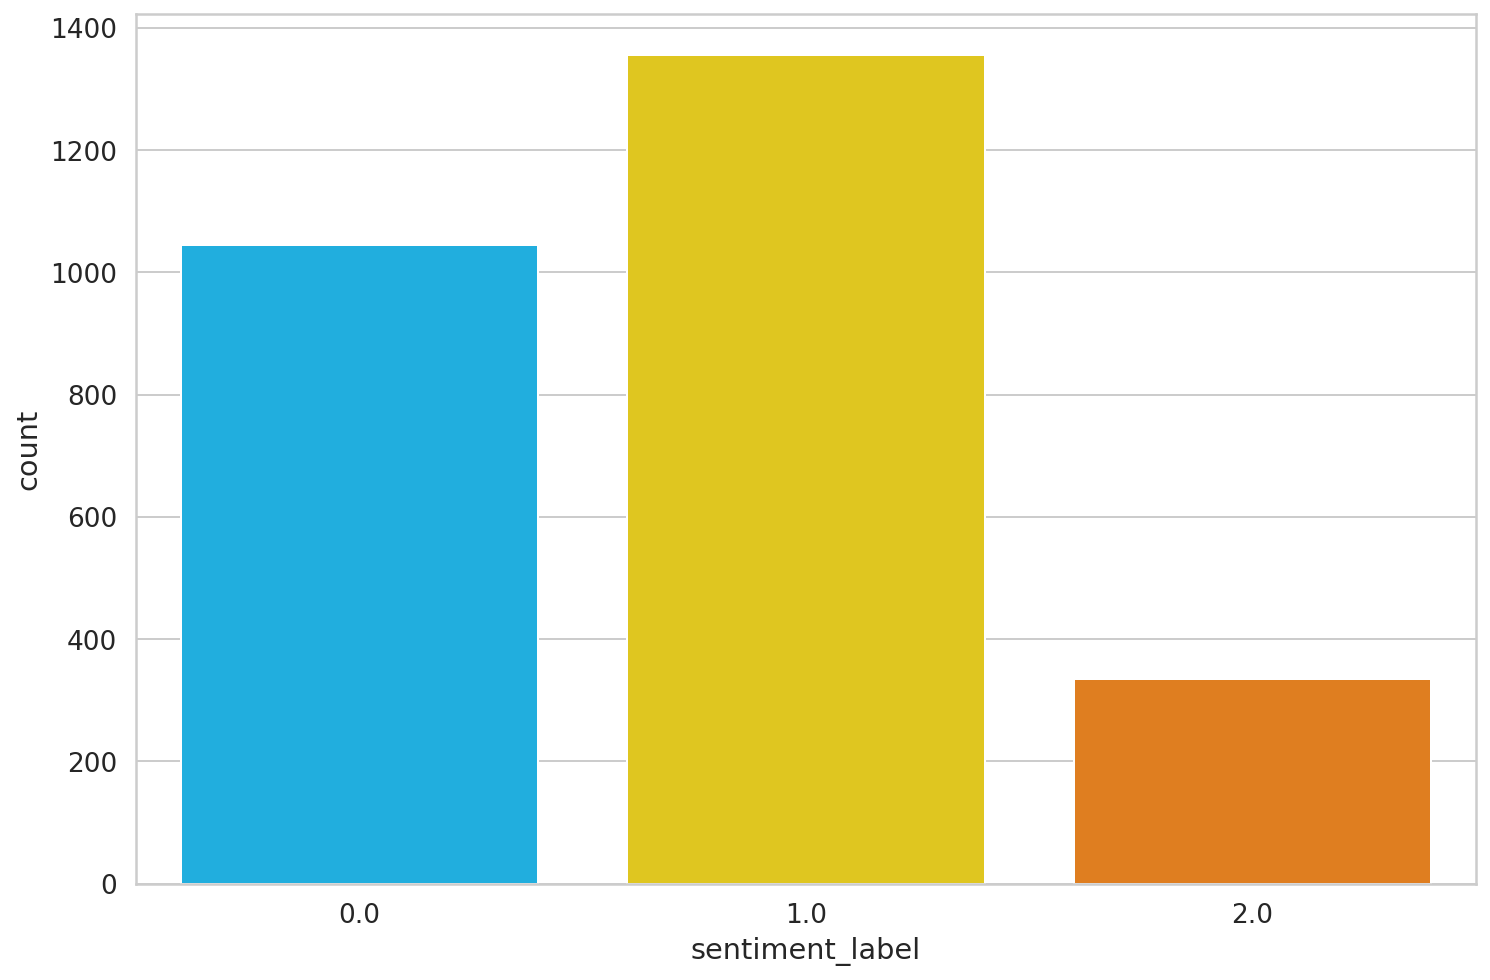

In [8]:
sns.countplot(data.sentiment_label)
plt.xlabel('sentiment_label');

In [10]:
token_lens = []
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
for txt in data.text_processed_notags:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


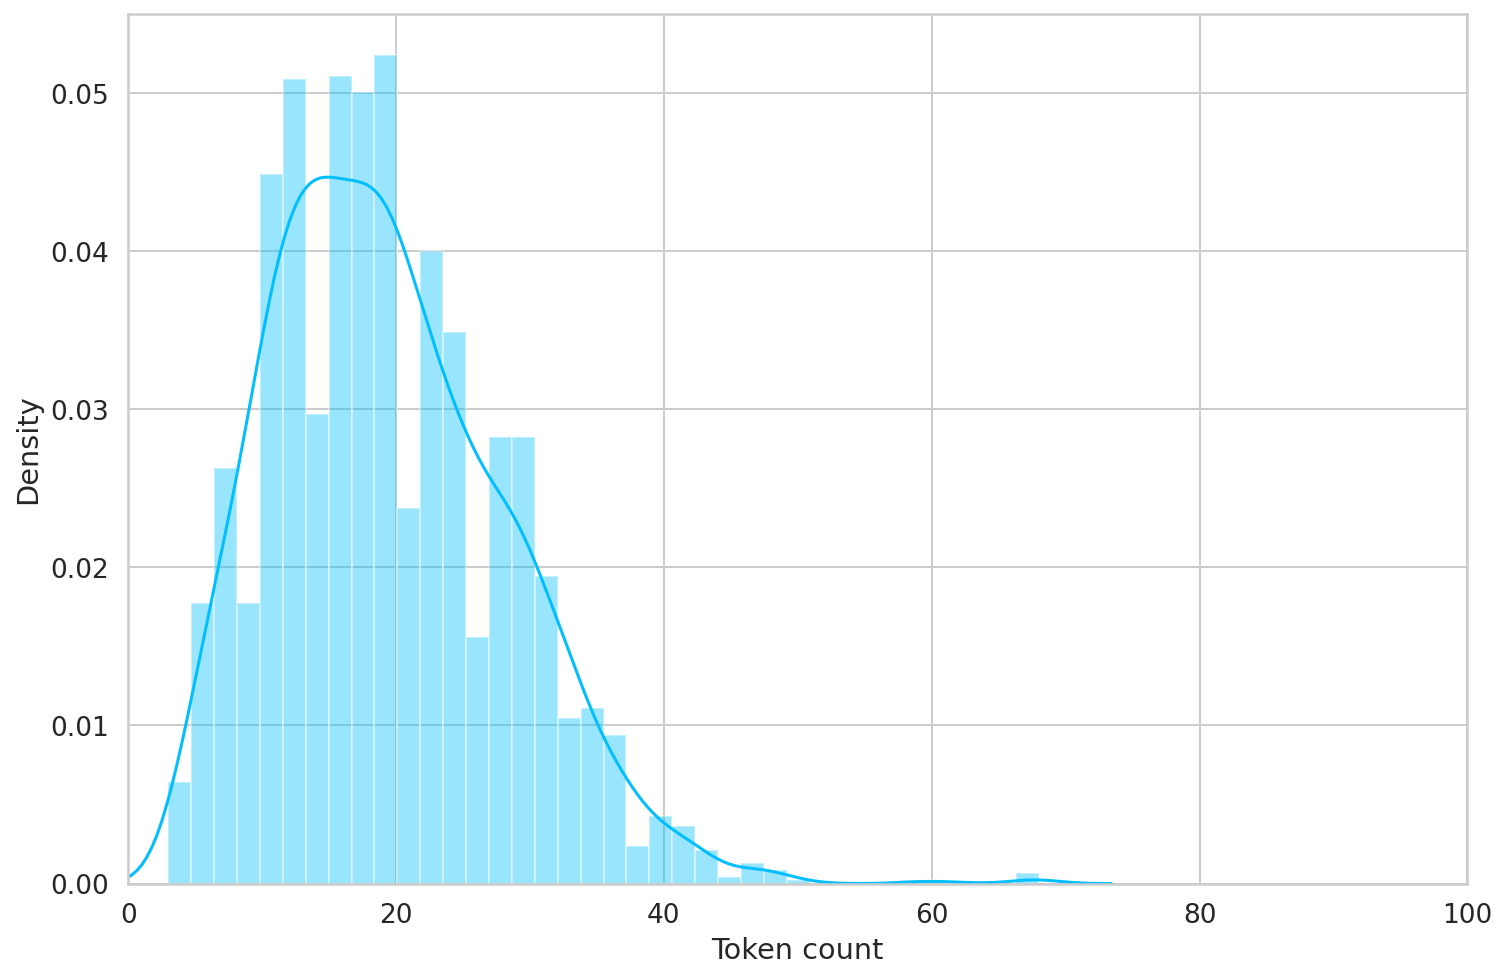

In [13]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

### Model building

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
text = 'I DISLIKE you.'

In [19]:
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I DISLIKE you.
   Tokens: ['I', 'D', '##IS', '##L', '##I', '##KE', 'you', '.']
Token IDs: [146, 141, 6258, 2162, 2240, 22441, 1128, 119]


In [12]:
MAX_LEN = 100
BATCH_SIZE = 8

In [13]:
# create pytorch dataset
class TweetSentimentDataset(Dataset):
  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=True,
        # pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        padding='max_length',
        truncation=True

    )
    return {
        'tweet':tweet,
        'input_ids':torch.tensor(encoding['input_ids']).flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        # 'token_type_ids':encoding['token_type_ids'].flatten(),
        'labels': torch.tensor(label, dtype=torch.long)
    }

In [14]:
df = pd.read_csv('/content/drive/MyDrive/twitter-sentiment-analysis/data/Apple-Twitter-Sentiment-DFE.csv', engine='python')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2734 entries, 0 to 2733
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               2734 non-null   int64  
 1   _golden                2734 non-null   bool   
 2   _unit_state            2734 non-null   object 
 3   _trusted_judgments     2734 non-null   float64
 4   _last_judgment_at      2637 non-null   object 
 5   sentiment              2734 non-null   float64
 6   sentiment:confidence   2734 non-null   float64
 7   date                   2734 non-null   object 
 8   id                     2734 non-null   float64
 9   query                  2734 non-null   object 
 10  sentiment_gold         97 non-null     object 
 11  text                   2734 non-null   object 
 12  text_processing        2734 non-null   object 
 13  text_processed_notags  2734 non-null   object 
 14  sentiment_label        2734 non-null   float64
dtypes: b

In [25]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=40)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=40)
df_train.shape, df_val.shape, df_test.shape

NameError: ignored

In [15]:
# data loader
def create_data_loader(df, text, tokenizer, max_len, batch_size):
  ds = TweetSentimentDataset(
    tweets=df[text].to_numpy(),
    labels=df.sentiment_label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [11]:
train_data_loader = create_data_loader(df_train, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, 'text_processed_notags',tokenizer, MAX_LEN, BATCH_SIZE)

In [16]:
class SentimentClassifier(nn.Module):

  def __init__(self, PRE_TRAINED_MODEL_NAME, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    output = self.drop(pooled_output[0])
    return self.out(output)

In [ ]:
model = SentimentClassifier('bert-base-cased', 3)
model = model.to(device)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /

In [22]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)



NameError: ignored

In [17]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  print()
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)
    print(input_ids.unsqueeze(0).shape)
    outputs = model(  
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    print('here')
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs.logits, dim=1)

      loss = loss_fn(outputs.logits, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def get_predictions(model, data_loader, device):
  model = model.eval()
  
  review_tweets = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweet"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs.logits, dim=1)

      probs = F.softmax(outputs.logits, dim=1)

      review_tweets.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_tweets, predictions, prediction_probs, real_values

In [20]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [21]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [20]:
def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, scheduler, len_train, len_val, output_path):
  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      len_train
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn, 
      device, 
      len_val
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), output_path)
      best_accuracy = val_acc

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/twitter-sentiment-analysis/best_model_state3_cased.bin')
    best_accuracy = val_acc

Epoch 1/10
----------

Train loss 1.1215736595993369 accuracy 0.38454935622317593
Val   loss 1.0782029799052648 accuracy 0.47692307692307695

Epoch 2/10
----------

Train loss 1.1002051616326356 accuracy 0.40171673819742487
Val   loss 0.9876888394355774 accuracy 0.5076923076923077

Epoch 3/10
----------

Train loss 0.9950662087171506 accuracy 0.5141630901287554
Val   loss 0.8095829827444894 accuracy 0.6461538461538462

Epoch 4/10
----------

Train loss 0.7816647025000336 accuracy 0.6841201716738197
Val   loss 0.9254803316933768 accuracy 0.6615384615384616

Epoch 5/10
----------

Train loss 0.561949472142081 accuracy 0.8171673819742489
Val   loss 0.9785821693284171 accuracy 0.676923076923077

Epoch 6/10
----------

Train loss 0.42646731296156204 accuracy 0.8763948497854077
Val   loss 1.1041707481656755 accuracy 0.7076923076923077

Epoch 7/10
----------

Train loss 0.32591065142749465 accuracy 0.9133047210300429
Val   loss 1.046433913920607 accuracy 0.7538461538461538

Epoch 8/10
-------

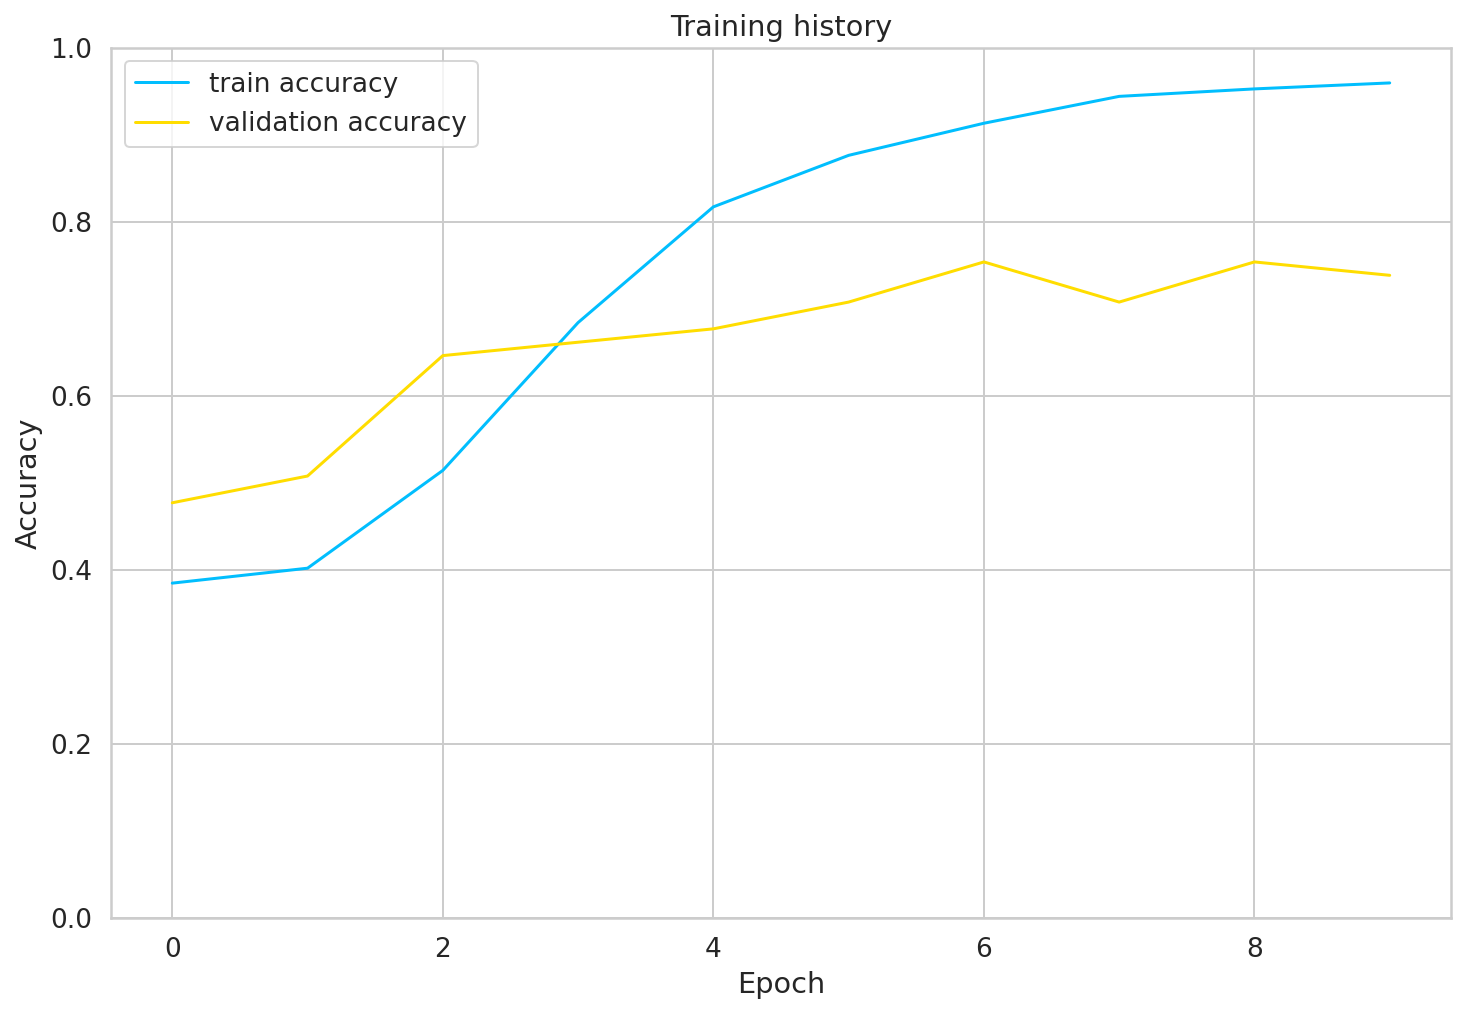

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Evaluation

In [ ]:
best_model = SentimentClassifier('bert-base-cased',3)

# best_model.load_state_dict(torch.load(r'Google Drive/My Drive/twitter-sentiment-analysis/best_model_state1.bin', map_location=torch.device('cpu')))
best_model.load_state_dict(torch.load(r'/content/drive/MyDrive/twitter-sentiment-analysis/best_model_state4_cased.bin', map_location=torch.device(device)))
best_model.to(device)
print(next(best_model.parameters()).device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [65]:
best_model = SentimentClassifier('bert-base-cased',3)

# best_model.load_state_dict(torch.load(r'Google Drive/My Drive/twitter-sentiment-analysis/best_model_state1.bin', map_location=torch.device('cpu')))
best_model.load_state_dict(torch.load(r'/content/drive/MyDrive/twitter-sentiment-analysis/model_checkpoints/best_model_state4_cased.bin', map_location=torch.device(device)), False)
best_model.to(device)
print(next(best_model.parameters()).device)

test_acc, _ = eval_model(
  best_model.to(device),
  test_data_loader,
  loss_fn,
  device,
  len(df)
)

print('Testing Accuracy: ',test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  best_model.to(device),
  test_data_loader,
  device
)

print(classification_report(y_test, y_pred, target_names=['negative', 'neutral','positive']))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

cpu


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


IndexError: ignored

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
test_acc, _ = eval_model(
  best_model.to('cpu'),
  test_data_loader,
  loss_fn,
  'cpu',
  len(df_test)
)

test_acc.item()

0.6307692307692307

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  best_model.to('cpu'),
  test_data_loader,
  'cpu'
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral','positive']))

              precision    recall  f1-score   support

    negative       0.67      0.67      0.67        21
     neutral       0.76      0.59      0.67        22
    positive       0.52      0.64      0.57        22

    accuracy                           0.63        65
   macro avg       0.65      0.63      0.63        65
weighted avg       0.65      0.63      0.63        65



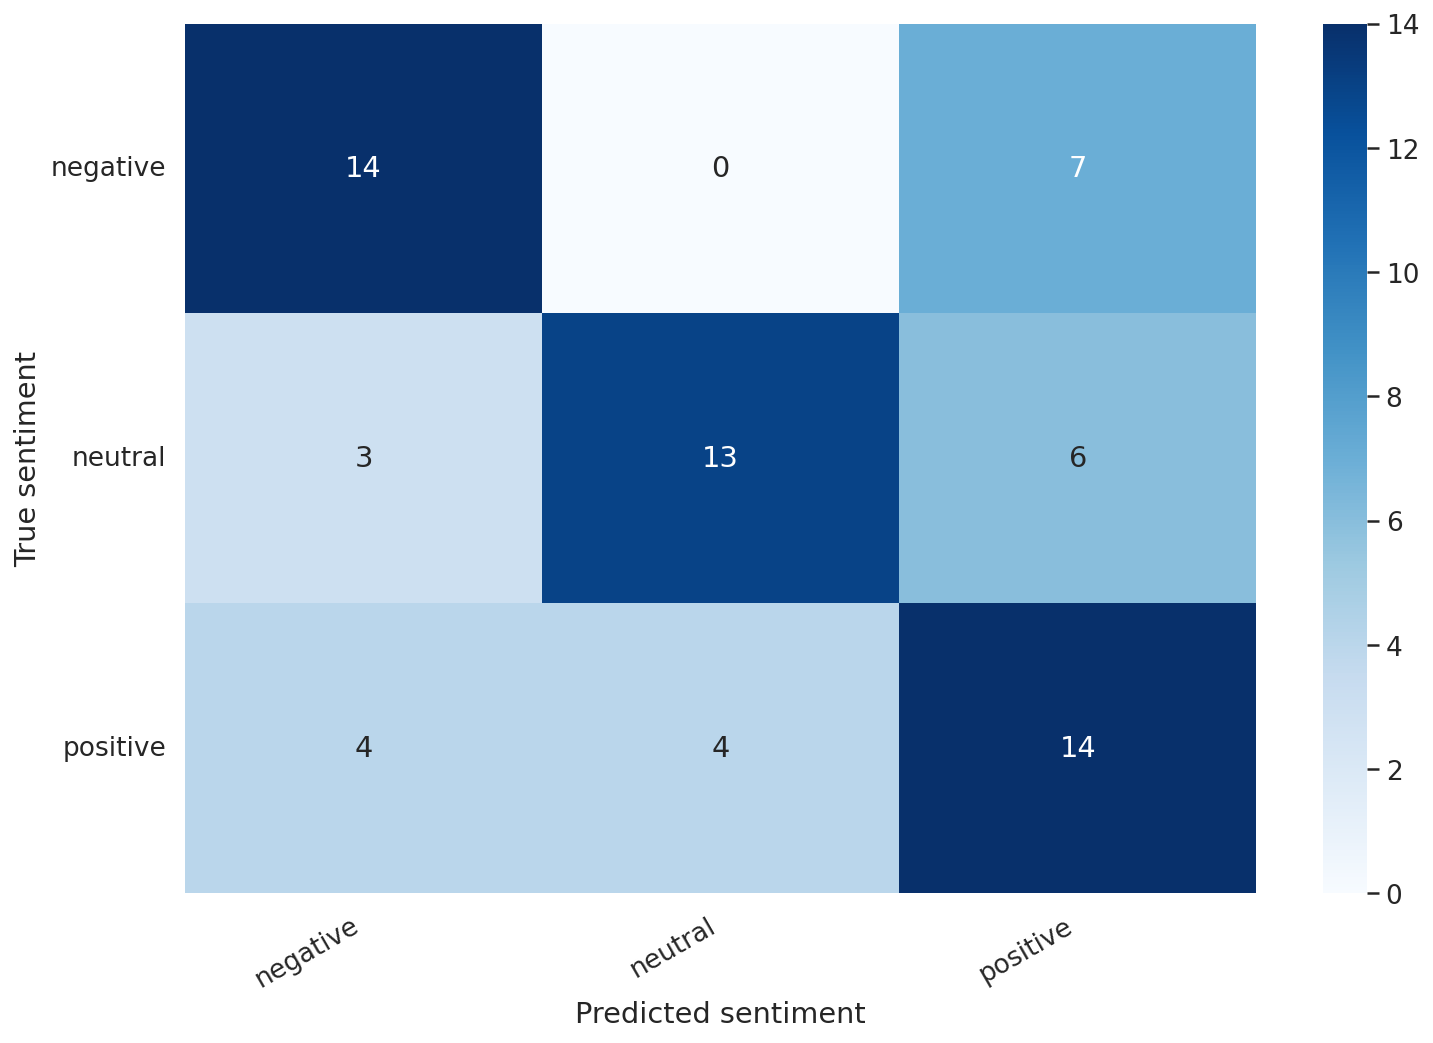

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['negative', 'neutral','positive'], columns=['negative', 'neutral','positive'])
show_confusion_matrix(df_cm)

Train BERT without tags

In [ ]:
BATCH_SIZE = 8

train_data_loader_notags = create_data_loader(df_train, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader_notags = create_data_loader(df_val, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader_notags = create_data_loader(df_test, 'text_processed_notags',tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model_notags = SentimentClassifier('bert-base-cased', 3)
model_notags = model_notags.to(device)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /

In [ ]:
history_notags = defaultdict(list)
best_accuracy_notags = 0
EPOCHS = 10

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model_notags,
    train_data_loader_notags,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model_notags,
    val_data_loader_notags,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history_notags['train_acc'].append(train_acc)
  history_notags['train_loss'].append(train_loss)
  history_notags['val_acc'].append(val_acc)
  history_notags['val_loss'].append(val_loss)

  if val_acc > best_accuracy_notags:
    torch.save(model.state_dict(), '/content/drive/MyDrive/twitter-sentiment-analysis/best_model_4_notags_cased.bin')
    best_accuracy_notags = val_acc

Epoch 1/10
----------

Train loss 1.2271992441726058 accuracy 0.31759656652360513
Val   loss 1.1865569882922702 accuracy 0.38461538461538464

Epoch 2/10
----------

Train loss 1.216417522054829 accuracy 0.31759656652360513
Val   loss 1.1865569882922702 accuracy 0.38461538461538464

Epoch 3/10
----------

Train loss 1.2243074742082047 accuracy 0.32961373390557935
Val   loss 1.1865569882922702 accuracy 0.38461538461538464

Epoch 4/10
----------

Train loss 1.215229678643893 accuracy 0.3218884120171674
Val   loss 1.1865569882922702 accuracy 0.38461538461538464

Epoch 5/10
----------

Train loss 1.21272708373527 accuracy 0.3158798283261802
Val   loss 1.1865569882922702 accuracy 0.38461538461538464

Epoch 6/10
----------

Train loss 1.2195864993415466 accuracy 0.31759656652360513
Val   loss 1.1865569882922702 accuracy 0.38461538461538464

Epoch 7/10
----------

Train loss 1.2254388213974157 accuracy 0.3167381974248927
Val   loss 1.1865569882922702 accuracy 0.38461538461538464

Epoch 8/10
--

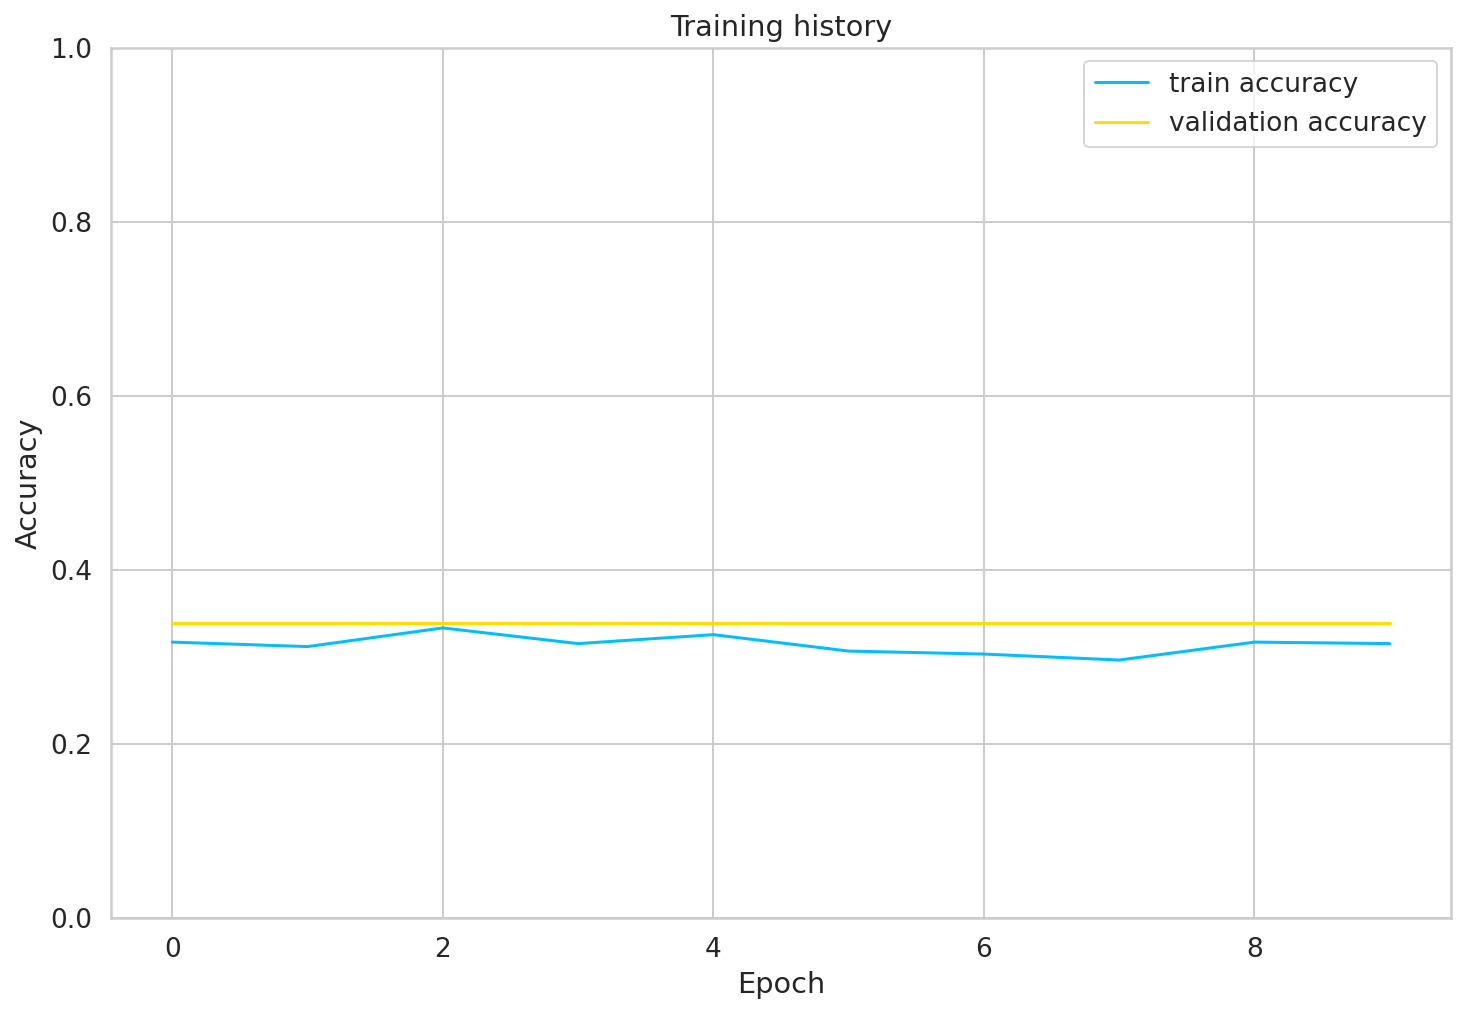

In [ ]:
plt.plot(history_notags['train_acc'], label='train accuracy')
plt.plot(history_notags['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

BERT Fine-tuning

In [ ]:
! pip install optuna
! pip install ray[tune]

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for pre_run_cell):


Exception: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for post_run_cell):


Exception: ignored

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='micro')
    precision = precision_score(y_true=labels, y_pred=pred, average='micro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='micro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
def model_init(num_labels):
    return AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3, return_dict=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_encodings = tokenizer(list(df_train['text_processed']), truncation=True, padding='max_length', max_length=MAX_LEN)
val_encodings = tokenizer(list(df_val['text_processed']), truncation=True, padding='max_length', max_length=MAX_LEN)
test_encodings = tokenizer(list(df_test['text_processed']), truncation=True, padding='max_length', max_length=MAX_LEN)

In [ ]:
class TweetDatasetForTune(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDatasetForTune(train_encodings, list(df_train['sentiment_label']))
val_dataset = TweetDatasetForTune(val_encodings, list(df_val['sentiment_label']))
test_dataset = TweetDatasetForTune(test_encodings, list(df_test['sentiment_label']))

In [ ]:
training_args = TrainingArguments(
    "test", evaluation_strategy="steps", eval_steps=500)
trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    model_init=model_init,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_vers

In [ ]:
trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    n_trials=10 # number of trials
)

In [ ]:
3

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for pre_run_cell):


Exception: ignored

3

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for post_run_cell):


Exception: ignored

Hyper-parameter tuning with Population Based Training

In [ ]:
!pip install wandb
import os
os.environ["WANDB_API_KEY"] = "378b4815b03e2ff0fc7c0b85542bb00bc782395f"

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for pre_run_cell):


Exception: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for post_run_cell):


Exception: ignored

In [ ]:
import ray

ray.shutdown()
ray.init(log_to_driver=True, ignore_reinit_error=True)

{'metrics_export_port': 61304,
 'node_id': 'bbf2ebb37feabc070aefcaa3f760f2585e291882575b3bc7b862f2e2',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-12-15_16-23-13_460654_83/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-12-15_16-23-13_460654_83/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-12-15_16-23-13_460654_83',
 'webui_url': None}

In [ ]:
!nvidia-smi

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for pre_run_cell):


Exception: ignored

Wed Dec 15 18:43:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    37W / 250W |   9901MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Exception: ignored

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.examples.pbt_transformers.utils import download_data, \
    build_compute_metrics_fn
from ray.tune.schedulers import PopulationBasedTraining
from transformers import glue_tasks_num_labels, AutoConfig, \
    AutoModelForSequenceClassification, AutoTokenizer, Trainer, GlueDataset, \
    GlueDataTrainingArguments, TrainingArguments

num_labels = 3
model_name = 'bert-base-cased'

config = AutoConfig.from_pretrained(
    model_name, num_labels=num_labels)

# Download and cache tokenizer, model, and features
print("Downloading and caching Tokenizer")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Triggers tokenizer download to cache
print("Downloading and caching pre-trained model")
AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config,
)

def get_model():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )


training_args = TrainingArguments(
    output_dir=".",
    learning_rate=1e-5,  # config
    do_train=True,
    do_eval=True,
    no_cuda=1 <= 0,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    num_train_epochs=2,  # config
    max_steps=-1,
    per_device_train_batch_size=16,  # config
    per_device_eval_batch_size=16,  # config
    warmup_steps=0,
    weight_decay=0.1,  # config
    logging_dir="./logs",
    skip_memory_metrics=True,
    report_to="wandb")

trainer = Trainer(
    model_init=get_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics)

tune_config = {
    "per_device_train_batch_size": 8,
    "per_device_eval_batch_size": 8,
    "num_train_epochs": tune.choice([2, 3, 4, 5]),
    "max_steps": -1
}

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="eval_accuracy",
    mode="max",
    perturbation_interval=1,
    hyperparam_mutations={
        "weight_decay": tune.uniform(0.0, 0.3),
        "learning_rate": tune.uniform(1e-5, 5e-5),
        "per_device_train_batch_size": [4, 8, 16],
    })

reporter = CLIReporter(
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_epochs"
    },
    metric_columns=[
        "eval_acc", "eval_loss", "epoch", "training_iteration"
    ])

trainer.hyperparameter_search(
    hp_space=lambda _: tune_config,
    backend="ray",
    n_trials=5,
    resources_per_trial={
        "cpu": 1,
        "gpu": 1
    },
    scheduler=scheduler,
    keep_checkpoints_num=1,
    checkpoint_score_attr="training_iteration",
    stop=None,
    progress_reporter=reporter,
    local_dir="~/ray_results/",
    name="pbt_bert",
    log_to_file=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

== Status ==
Current time: 2021-12-15 16:24:19 (running for 00:00:00.18)
Memory usage on this node: 3.7/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

(ImplicitFunc pid=524) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
(ImplicitFunc pid=524) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=524) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=524) Some 

== Status ==
Current time: 2021-12-15 16:24:35 (running for 00:00:16.17)
Memory usage on this node: 5.8/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

(ImplicitFunc pid=524) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=524) wandb: Syncing run .
(ImplicitFunc pid=524) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=524) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/4nkcid0d
(ImplicitFunc pid=524) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/wandb/run-20211215_162432-4nkcid0d
(ImplicitFunc pid=524) wandb: Run `wandb offline` to turn off syncing.
  0%|          | 0/584 [00:00<?, ?it/s]


(ImplicitFunc pid=524) 
(ImplicitFunc pid=524) signal only works in main thread


  2%|▏         | 14/584 [00:03<02:14,  4.24it/s]


== Status ==
Current time: 2021-12-15 16:24:40 (running for 00:00:21.19)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

  6%|▌         | 36/584 [00:08<02:08,  4.26it/s]


== Status ==
Current time: 2021-12-15 16:24:45 (running for 00:00:26.21)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

 10%|▉         | 57/584 [00:13<02:04,  4.23it/s]


== Status ==
Current time: 2021-12-15 16:24:50 (running for 00:00:31.24)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

 14%|█▎        | 79/584 [00:18<01:59,  4.23it/s]


== Status ==
Current time: 2021-12-15 16:24:55 (running for 00:00:36.26)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

 17%|█▋        | 101/584 [00:23<01:53,  4.27it/s]


== Status ==
Current time: 2021-12-15 16:25:00 (running for 00:00:41.28)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

 21%|██        | 122/584 [00:28<01:48,  4.26it/s]


== Status ==
Current time: 2021-12-15 16:25:05 (running for 00:00:46.31)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

 24%|██▍       | 142/584 [00:33<01:43,  4.28it/s]


== Status ==
Current time: 2021-12-15 16:25:10 (running for 00:00:51.33)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524 | 0.238963  | 1.73374e-05 |              8 |            4 |
| _objective_74390_00001 | PENDING  |                | 0.179598  | 1.62407e-05 |              8 |            5 |
| _objective_74390_00002 | PENDING  |                | 0.0299925 | 

 25%|██▌       | 146/584 [00:34<01:33,  4.67it/s]
(ImplicitFunc pid=524) 
  0%|          | 0/9 [00:00<?, ?it/s]
(ImplicitFunc pid=524) 
 33%|███▎      | 3/9 [00:00<00:00, 21.40it/s]
(ImplicitFunc pid=524) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.61it/s]
(ImplicitFunc pid=524) 
                                                 
100%|██████████| 9/9 [00:00<00:00, 15.68it/s]
                                             


(ImplicitFunc pid=524) {'eval_loss': 0.9818971753120422, 'eval_accuracy': 0.47692307692307695, 'eval_precision': 0.47692307692307695, 'eval_recall': 0.47692307692307695, 'eval_f1': 0.47692307692307695, 'eval_runtime': 0.5884, 'eval_samples_per_second': 110.476, 'eval_steps_per_second': 15.297, 'epoch': 1.0}
== Status ==
Current time: 2021-12-15 16:25:15 (running for 00:00:56.35)
Memory usage on this node: 5.9/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |
|------------------------+----------+----------------+-----------+-------------+----------------+

(ImplicitFunc pid=524) tcmalloc: large alloc 1083285504 bytes == 0x55a17f2ba000 @  0x7fdece420615 0x55a032d334cc 0x55a032e1347a 0x55a032e4b793 0x55a032d373ce 0x55a032d372f9 0x7fdece85e8c2 0x7fdece85fedb 0x7fdece866809 0x7fdece866c90 0x7fdece866c90 0x7fdece86715e 0x7fdece8672c7 0x55a032d362ed 0x55a032e27e1d 0x55a032daa228 0x55a032d37afa 0x55a032da5c0d 0x55a032da49ee 0x55a032d37bda 0x55a032da9d00 0x55a032d37afa 0x55a032da9d00 0x55a032d37afa 0x55a032da9d00 0x55a032c76d14 0x55a032da6fe4 0x55a032da4ced 0x55a032c76eb0 0x55a032da6fe4 0x55a032da4ced
(ImplicitFunc pid=524) tcmalloc: large alloc 1354113024 bytes == 0x55a1bfbd4000 @  0x7fdece420615 0x55a032d334cc 0x55a032e1347a 0x55a032e4b793 0x55a032d373ce 0x55a032d372f9 0x7fdece85fefc 0x7fdece866809 0x7fdece866c90 0x7fdece866c90 0x7fdece86715e 0x7fdece8672c7 0x55a032d362ed 0x55a032e27e1d 0x55a032daa228 0x55a032d37afa 0x55a032da5c0d 0x55a032da49ee 0x55a032d37bda 0x55a032da9d00 0x55a032d37afa 0x55a032da9d00 0x55a032d37afa 0x55a032da9d00 0x55a032c

== Status ==
Current time: 2021-12-15 16:25:21 (running for 00:01:01.86)
Memory usage on this node: 6.5/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

(ImplicitFunc pid=523) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
(ImplicitFunc pid=523) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=523) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=523) Some 

== Status ==
Current time: 2021-12-15 16:25:37 (running for 00:01:17.96)
Memory usage on this node: 7.0/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

(ImplicitFunc pid=523) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=523) wandb: Syncing run .
(ImplicitFunc pid=523) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=523) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/20qp916k
(ImplicitFunc pid=523) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/wandb/run-20211215_162534-20qp916k
(ImplicitFunc pid=523) wandb: Run `wandb offline` to turn off syncing.
  0%|          | 0/730 [00:00<?, ?it/s]


(ImplicitFunc pid=523) 
(ImplicitFunc pid=523) signal only works in main thread


  2%|▏         | 16/730 [00:03<02:47,  4.27it/s]


== Status ==
Current time: 2021-12-15 16:25:42 (running for 00:01:22.98)
Memory usage on this node: 7.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

  5%|▌         | 38/730 [00:08<02:42,  4.27it/s]


== Status ==
Current time: 2021-12-15 16:25:47 (running for 00:01:28.00)
Memory usage on this node: 7.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

  8%|▊         | 59/730 [00:13<02:37,  4.27it/s]


== Status ==
Current time: 2021-12-15 16:25:52 (running for 00:01:33.02)
Memory usage on this node: 7.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

 11%|█         | 80/730 [00:18<02:31,  4.28it/s]


== Status ==
Current time: 2021-12-15 16:25:57 (running for 00:01:38.04)
Memory usage on this node: 7.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

 14%|█▍        | 102/730 [00:24<02:27,  4.27it/s]


== Status ==
Current time: 2021-12-15 16:26:02 (running for 00:01:43.07)
Memory usage on this node: 7.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

 17%|█▋        | 123/730 [00:28<02:21,  4.28it/s]


== Status ==
Current time: 2021-12-15 16:26:07 (running for 00:01:48.09)
Memory usage on this node: 7.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

 20%|█▉        | 145/730 [00:34<02:17,  4.27it/s]


== Status ==
Current time: 2021-12-15 16:26:12 (running for 00:01:53.11)
Memory usage on this node: 7.1/25.5 GiB
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 3 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523 | 0.179598  | 1.62407e-05 |              8 |            5 |             |         |      

 20%|██        | 146/730 [00:34<02:05,  4.64it/s]
(ImplicitFunc pid=523) 
  0%|          | 0/9 [00:00<?, ?it/s]
(ImplicitFunc pid=523) 
 33%|███▎      | 3/9 [00:00<00:00, 21.41it/s]
(ImplicitFunc pid=523) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.56it/s]
(ImplicitFunc pid=523) 
                                                 
100%|██████████| 9/9 [00:00<00:00, 15.64it/s]
                                             


(ImplicitFunc pid=523) {'eval_loss': 1.0158549547195435, 'eval_accuracy': 0.47692307692307695, 'eval_precision': 0.47692307692307695, 'eval_recall': 0.47692307692307695, 'eval_f1': 0.47692307692307695, 'eval_runtime': 0.5824, 'eval_samples_per_second': 111.611, 'eval_steps_per_second': 15.454, 'epoch': 1.0}
Result for _objective_74390_00001:
  date: 2021-12-15_16-26-17
  done: false
  epoch: 1.0
  eval_accuracy: 0.47692307692307695
  eval_f1: 0.47692307692307695
  eval_loss: 1.0158549547195435
  eval_precision: 0.47692307692307695
  eval_recall: 0.47692307692307695
  eval_runtime: 0.5824
  eval_samples_per_second: 111.611
  eval_steps_per_second: 15.454
  experiment_id: 5dd6e2ba80044be68130b2d947dbd753
  hostname: f913bc1c5136
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.9076923076923078
  pid: 523
  should_checkpoint: true
  time_since_restore: 50.97547650337219
  time_this_iter_s: 50.97547650337219
  time_total_s: 50.97547650337219
  timestamp: 1639585577
  time

(ImplicitFunc pid=523) tcmalloc: large alloc 1083285504 bytes == 0x5563eac5e000 @  0x7fe5971a1615 0x55629f5444cc 0x55629f62447a 0x55629f65c793 0x55629f5483ce 0x55629f5482f9 0x7fe5975df8c2 0x7fe5975e0edb 0x7fe5975e7809 0x7fe5975e7c90 0x7fe5975e7c90 0x7fe5975e815e 0x7fe5975e82c7 0x55629f5472ed 0x55629f638e1d 0x55629f5bb228 0x55629f548afa 0x55629f5b6c0d 0x55629f5b59ee 0x55629f548bda 0x55629f5bad00 0x55629f548afa 0x55629f5bad00 0x55629f548afa 0x55629f5bad00 0x55629f487d14 0x55629f5b7fe4 0x55629f5b5ced 0x55629f487eb0 0x55629f5b7fe4 0x55629f5b5ced
(ImplicitFunc pid=523) tcmalloc: large alloc 1354113024 bytes == 0x55642b578000 @  0x7fe5971a1615 0x55629f5444cc 0x55629f62447a 0x55629f65c793 0x55629f5483ce 0x55629f5482f9 0x7fe5975e0efc 0x7fe5975e7809 0x7fe5975e7c90 0x7fe5975e7c90 0x7fe5975e815e 0x7fe5975e82c7 0x55629f5472ed 0x55629f638e1d 0x55629f5bb228 0x55629f548afa 0x55629f5b6c0d 0x55629f5b59ee 0x55629f548bda 0x55629f5bad00 0x55629f548afa 0x55629f5bad00 0x55629f548afa 0x55629f5bad00 0x55629f4

== Status ==
Current time: 2021-12-15 16:26:23 (running for 00:02:04.43)
Memory usage on this node: 9.1/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

(ImplicitFunc pid=525) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
(ImplicitFunc pid=525) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=525) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=525) Some 

== Status ==
Current time: 2021-12-15 16:26:39 (running for 00:02:20.47)
Memory usage on this node: 9.4/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

(ImplicitFunc pid=525) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=525) wandb: Syncing run .
(ImplicitFunc pid=525) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=525) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/4me5f99a
(ImplicitFunc pid=525) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/wandb/run-20211215_162637-4me5f99a
(ImplicitFunc pid=525) wandb: Run `wandb offline` to turn off syncing.
  3%|▎         | 15/584 [00:03<02:14,  4.25it/s]


== Status ==
Current time: 2021-12-15 16:26:44 (running for 00:02:25.49)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

  6%|▌         | 36/584 [00:08<02:09,  4.25it/s]


== Status ==
Current time: 2021-12-15 16:26:49 (running for 00:02:30.51)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

 10%|▉         | 58/584 [00:13<02:04,  4.23it/s]


== Status ==
Current time: 2021-12-15 16:26:54 (running for 00:02:35.54)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

 13%|█▎        | 78/584 [00:18<01:59,  4.24it/s]


== Status ==
Current time: 2021-12-15 16:26:59 (running for 00:02:40.56)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

 17%|█▋        | 100/584 [00:23<01:54,  4.23it/s]


== Status ==
Current time: 2021-12-15 16:27:04 (running for 00:02:45.58)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

 21%|██        | 121/584 [00:28<01:49,  4.25it/s]


== Status ==
Current time: 2021-12-15 16:27:09 (running for 00:02:50.59)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

 24%|██▍       | 142/584 [00:33<01:44,  4.23it/s]


== Status ==
Current time: 2021-12-15 16:27:14 (running for 00:02:55.62)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

 25%|██▌       | 146/584 [00:34<01:34,  4.62it/s]
(ImplicitFunc pid=525) 
  0%|          | 0/9 [00:00<?, ?it/s]
(ImplicitFunc pid=525) 
 33%|███▎      | 3/9 [00:00<00:00, 21.52it/s]
(ImplicitFunc pid=525) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.56it/s]


(ImplicitFunc pid=525) {'eval_loss': 0.9272728562355042, 'eval_accuracy': 0.5846153846153846, 'eval_precision': 0.5846153846153846, 'eval_recall': 0.5846153846153846, 'eval_f1': 0.5846153846153846, 'eval_runtime': 0.5804, 'eval_samples_per_second': 111.999, 'eval_steps_per_second': 15.508, 'epoch': 1.0}


(ImplicitFunc pid=525) 
                                                 
100%|██████████| 9/9 [00:00<00:00, 15.64it/s]
                                             


== Status ==
Current time: 2021-12-15 16:27:19 (running for 00:03:00.64)
Memory usage on this node: 9.5/25.5 GiB
PopulationBasedTraining: 1 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 2 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525 | 0.0299925 | 2.837e-05   |              8 |            4 |             |         |      

(ImplicitFunc pid=525) tcmalloc: large alloc 1083285504 bytes == 0x55b37bb58000 @  0x7fdc61787615 0x55b24a20c4cc 0x55b24a2ec47a 0x55b24a324793 0x55b24a2103ce 0x55b24a2102f9 0x7fdc61bc58c2 0x7fdc61bc6edb 0x7fdc61bcd809 0x7fdc61bcdc90 0x7fdc61bcdc90 0x7fdc61bce15e 0x7fdc61bce2c7 0x55b24a20f2ed 0x55b24a300e1d 0x55b24a283228 0x55b24a210afa 0x55b24a27ec0d 0x55b24a27d9ee 0x55b24a210bda 0x55b24a282d00 0x55b24a210afa 0x55b24a282d00 0x55b24a210afa 0x55b24a282d00 0x55b24a14fd14 0x55b24a27ffe4 0x55b24a27dced 0x55b24a14feb0 0x55b24a27ffe4 0x55b24a27dced
(ImplicitFunc pid=525) tcmalloc: large alloc 1354113024 bytes == 0x55b3bc472000 @  0x7fdc61787615 0x55b24a20c4cc 0x55b24a2ec47a 0x55b24a324793 0x55b24a2103ce 0x55b24a2102f9 0x7fdc61bc6efc 0x7fdc61bcd809 0x7fdc61bcdc90 0x7fdc61bcdc90 0x7fdc61bce15e 0x7fdc61bce2c7 0x55b24a20f2ed 0x55b24a300e1d 0x55b24a283228 0x55b24a210afa 0x55b24a27ec0d 0x55b24a27d9ee 0x55b24a210bda 0x55b24a282d00 0x55b24a210afa 0x55b24a282d00 0x55b24a210afa 0x55b24a282d00 0x55b24a1

== Status ==
Current time: 2021-12-15 16:27:24 (running for 00:03:05.66)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

(ImplicitFunc pid=526) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
(ImplicitFunc pid=526) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=526) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=526) Some 

== Status ==
Current time: 2021-12-15 16:28:15 (running for 00:03:56.74)
Memory usage on this node: 12.7/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

(ImplicitFunc pid=526) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:28:21 (running for 00:04:01.75)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

(ImplicitFunc pid=526) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=526) wandb: Syncing run .
(ImplicitFunc pid=526) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=526) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/u0i5qgsu
(ImplicitFunc pid=526) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00003_3_num_train_epochs=2_2021-12-15_16-26-21/wandb/run-20211215_162816-u0i5qgsu
(ImplicitFunc pid=526) wandb: Run `wandb offline` to turn off syncing.
  7%|▋         | 19/292 [00:04<01:06,  4.12it/s]


== Status ==
Current time: 2021-12-15 16:28:26 (running for 00:04:06.78)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

 14%|█▎        | 40/292 [00:09<00:58,  4.28it/s]


== Status ==
Current time: 2021-12-15 16:28:31 (running for 00:04:11.79)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

 21%|██        | 61/292 [00:14<00:53,  4.28it/s]


== Status ==
Current time: 2021-12-15 16:28:36 (running for 00:04:16.82)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

 29%|██▉       | 84/292 [00:19<00:48,  4.28it/s]


== Status ==
Current time: 2021-12-15 16:28:41 (running for 00:04:21.84)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

 36%|███▌      | 104/292 [00:24<00:44,  4.24it/s]


== Status ==
Current time: 2021-12-15 16:28:46 (running for 00:04:26.86)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

 43%|████▎     | 126/292 [00:29<00:38,  4.28it/s]


== Status ==
Current time: 2021-12-15 16:28:51 (running for 00:04:31.88)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

  0%|          | 0/9 [00:00<?, ?it/s]


== Status ==
Current time: 2021-12-15 16:28:56 (running for 00:04:36.90)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 2 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc            |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526 | 0.180335  | 3.83229e-05 |              8 |            2 |             |         |     

(ImplicitFunc pid=526) 
 33%|███▎      | 3/9 [00:00<00:00, 21.42it/s]
(ImplicitFunc pid=526) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.63it/s]
(ImplicitFunc pid=526) 
                                                 
100%|██████████| 9/9 [00:00<00:00, 15.67it/s]
                                             


(ImplicitFunc pid=526) {'eval_loss': 0.9013975858688354, 'eval_accuracy': 0.6153846153846154, 'eval_precision': 0.6153846153846154, 'eval_recall': 0.6153846153846154, 'eval_f1': 0.6153846153846154, 'eval_runtime': 0.582, 'eval_samples_per_second': 111.692, 'eval_steps_per_second': 15.465, 'epoch': 1.0}
Result for _objective_74390_00003:
  date: 2021-12-15_16-29-00
  done: false
  epoch: 1.0
  eval_accuracy: 0.6153846153846154
  eval_f1: 0.6153846153846154
  eval_loss: 0.9013975858688354
  eval_precision: 0.6153846153846154
  eval_recall: 0.6153846153846154
  eval_runtime: 0.582
  eval_samples_per_second: 111.692
  eval_steps_per_second: 15.465
  experiment_id: 77b53830f14043608833907302975fa1
  hostname: f913bc1c5136
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.4615384615384617
  pid: 526
  should_checkpoint: true
  time_since_restore: 55.97150278091431
  time_this_iter_s: 55.97150278091431
  time_total_s: 55.97150278091431
  timestamp: 1639585740
  timesteps_sinc

(ImplicitFunc pid=526) tcmalloc: large alloc 1083285504 bytes == 0x55c9666be000 @  0x7f5f39125615 0x55c83376d4cc 0x55c83384d47a 0x55c833885793 0x55c8337713ce 0x55c8337712f9 0x7f5f395638c2 0x7f5f39564edb 0x7f5f3956b809 0x7f5f3956bc90 0x7f5f3956bc90 0x7f5f3956c15e 0x7f5f3956c2c7 0x55c8337702ed 0x55c833861e1d 0x55c8337e4228 0x55c833771afa 0x55c8337dfc0d 0x55c8337de9ee 0x55c833771bda 0x55c8337e3d00 0x55c833771afa 0x55c8337e3d00 0x55c833771afa 0x55c8337e3d00 0x55c8336b0d14 0x55c8337e0fe4 0x55c8337deced 0x55c8336b0eb0 0x55c8337e0fe4 0x55c8337deced
(ImplicitFunc pid=526) tcmalloc: large alloc 1354113024 bytes == 0x55c9a6fd8000 @  0x7f5f39125615 0x55c83376d4cc 0x55c83384d47a 0x55c833885793 0x55c8337713ce 0x55c8337712f9 0x7f5f39564efc 0x7f5f3956b809 0x7f5f3956bc90 0x7f5f3956bc90 0x7f5f3956c15e 0x7f5f3956c2c7 0x55c8337702ed 0x55c833861e1d 0x55c8337e4228 0x55c833771afa 0x55c8337dfc0d 0x55c8337de9ee 0x55c833771bda 0x55c8337e3d00 0x55c833771afa 0x55c8337e3d00 0x55c833771afa 0x55c8337e3d00 0x55c8336

== Status ==
Current time: 2021-12-15 16:29:07 (running for 00:04:47.99)
Memory usage on this node: 11.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

(ImplicitFunc pid=526) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=526)   len(cache))


== Status ==
Current time: 2021-12-15 16:29:17 (running for 00:04:58.71)
Memory usage on this node: 12.7/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

(ImplicitFunc pid=1188) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
(ImplicitFunc pid=1188) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=1188) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=1188) S

== Status ==
Current time: 2021-12-15 16:29:22 (running for 00:05:03.73)
Memory usage on this node: 12.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

(ImplicitFunc pid=1188) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=1188) wandb: Syncing run .
(ImplicitFunc pid=1188) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=1188) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/3qjdugab
(ImplicitFunc pid=1188) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00004_4_num_train_epochs=3_2021-12-15_16-28-04/wandb/run-20211215_162922-3qjdugab
(ImplicitFunc pid=1188) wandb: Run `wandb offline` to turn off syncing.
  1%|          | 5/438 [00:01<01:43,  4.19it/s]


== Status ==
Current time: 2021-12-15 16:29:28 (running for 00:05:08.75)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

  6%|▌         | 27/438 [00:06<01:36,  4.24it/s]


== Status ==
Current time: 2021-12-15 16:29:33 (running for 00:05:13.77)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

 11%|█         | 48/438 [00:11<01:32,  4.22it/s]


== Status ==
Current time: 2021-12-15 16:29:38 (running for 00:05:18.80)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

 16%|█▌        | 69/438 [00:16<01:27,  4.22it/s]


== Status ==
Current time: 2021-12-15 16:29:43 (running for 00:05:23.82)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

 21%|██        | 91/438 [00:21<01:22,  4.23it/s]


== Status ==
Current time: 2021-12-15 16:29:48 (running for 00:05:28.84)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

 25%|██▌       | 111/438 [00:26<01:17,  4.22it/s]


== Status ==
Current time: 2021-12-15 16:29:53 (running for 00:05:33.86)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

 30%|███       | 132/438 [00:31<01:12,  4.21it/s]


== Status ==
Current time: 2021-12-15 16:29:58 (running for 00:05:38.89)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

 33%|███▎      | 146/438 [00:34<01:03,  4.59it/s]
(ImplicitFunc pid=1188) 
  0%|          | 0/9 [00:00<?, ?it/s]
(ImplicitFunc pid=1188) 
 33%|███▎      | 3/9 [00:00<00:00, 21.40it/s]
(ImplicitFunc pid=1188) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.59it/s]
(ImplicitFunc pid=1188) 
 89%|████████▉ | 8/9 [00:00<00:00, 15.68it/s]


(ImplicitFunc pid=1188) {'eval_loss': 1.0121299028396606, 'eval_accuracy': 0.47692307692307695, 'eval_precision': 0.47692307692307695, 'eval_recall': 0.47692307692307695, 'eval_f1': 0.47692307692307695, 'eval_runtime': 0.5819, 'eval_samples_per_second': 111.696, 'eval_steps_per_second': 15.466, 'epoch': 1.0}


                                                 
100%|██████████| 9/9 [00:00<00:00, 15.68it/s]
                                             


== Status ==
Current time: 2021-12-15 16:30:03 (running for 00:05:43.91)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |             |         | 

(ImplicitFunc pid=1188) tcmalloc: large alloc 1083285504 bytes == 0x56169a2f0000 @  0x7fca76765615 0x56154e33a4cc 0x56154e41a47a 0x56154e452793 0x56154e33e3ce 0x56154e33e2f9 0x7fca76ba38c2 0x7fca76ba4edb 0x7fca76bab809 0x7fca76babc90 0x7fca76babc90 0x7fca76bac15e 0x7fca76bac2c7 0x56154e33d2ed 0x56154e42ee1d 0x56154e3b1228 0x56154e33eafa 0x56154e3acc0d 0x56154e3ab9ee 0x56154e33ebda 0x56154e3b0d00 0x56154e33eafa 0x56154e3b0d00 0x56154e33eafa 0x56154e3b0d00 0x56154e27dd14 0x56154e3adfe4 0x56154e3abced 0x56154e27deb0 0x56154e3adfe4 0x56154e3abced
(ImplicitFunc pid=1188) tcmalloc: large alloc 1354113024 bytes == 0x5616dac0a000 @  0x7fca76765615 0x56154e33a4cc 0x56154e41a47a 0x56154e452793 0x56154e33e3ce 0x56154e33e2f9 0x7fca76ba4efc 0x7fca76bab809 0x7fca76babc90 0x7fca76babc90 0x7fca76bac15e 0x7fca76bac2c7 0x56154e33d2ed 0x56154e42ee1d 0x56154e3b1228 0x56154e33eafa 0x56154e3acc0d 0x56154e3ab9ee 0x56154e33ebda 0x56154e3b0d00 0x56154e33eafa 0x56154e3b0d00 0x56154e33eafa 0x56154e3b0d00 0x56154

(scheduler +7m20s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +7m20s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2021-12-15 16:30:16,415	INFO trainable.py:76 -- Checkpoint size is 1299957161 bytes
2021-12-15 16:30:19,381	WARNING worker.py:1245 -- The actor or task with ID ffffffffffffffff2a87468898bb40591a958c4101000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {GPU_group_0_ce9f6790ffa7fdee7a2b0ef7acc41975: 1.000000}, {CPU_group_ce9f6790ffa7fdee7a2b0ef7acc41975: 1.000000}, {GPU_group_ce9f6790ffa7fdee7a2b0ef7acc41975: 1.000000}, {CPU_group_0_ce9f6790ffa7fdee7a2b0ef7acc41975: 1.000000}
Available resources on this node: {3.000000/4.000000 CPU, 739050240.039062 GiB/739050240.039062 GiB memory, 0.000000/1.000000 GPU, 36

(scheduler +7m56s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


 33%|███▎      | 146/438 [01:29<02:59,  1.63it/s]
2021-12-15 16:31:01,370	WARNING util.py:166 -- The `start_trial` operation took 54.792 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:31:01 (running for 00:06:42.43)
Memory usage on this node: 11.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 |            

(ImplicitFunc pid=1188) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=1188)   len(cache))


== Status ==
Current time: 2021-12-15 16:31:17 (running for 00:06:57.97)
Memory usage on this node: 10.9/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) tcmalloc: large alloc 1299963904 bytes == 0x556c0f134000 @  0x7fd595a561e7 0x556c04e88f98 0x556c04e53e27 0x7fd59284ecef 0x556c04e573a1 0x556c04f48e1d 0x556c04ecae99 0x556c04e58afa 0x556c04ec6c0d 0x556c04e58afa 0x556c04ec6c0d 0x7fd592841cef 0x7fd592844531 0x7fd5928fae12 0x7fd592848696 0x7fd5929de3bb 0x7fd592939c7f 0x7fd592a05533 0x7fd592a0622a 0x7fd592a11a7e 0x7fd592a19ca0 0x7fd592a11ccd 0x7fd592be9806 0x7fd592fbecfb 0x7fd592fbff51 0x7fd592fc03d0 0x7fd5929ea6d0 0x7fd592843ec7 0x556c04e573a1 0x556c04f48e1d 0x556c04ecae99


== Status ==
Current time: 2021-12-15 16:31:27 (running for 00:07:08.02)
Memory usage on this node: 13.7/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) 2021-12-15 16:31:31,216	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/checkpoint_tmpa9873f/./
(ImplicitFunc pid=1369) 2021-12-15 16:31:31,251	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 52.1173152923584, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:31:32 (running for 00:07:13.09)
Memory usage on this node: 11.3/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
(ImplicitFunc pid=1369) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=1369) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=1369) S

== Status ==
Current time: 2021-12-15 16:31:52 (running for 00:07:33.18)
Memory usage on this node: 12.1/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

Skipping the first batches: : 0it [00:00, ?it/s]
(ImplicitFunc pid=1369) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:31:57 (running for 00:07:38.21)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=1369) wandb: Syncing run .
(ImplicitFunc pid=1369) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=1369) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/ijix4pod
(ImplicitFunc pid=1369) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/wandb/run-20211215_163155-ijix4pod
(ImplicitFunc pid=1369) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=1369) 
  0%|          | 0/584 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:07, ?it/s]


(ImplicitFunc pid=1369) 
(ImplicitFunc pid=1369) signal only works in main thread


(ImplicitFunc pid=1369) 
 25%|██▌       | 147/584 [00:00<00:01, 307.86it/s]


== Status ==
Current time: 2021-12-15 16:32:02 (running for 00:07:43.23)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) 
 30%|███       | 178/584 [00:07<00:22, 17.72it/s] 
(ImplicitFunc pid=1369) 
 33%|███▎      | 191/584 [00:10<00:30, 12.84it/s]


== Status ==
Current time: 2021-12-15 16:32:12 (running for 00:07:53.27)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) 
 34%|███▍      | 199/584 [00:12<00:35, 10.76it/s]
(ImplicitFunc pid=1369) 
 35%|███▍      | 204/584 [00:13<00:39,  9.60it/s]
(ImplicitFunc pid=1369) 
 36%|███▌      | 208/584 [00:14<00:43,  8.70it/s]
(ImplicitFunc pid=1369) 
 36%|███▌      | 211/584 [00:15<00:46,  8.02it/s]
(ImplicitFunc pid=1369) 
 36%|███▋      | 213/584 [00:15<00:49,  7.55it/s]
(ImplicitFunc pid=1369) 
 37%|███▋      | 215/584 [00:16<00:52,  7.03it/s]
(ImplicitFunc pid=1369) 
 37%|███▋      | 216/584 [00:16<00:54,  6.76it/s]
(ImplicitFunc pid=1369) 
 37%|███▋      | 217/584 [00:16<00:56,  6.45it/s]
(ImplicitFunc pid=1369) 
 37%|███▋      | 218/584 [00:17<00:59,  6.13it/s]
(ImplicitFunc pid=1369) 
 38%|███▊      | 219/584 [00:17<01:03,  5.79it/s]


== Status ==
Current time: 2021-12-15 16:32:17 (running for 00:07:58.30)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) 
 38%|███▊      | 220/584 [00:17<01:06,  5.49it/s]
(ImplicitFunc pid=1369) 
 38%|███▊      | 221/584 [00:17<01:09,  5.20it/s]
(ImplicitFunc pid=1369) 
 38%|███▊      | 222/584 [00:17<01:12,  4.99it/s]
(ImplicitFunc pid=1369) 
 38%|███▊      | 223/584 [00:18<01:15,  4.81it/s]
(ImplicitFunc pid=1369) 
 38%|███▊      | 224/584 [00:18<01:17,  4.67it/s]
(ImplicitFunc pid=1369) 
 39%|███▊      | 225/584 [00:18<01:18,  4.57it/s]
(ImplicitFunc pid=1369) 
 39%|███▊      | 226/584 [00:18<01:19,  4.50it/s]
(ImplicitFunc pid=1369) 
 39%|███▉      | 227/584 [00:19<01:20,  4.45it/s]
(ImplicitFunc pid=1369) 
 39%|███▉      | 228/584 [00:19<01:21,  4.39it/s]
(ImplicitFunc pid=1369) 
 39%|███▉      | 229/584 [00:19<01:21,  4.36it/s]
(ImplicitFunc pid=1369) 
 39%|███▉      | 230/584 [00:19<01:21,  4.35it/s]
(ImplicitFunc pid=1369) 
 40%|███▉      | 231/584 [00:20<01:21,  4.32it/s]
(ImplicitFunc pid=1369) 
 40%|███▉      | 232/584 [00:20<01:22,  4.27it/s]
(ImplicitFunc pid=1369) 


== Status ==
Current time: 2021-12-15 16:32:22 (running for 00:08:03.32)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) 
 41%|████▏     | 241/584 [00:22<01:20,  4.26it/s]
(ImplicitFunc pid=1369) 
 41%|████▏     | 242/584 [00:22<01:20,  4.27it/s]
(ImplicitFunc pid=1369) 
 42%|████▏     | 243/584 [00:22<01:19,  4.27it/s]
(ImplicitFunc pid=1369) 
 42%|████▏     | 244/584 [00:23<01:19,  4.27it/s]
(ImplicitFunc pid=1369) 
 42%|████▏     | 245/584 [00:23<01:19,  4.28it/s]
(ImplicitFunc pid=1369) 
 42%|████▏     | 246/584 [00:23<01:19,  4.28it/s]
(ImplicitFunc pid=1369) 
 42%|████▏     | 247/584 [00:23<01:19,  4.26it/s]
(ImplicitFunc pid=1369) 
 42%|████▏     | 248/584 [00:24<01:18,  4.27it/s]
(ImplicitFunc pid=1369) 
 43%|████▎     | 249/584 [00:24<01:18,  4.28it/s]
(ImplicitFunc pid=1369) 
 43%|████▎     | 250/584 [00:24<01:18,  4.27it/s]
(ImplicitFunc pid=1369) 
 43%|████▎     | 251/584 [00:24<01:18,  4.26it/s]
(ImplicitFunc pid=1369) 
 43%|████▎     | 252/584 [00:24<01:18,  4.25it/s]
(ImplicitFunc pid=1369) 
 43%|████▎     | 253/584 [00:25<01:17,  4.26it/s]
(ImplicitFunc pid=1369) 


== Status ==
Current time: 2021-12-15 16:32:27 (running for 00:08:08.35)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) 
 45%|████▌     | 263/584 [00:27<01:15,  4.24it/s]
(ImplicitFunc pid=1369) 
 45%|████▌     | 264/584 [00:27<01:15,  4.24it/s]
(ImplicitFunc pid=1369) 
 45%|████▌     | 265/584 [00:28<01:14,  4.26it/s]
(ImplicitFunc pid=1369) 
 46%|████▌     | 266/584 [00:28<01:14,  4.25it/s]
(ImplicitFunc pid=1369) 
 46%|████▌     | 267/584 [00:28<01:14,  4.25it/s]
(ImplicitFunc pid=1369) 
 46%|████▌     | 268/584 [00:28<01:14,  4.24it/s]
(ImplicitFunc pid=1369) 
 46%|████▌     | 269/584 [00:28<01:14,  4.25it/s]
(ImplicitFunc pid=1369) 
 46%|████▌     | 270/584 [00:29<01:13,  4.27it/s]
(ImplicitFunc pid=1369) 
 46%|████▋     | 271/584 [00:29<01:13,  4.28it/s]
(ImplicitFunc pid=1369) 
 47%|████▋     | 272/584 [00:29<01:12,  4.29it/s]
(ImplicitFunc pid=1369) 
 47%|████▋     | 273/584 [00:29<01:12,  4.28it/s]
(ImplicitFunc pid=1369) 
 47%|████▋     | 274/584 [00:30<01:13,  4.23it/s]
(ImplicitFunc pid=1369) 
 47%|████▋     | 275/584 [00:30<01:12,  4.26it/s]
(ImplicitFunc pid=1369) 


== Status ==
Current time: 2021-12-15 16:32:32 (running for 00:08:13.37)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:524  | 0.238963  | 1.73374e-05 |              8 |            4 |    0.981897 |       1 | 

(ImplicitFunc pid=1369) 
 49%|████▊     | 284/584 [00:32<01:10,  4.27it/s]
(ImplicitFunc pid=1369) 
 49%|████▉     | 285/584 [00:32<01:10,  4.26it/s]
(ImplicitFunc pid=1369) 
 49%|████▉     | 286/584 [00:32<01:09,  4.26it/s]
(ImplicitFunc pid=1369) 
 49%|████▉     | 287/584 [00:33<01:09,  4.26it/s]
(ImplicitFunc pid=1369) 
 49%|████▉     | 288/584 [00:33<01:09,  4.25it/s]
(ImplicitFunc pid=1369) 
 49%|████▉     | 289/584 [00:33<01:09,  4.23it/s]
(ImplicitFunc pid=1369) 
 50%|████▉     | 290/584 [00:33<01:09,  4.26it/s]
(ImplicitFunc pid=1369) 
 50%|████▉     | 291/584 [00:34<01:08,  4.27it/s]
(ImplicitFunc pid=1369) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.64it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.71it/s]
                                             


(ImplicitFunc pid=1369) {'eval_loss': 0.8950214982032776, 'eval_accuracy': 0.5538461538461539, 'eval_precision': 0.5538461538461539, 'eval_recall': 0.5538461538461539, 'eval_f1': 0.5538461538461539, 'eval_runtime': 0.591, 'eval_samples_per_second': 109.98, 'eval_steps_per_second': 15.228, 'epoch': 2.0}
== Status ==
Current time: 2021-12-15 16:32:37 (running for 00:08:18.53)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iterati

2021-12-15 16:32:40,071	WARNING util.py:166 -- The `callbacks.on_trial_result` operation took 0.539 s, which may be a performance bottleneck.
2021-12-15 16:32:40,075	WARNING util.py:166 -- The `process_trial_result` operation took 0.544 s, which may be a performance bottleneck.
2021-12-15 16:32:40,080	WARNING util.py:166 -- Processing trial results took 0.549 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2021-12-15 16:32:40,084	WARNING util.py:166 -- The `process_trial` operation took 0.553 s, which may be a performance bottleneck.
(ImplicitFunc pid=1369) tcmalloc: large alloc 1354113024 bytes == 0x556d90e42000 @  0x7fd595a57615 0x556c04e544cc 0x556c04f3447a 0x556c04f6c793 0x556c04e583ce 0x556c04e582f9 0x7fd595e96efc 0x7fd595e9d809 0x7fd595e9dc90 0x7fd595e9dc90 0x7fd595e9e15e 0x7fd595e9e2c7 0x556c04e572ed 0x556c04f48e1d 0x556c04ecb228 0x556c04e58afa 0x556c04ec6c0d 0x556c04ec59ee 0x556c04e58bda 0x556c04ecad00 0x556c04e58afa 0x55

(scheduler +9m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2021-12-15 16:32:49,608	WARNING util.py:166 -- The `start_trial` operation took 9.186 s, which may be a performance bottleneck.
(ImplicitFunc pid=1369) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=1369)   len(cache))


== Status ==
Current time: 2021-12-15 16:32:49 (running for 00:08:30.37)
Memory usage on this node: 11.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 |            

(ImplicitFunc pid=1503) tcmalloc: large alloc 1299963904 bytes == 0x55ee9d654000 @  0x7f21c288c1e7 0x55ee92d8ff98 0x55ee92d5ae27 0x7f21bf684cef 0x55ee92d5e3a1 0x55ee92e4fe1d 0x55ee92dd1e99 0x55ee92d5fafa 0x55ee92dcdc0d 0x55ee92d5fafa 0x55ee92dcdc0d 0x7f21bf677cef 0x7f21bf67a531 0x7f21bf730e12 0x7f21bf67e696 0x7f21bf8143bb 0x7f21bf76fc7f 0x7f21bf83b533 0x7f21bf83c22a 0x7f21bf847a7e 0x7f21bf84fca0 0x7f21bf847ccd 0x7f21bfa1f806 0x7f21bfdf4cfb 0x7f21bfdf5f51 0x7f21bfdf63d0 0x7f21bf8206d0 0x7f21bf679ec7 0x55ee92d5e3a1 0x55ee92e4fe1d 0x55ee92dd1e99


== Status ==
Current time: 2021-12-15 16:32:54 (running for 00:08:35.43)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) 2021-12-15 16:32:58,974	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/checkpoint_tmp65d924/./
(ImplicitFunc pid=1503) 2021-12-15 16:32:58,983	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 50.97547650337219, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:32:59 (running for 00:08:40.44)
Memory usage on this node: 11.4/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
(ImplicitFunc pid=1503) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=1503) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=1503) S

== Status ==
Current time: 2021-12-15 16:33:14 (running for 00:08:55.51)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=1503) wandb: Syncing run .
(ImplicitFunc pid=1503) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=1503) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/3ukf1rsu
(ImplicitFunc pid=1503) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/wandb/run-20211215_163313-3ukf1rsu
(ImplicitFunc pid=1503) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=1503) 
  0%|          | 0/730 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:06, ?it/s]


(ImplicitFunc pid=1503) 
(ImplicitFunc pid=1503) signal only works in main thread


(ImplicitFunc pid=1503) 
 20%|██        | 147/730 [00:00<00:01, 581.82it/s]


== Status ==
Current time: 2021-12-15 16:33:19 (running for 00:09:00.53)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) 
 28%|██▊       | 204/730 [00:13<00:00, 581.82it/s]
(ImplicitFunc pid=1503) 
 28%|██▊       | 205/730 [00:13<00:45, 11.57it/s] 
(ImplicitFunc pid=1503) 
 28%|██▊       | 206/730 [00:14<00:45, 11.40it/s]


== Status ==
Current time: 2021-12-15 16:33:34 (running for 00:09:15.60)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) 
 32%|███▏      | 231/730 [00:20<01:01,  8.12it/s]


== Status ==
Current time: 2021-12-15 16:33:39 (running for 00:09:20.63)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) 
 34%|███▎      | 245/730 [00:23<01:08,  7.07it/s]
(ImplicitFunc pid=1503) 
 35%|███▍      | 254/730 [00:25<01:13,  6.50it/s]
(ImplicitFunc pid=1503) 
 36%|███▌      | 260/730 [00:26<01:16,  6.14it/s]


== Status ==
Current time: 2021-12-15 16:33:44 (running for 00:09:25.65)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) 
 36%|███▌      | 264/730 [00:27<01:19,  5.89it/s]
(ImplicitFunc pid=1503) 
 37%|███▋      | 267/730 [00:28<01:21,  5.68it/s]
(ImplicitFunc pid=1503) 
 37%|███▋      | 269/730 [00:29<01:23,  5.53it/s]
(ImplicitFunc pid=1503) 
 37%|███▋      | 271/730 [00:29<01:25,  5.35it/s]
(ImplicitFunc pid=1503) 
 37%|███▋      | 273/730 [00:30<01:28,  5.17it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 274/730 [00:30<01:30,  5.07it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 275/730 [00:30<01:31,  4.96it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 276/730 [00:30<01:33,  4.84it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 277/730 [00:31<01:35,  4.73it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 278/730 [00:31<01:38,  4.61it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 279/730 [00:31<01:39,  4.52it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 280/730 [00:31<01:41,  4.45it/s]
(ImplicitFunc pid=1503) 
 38%|███▊      | 281/730 [00:31<01:42,  4.37it/s]
(ImplicitFunc pid=1503) 


== Status ==
Current time: 2021-12-15 16:33:49 (running for 00:09:30.67)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:523  | 0.179598  | 1.62407e-05 |              8 |            5 |    1.01585  |       1 | 

(ImplicitFunc pid=1503) 
 39%|███▉      | 284/730 [00:32<01:44,  4.27it/s]
(ImplicitFunc pid=1503) 
 39%|███▉      | 285/730 [00:32<01:44,  4.24it/s]
(ImplicitFunc pid=1503) 
 39%|███▉      | 286/730 [00:33<01:44,  4.24it/s]
(ImplicitFunc pid=1503) 
 39%|███▉      | 287/730 [00:33<01:45,  4.21it/s]
(ImplicitFunc pid=1503) 
 39%|███▉      | 288/730 [00:33<01:45,  4.20it/s]
(ImplicitFunc pid=1503) 
 40%|███▉      | 289/730 [00:33<01:44,  4.21it/s]
(ImplicitFunc pid=1503) 
 40%|███▉      | 290/730 [00:34<01:44,  4.20it/s]
(ImplicitFunc pid=1503) 
 40%|███▉      | 291/730 [00:34<01:44,  4.22it/s]
(ImplicitFunc pid=1503) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.56it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.68it/s]
                                             


(ImplicitFunc pid=1503) {'eval_loss': 0.9241793751716614, 'eval_accuracy': 0.6, 'eval_precision': 0.6, 'eval_recall': 0.6, 'eval_f1': 0.6, 'eval_runtime': 0.5799, 'eval_samples_per_second': 112.091, 'eval_steps_per_second': 15.52, 'epoch': 2.0}
== Status ==
Current time: 2021-12-15 16:33:54 (running for 00:09:35.69)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 3 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------

2021-12-15 16:33:58,004	WARNING util.py:166 -- The `callbacks.on_trial_result` operation took 0.897 s, which may be a performance bottleneck.
2021-12-15 16:33:58,007	WARNING util.py:166 -- The `process_trial_result` operation took 1.142 s, which may be a performance bottleneck.
2021-12-15 16:33:58,011	WARNING util.py:166 -- Processing trial results took 1.146 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2021-12-15 16:33:58,013	WARNING util.py:166 -- The `process_trial` operation took 1.148 s, which may be a performance bottleneck.
(ImplicitFunc pid=1503) tcmalloc: large alloc 1354113024 bytes == 0x55f01f424000 @  0x7f21c288d615 0x55ee92d5b4cc 0x55ee92e3b47a 0x55ee92e73793 0x55ee92d5f3ce 0x55ee92d5f2f9 0x7f21c2cccefc 0x7f21c2cd3809 0x7f21c2cd3c90 0x7f21c2cd3c90 0x7f21c2cd415e 0x7f21c2cd42c7 0x55ee92d5e2ed 0x55ee92e4fe1d 0x55ee92dd2228 0x55ee92d5fafa 0x55ee92dcdc0d 0x55ee92dcc9ee 0x55ee92d5fbda 0x55ee92dd1d00 0x55ee92d5fafa 0x55

== Status ==
Current time: 2021-12-15 16:34:00 (running for 00:09:40.78)
Memory usage on this node: 13.6/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=1503) 2021-12-15 16:34:00,280	INFO trainable.py:76 -- Checkpoint size is 1299957657 bytes
(ImplicitFunc pid=1503) tcmalloc: large alloc 1692647424 bytes == 0x55efab090000 @  0x7f21c288d615 0x55ee92d5b4cc 0x55ee92e3b47a 0x55ee92e73793 0x55ee92d5f3ce 0x55ee92d5f2f9 0x7f21c2ccb8c2 0x7f21c2cd42d3 0x55ee92d5e2ed 0x55ee92e4fe1d 0x55ee92dd2228 0x55ee92d5fafa 0x55ee92dcdc0d 0x55ee92dcc9ee 0x55ee92d5fbda 0x55ee92dd1d00 0x55ee92d5fafa 0x55ee92dd1d00 0x55ee92d5fafa 0x55ee92dd1d00 0x55ee92c9ed14 0x55ee92dcefe4 0x55ee92dccced 0x55ee92c9eeb0 0x55ee92dcefe4 0x55ee92dccced 0x55ee92c9eeb0 0x7f21bf6be557 0x7f21bf677bc2 0x7f21bf7266fc 0x7f21bf67e696
(ImplicitFunc pid=1503) 2021-12-15 16:34:02,893	INFO trainable.py:76 -- Checkpoint size is 1299957657 bytes
 40%|████      | 292/730 [00:46<01:09,  6.32it/s]
2021-12-15 16:34:08,949	INFO trainable.py:76 -- Checkpoint size is 1299957157 bytes


(scheduler +11m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(ImplicitFunc pid=1503) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=1503)   len(cache))
(ImplicitFunc pid=1543) tcmalloc: large alloc 1299963904 bytes == 0x56367967c000 @  0x7f80e33451e7 0x56366e1acf98 0x56366e177e27 0x7f80e013dcef 0x56366e17b3a1 0x56366e26ce1d 0x56366e1eee99 0x56366e17cafa 0x56366e1eac0d 0x56366e17cafa 0x56366e1eac0d 0x7f80e0130cef 0x7f80e0133531 0x7f80e01e9e12 0x7f80e0137696 0x7f80e02cd3bb 0x7f80e0228c7f 0x7f80e02f4533 0x7f80e02f522a 0x7f80e0300a7e 0x7f80e0308ca0 0x7f80e0300ccd 0x7f80e04d8806 0x7f80e08adcfb 0x7f80e08aef51 0x7f80e08af3d0 0x7f80e02d96d0 0x7f80e0132ec7 0x56366e17b3a1 0x56366e26ce1d 0x56366e1eee99
2021-12-15 16:34:35,238	WARNING util.py:166 -- The `start_trial` operation took 34.022 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:34:35 (running for 00:10:16.02)
Memory usage on this node: 14.6/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 |            

(ImplicitFunc pid=1543) 2021-12-15 16:34:53,244	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/checkpoint_tmpfaa170/./
(ImplicitFunc pid=1543) 2021-12-15 16:34:53,388	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 51.222168922424316, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:34:56 (running for 00:10:37.25)
Memory usage on this node: 11.4/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
(ImplicitFunc pid=1543) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=1543) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=1543) S

== Status ==
Current time: 2021-12-15 16:35:11 (running for 00:10:52.32)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:35:16 (running for 00:10:57.34)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=1543) wandb: Syncing run .
(ImplicitFunc pid=1543) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=1543) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/1blywdtv
(ImplicitFunc pid=1543) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/wandb/run-20211215_163512-1blywdtv
(ImplicitFunc pid=1543) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=1543) 
Skipping the first batches: : 0it [00:06, ?it/s]
(ImplicitFunc pid=1543) 
 25%|██▌       | 147/584 [00:00<00:00, 561.57it/s]


== Status ==
Current time: 2021-12-15 16:35:21 (running for 00:11:02.37)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) 
 35%|███▍      | 202/584 [00:13<00:00, 561.57it/s]
(ImplicitFunc pid=1543) 
 35%|███▍      | 203/584 [00:13<00:32, 11.88it/s] 
(ImplicitFunc pid=1543) 
 35%|███▍      | 204/584 [00:13<00:32, 11.69it/s]


== Status ==
Current time: 2021-12-15 16:35:31 (running for 00:11:12.41)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) 
 39%|███▉      | 228/584 [00:19<00:42,  8.30it/s]


== Status ==
Current time: 2021-12-15 16:35:36 (running for 00:11:17.43)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) 
 41%|████▏     | 241/584 [00:22<00:47,  7.25it/s]
(ImplicitFunc pid=1543) 
 43%|████▎     | 249/584 [00:24<00:50,  6.70it/s]


== Status ==
Current time: 2021-12-15 16:35:41 (running for 00:11:22.45)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) 
 44%|████▎     | 255/584 [00:25<00:52,  6.29it/s]
(ImplicitFunc pid=1543) 
 44%|████▍     | 259/584 [00:26<00:54,  6.00it/s]
(ImplicitFunc pid=1543) 
 45%|████▍     | 262/584 [00:27<00:55,  5.78it/s]
(ImplicitFunc pid=1543) 
 45%|████▌     | 264/584 [00:27<00:56,  5.62it/s]
(ImplicitFunc pid=1543) 
 46%|████▌     | 266/584 [00:28<00:58,  5.43it/s]
(ImplicitFunc pid=1543) 
 46%|████▌     | 268/584 [00:28<01:00,  5.24it/s]
(ImplicitFunc pid=1543) 
 46%|████▌     | 269/584 [00:28<01:01,  5.14it/s]
(ImplicitFunc pid=1543) 
 46%|████▌     | 270/584 [00:29<01:02,  5.03it/s]
(ImplicitFunc pid=1543) 
 46%|████▋     | 271/584 [00:29<01:03,  4.92it/s]


== Status ==
Current time: 2021-12-15 16:35:46 (running for 00:11:27.48)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

(ImplicitFunc pid=1543) 
 47%|████▋     | 272/584 [00:29<01:05,  4.79it/s]
(ImplicitFunc pid=1543) 
 47%|████▋     | 273/584 [00:29<01:06,  4.68it/s]
(ImplicitFunc pid=1543) 
 47%|████▋     | 274/584 [00:30<01:08,  4.55it/s]
(ImplicitFunc pid=1543) 
 47%|████▋     | 275/584 [00:30<01:09,  4.47it/s]
(ImplicitFunc pid=1543) 
 47%|████▋     | 276/584 [00:30<01:09,  4.42it/s]
(ImplicitFunc pid=1543) 
 47%|████▋     | 277/584 [00:30<01:10,  4.38it/s]
(ImplicitFunc pid=1543) 
 48%|████▊     | 278/584 [00:31<01:10,  4.33it/s]
(ImplicitFunc pid=1543) 
 48%|████▊     | 279/584 [00:31<01:10,  4.31it/s]
(ImplicitFunc pid=1543) 
 48%|████▊     | 280/584 [00:31<01:10,  4.30it/s]
(ImplicitFunc pid=1543) 
 48%|████▊     | 281/584 [00:31<01:10,  4.27it/s]
(ImplicitFunc pid=1543) 
 48%|████▊     | 282/584 [00:32<01:10,  4.27it/s]
(ImplicitFunc pid=1543) 
 48%|████▊     | 283/584 [00:32<01:10,  4.26it/s]
(ImplicitFunc pid=1543) 
 49%|████▊     | 284/584 [00:32<01:10,  4.25it/s]
(ImplicitFunc pid=1543) 


== Status ==
Current time: 2021-12-15 16:35:51 (running for 00:11:32.50)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 4 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:525  | 0.0299925 | 2.837e-05   |              8 |            4 |    0.927273 |       1 | 

 67%|██████▋   | 6/9 [00:00<00:00, 16.57it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.67it/s]
                                             


Result for _objective_74390_00002:
  date: 2021-12-15_16-35-56
  done: false
  epoch: 2.0
  eval_accuracy: 0.6923076923076923
  eval_f1: 0.6923076923076923
  eval_loss: 0.8478648066520691
  eval_precision: 0.6923076923076923
  eval_recall: 0.6923076923076923
  eval_runtime: 0.5799
  eval_samples_per_second: 112.091
  eval_steps_per_second: 15.52
  experiment_id: b5c6771c2cdc49f59fc47de58fdee6c1
  hostname: f913bc1c5136
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.769230769230769
  pid: 1543
  should_checkpoint: true
  time_since_restore: 62.78386902809143
  time_this_iter_s: 62.78386902809143
  time_total_s: 114.00603795051575
  timestamp: 1639586156
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: '74390_00002'
  
== Status ==
Current time: 2021-12-15 16:35:57 (running for 00:11:38.35)
Memory usage on this node: 13.0/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05

(ImplicitFunc pid=1543) tcmalloc: large alloc 1354113024 bytes == 0x5637e173c000 @  0x7f80e3346615 0x56366e1784cc 0x56366e25847a 0x56366e290793 0x56366e17c3ce 0x56366e17c2f9 0x7f80e3785efc 0x7f80e378c809 0x7f80e378cc90 0x7f80e378cc90 0x7f80e378d15e 0x7f80e378d2c7 0x56366e17b2ed 0x56366e26ce1d 0x56366e1ef228 0x56366e17cafa 0x56366e1eac0d 0x56366e1e99ee 0x56366e17cbda 0x56366e1eed00 0x56366e17cafa 0x56366e1eed00 0x56366e17cafa 0x56366e1eed00 0x56366e0bbd14 0x56366e1ebfe4 0x56366e1e9ced 0x56366e0bbeb0 0x56366e1ebfe4 0x56366e1e9ced 0x56366e0bbeb0
(ImplicitFunc pid=1543) tcmalloc: large alloc 1692647424 bytes == 0x56376d3a8000 @  0x7f80e3346615 0x56366e1784cc 0x56366e25847a 0x56366e290793 0x56366e17c3ce 0x56366e17c2f9 0x7f80e37848c2 0x7f80e378d2d3 0x56366e17b2ed 0x56366e26ce1d 0x56366e1ef228 0x56366e17cafa 0x56366e1eac0d 0x56366e1e99ee 0x56366e17cbda 0x56366e1eed00 0x56366e17cafa 0x56366e1eed00 0x56366e17cafa 0x56366e1eed00 0x56366e0bbd14 0x56366e1ebfe4 0x56366e1e9ced 0x56366e0bbeb0 0x56366

(scheduler +13m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


 50%|█████     | 292/584 [00:46<00:46,  6.32it/s]
2021-12-15 16:36:08,390	INFO trainable.py:76 -- Checkpoint size is 1299957156 bytes
2021-12-15 16:36:09,155	WARNING util.py:166 -- The `start_trial` operation took 8.537 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:36:09 (running for 00:11:49.92)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 |            

(ImplicitFunc pid=1683) tcmalloc: large alloc 1299963904 bytes == 0x55d9667da000 @  0x7fe5553a11e7 0x55d95bbf2f98 0x55d95bbbde27 0x7fe552199cef 0x55d95bbc13a1 0x55d95bcb2e1d 0x55d95bc34e99 0x55d95bbc2afa 0x55d95bc30c0d 0x55d95bbc2afa 0x55d95bc30c0d 0x7fe55218ccef 0x7fe55218f531 0x7fe552245e12 0x7fe552193696 0x7fe5523293bb 0x7fe552284c7f 0x7fe552350533 0x7fe55235122a 0x7fe55235ca7e 0x7fe552364ca0 0x7fe55235cccd 0x7fe552534806 0x7fe552909cfb 0x7fe55290af51 0x7fe55290b3d0 0x7fe5523356d0 0x7fe55218eec7 0x55d95bbc13a1 0x55d95bcb2e1d 0x55d95bc34e99
(ImplicitFunc pid=1543) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=1543)   len(cache))


== Status ==
Current time: 2021-12-15 16:36:14 (running for 00:11:54.99)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) 2021-12-15 16:36:16,488	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00003_3_num_train_epochs=2_2021-12-15_16-26-21/checkpoint_tmp3f18fa/./
(ImplicitFunc pid=1683) 2021-12-15 16:36:16,491	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 55.97150278091431, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:36:19 (running for 00:12:00.03)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
(ImplicitFunc pid=1683) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=1683) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=1683) S

== Status ==
Current time: 2021-12-15 16:36:34 (running for 00:12:15.10)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

Skipping the first batches: : 0it [00:00, ?it/s]
(ImplicitFunc pid=1683) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:36:39 (running for 00:12:20.12)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=1683) wandb: Syncing run .
(ImplicitFunc pid=1683) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=1683) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/2fkwhfvc
(ImplicitFunc pid=1683) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00003_3_num_train_epochs=2_2021-12-15_16-26-21/wandb/run-20211215_163636-2fkwhfvc
(ImplicitFunc pid=1683) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=1683) 
Skipping the first batches: : 0it [00:06, ?it/s]


(ImplicitFunc pid=1683) 
(ImplicitFunc pid=1683) signal only works in main thread


(ImplicitFunc pid=1683) 
 50%|█████     | 147/292 [00:00<00:00, 565.24it/s]


== Status ==
Current time: 2021-12-15 16:36:44 (running for 00:12:25.14)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) 
 70%|██████▉   | 204/292 [00:13<00:07, 11.76it/s] 
(ImplicitFunc pid=1683) 
 70%|███████   | 205/292 [00:13<00:07, 11.57it/s]


== Status ==
Current time: 2021-12-15 16:36:59 (running for 00:12:40.21)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) 
 78%|███████▊  | 229/292 [00:19<00:07,  8.25it/s]
(ImplicitFunc pid=1683) 
 83%|████████▎ | 242/292 [00:22<00:06,  7.21it/s]


== Status ==
Current time: 2021-12-15 16:37:04 (running for 00:12:45.23)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) 
 86%|████████▌ | 251/292 [00:24<00:06,  6.61it/s]
(ImplicitFunc pid=1683) 
 88%|████████▊ | 257/292 [00:26<00:05,  6.22it/s]
(ImplicitFunc pid=1683) 
 89%|████████▉ | 261/292 [00:27<00:05,  5.96it/s]
(ImplicitFunc pid=1683) 
 90%|█████████ | 264/292 [00:27<00:04,  5.74it/s]
(ImplicitFunc pid=1683) 
 91%|█████████ | 266/292 [00:28<00:04,  5.58it/s]


== Status ==
Current time: 2021-12-15 16:37:09 (running for 00:12:50.26)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) 
 92%|█████████▏| 268/292 [00:28<00:04,  5.40it/s]
(ImplicitFunc pid=1683) 
 92%|█████████▏| 270/292 [00:29<00:04,  5.21it/s]
(ImplicitFunc pid=1683) 
 93%|█████████▎| 271/292 [00:29<00:04,  5.11it/s]
(ImplicitFunc pid=1683) 
 93%|█████████▎| 272/292 [00:29<00:03,  5.00it/s]
(ImplicitFunc pid=1683) 
 93%|█████████▎| 273/292 [00:29<00:03,  4.88it/s]
(ImplicitFunc pid=1683) 
 94%|█████████▍| 274/292 [00:30<00:03,  4.77it/s]
(ImplicitFunc pid=1683) 
 94%|█████████▍| 275/292 [00:30<00:03,  4.66it/s]
(ImplicitFunc pid=1683) 
 95%|█████████▍| 276/292 [00:30<00:03,  4.56it/s]
(ImplicitFunc pid=1683) 
 95%|█████████▍| 277/292 [00:30<00:03,  4.49it/s]
(ImplicitFunc pid=1683) 
 95%|█████████▌| 278/292 [00:31<00:03,  4.42it/s]
(ImplicitFunc pid=1683) 
 96%|█████████▌| 279/292 [00:31<00:02,  4.38it/s]
(ImplicitFunc pid=1683) 
 96%|█████████▌| 280/292 [00:31<00:02,  4.33it/s]
(ImplicitFunc pid=1683) 
 96%|█████████▌| 281/292 [00:31<00:02,  4.29it/s]
(ImplicitFunc pid=1683) 


== Status ==
Current time: 2021-12-15 16:37:14 (running for 00:12:55.27)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:526  | 0.180335  | 3.83229e-05 |              8 |            2 |    0.901398 |       1 | 

(ImplicitFunc pid=1683) 
 99%|█████████▉| 290/292 [00:33<00:00,  4.22it/s]
(ImplicitFunc pid=1683) 
100%|█████████▉| 291/292 [00:34<00:00,  4.23it/s]
(ImplicitFunc pid=1683) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.51it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.65it/s]
                                             


(ImplicitFunc pid=1683) {'eval_loss': 0.7888815402984619, 'eval_accuracy': 0.7230769230769231, 'eval_precision': 0.7230769230769231, 'eval_recall': 0.7230769230769231, 'eval_f1': 0.723076923076923, 'eval_runtime': 0.5812, 'eval_samples_per_second': 111.841, 'eval_steps_per_second': 15.486, 'epoch': 2.0}
== Status ==
Current time: 2021-12-15 16:37:19 (running for 00:13:00.44)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 5 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iterat

(ImplicitFunc pid=1683) tcmalloc: large alloc 1354113024 bytes == 0x55db021e8000 @  0x7fe5553a2615 0x55d95bbbe4cc 0x55d95bc9e47a 0x55d95bcd6793 0x55d95bbc23ce 0x55d95bbc22f9 0x7fe5557e1efc 0x7fe5557e8809 0x7fe5557e8c90 0x7fe5557e8c90 0x7fe5557e915e 0x7fe5557e92c7 0x55d95bbc12ed 0x55d95bcb2e1d 0x55d95bc35228 0x55d95bbc2afa 0x55d95bc30c0d 0x55d95bc2f9ee 0x55d95bbc2bda 0x55d95bc34d00 0x55d95bbc2afa 0x55d95bc34d00 0x55d95bbc2afa 0x55d95bc34d00 0x55d95bb01d14 0x55d95bc31fe4 0x55d95bc2fced 0x55d95bb01eb0 0x55d95bc31fe4 0x55d95bc2fced 0x55d95bb01eb0
(ImplicitFunc pid=1683) tcmalloc: large alloc 1692647424 bytes == 0x55da8de54000 @  0x7fe5553a2615 0x55d95bbbe4cc 0x55d95bc9e47a 0x55d95bcd6793 0x55d95bbc23ce 0x55d95bbc22f9 0x7fe5557e08c2 0x7fe5557e92d3 0x55d95bbc12ed 0x55d95bcb2e1d 0x55d95bc35228 0x55d95bbc2afa 0x55d95bc30c0d 0x55d95bc2f9ee 0x55d95bbc2bda 0x55d95bc34d00 0x55d95bbc2afa 0x55d95bc34d00 0x55d95bbc2afa 0x55d95bc34d00 0x55d95bb01d14 0x55d95bc31fe4 0x55d95bc2fced 0x55d95bb01eb0 0x55d95

== Status ==
Current time: 2021-12-15 16:38:16 (running for 00:13:56.98)
Memory usage on this node: 13.5/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 |            

2021-12-15 16:38:25,440	WARNING util.py:166 -- The `on_step_end` operation took 2.062 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:38:27 (running for 00:14:08.33)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) 2021-12-15 16:38:32,037	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00004_4_num_train_epochs=3_2021-12-15_16-28-04/checkpoint_tmpf4fc24/./
(ImplicitFunc pid=1819) 2021-12-15 16:38:32,039	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 54.38790941238403, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:38:33 (running for 00:14:13.88)
Memory usage on this node: 11.4/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
(ImplicitFunc pid=1819) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=1819) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=1819) S

== Status ==
Current time: 2021-12-15 16:38:58 (running for 00:14:39.00)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=1819) wandb: Syncing run .
(ImplicitFunc pid=1819) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=1819) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/1gl30t1w
(ImplicitFunc pid=1819) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00004_4_num_train_epochs=3_2021-12-15_16-28-04/wandb/run-20211215_163858-1gl30t1w
(ImplicitFunc pid=1819) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=1819) 
Skipping the first batches: : 0it [00:06, ?it/s]
(ImplicitFunc pid=1819) 
 34%|███▎      | 147/438 [00:00<00:00, 552.90it/s]


== Status ==
Current time: 2021-12-15 16:39:03 (running for 00:14:44.01)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) 
 46%|████▋     | 203/438 [00:13<00:19, 11.96it/s] 
(ImplicitFunc pid=1819) 
 47%|████▋     | 204/438 [00:13<00:19, 11.78it/s]


== Status ==
Current time: 2021-12-15 16:39:18 (running for 00:14:59.09)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) 
 52%|█████▏    | 228/438 [00:19<00:25,  8.35it/s]


== Status ==
Current time: 2021-12-15 16:39:23 (running for 00:15:04.10)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) 
 55%|█████▌    | 241/438 [00:22<00:27,  7.28it/s]
(ImplicitFunc pid=1819) 
 57%|█████▋    | 249/438 [00:24<00:28,  6.72it/s]
(ImplicitFunc pid=1819) 
 58%|█████▊    | 255/438 [00:25<00:28,  6.31it/s]


== Status ==
Current time: 2021-12-15 16:39:28 (running for 00:15:09.13)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) 
 59%|█████▉    | 259/438 [00:26<00:29,  6.03it/s]
(ImplicitFunc pid=1819) 
 60%|█████▉    | 262/438 [00:27<00:30,  5.81it/s]
(ImplicitFunc pid=1819) 
 60%|██████    | 264/438 [00:27<00:30,  5.64it/s]
(ImplicitFunc pid=1819) 
 61%|██████    | 266/438 [00:28<00:31,  5.46it/s]
(ImplicitFunc pid=1819) 
 61%|██████    | 268/438 [00:28<00:32,  5.27it/s]
(ImplicitFunc pid=1819) 
 61%|██████▏   | 269/438 [00:28<00:32,  5.17it/s]
(ImplicitFunc pid=1819) 
 62%|██████▏   | 270/438 [00:29<00:33,  5.05it/s]
(ImplicitFunc pid=1819) 
 62%|██████▏   | 271/438 [00:29<00:33,  4.93it/s]
(ImplicitFunc pid=1819) 
 62%|██████▏   | 272/438 [00:29<00:34,  4.81it/s]
(ImplicitFunc pid=1819) 
 62%|██████▏   | 273/438 [00:29<00:35,  4.68it/s]
(ImplicitFunc pid=1819) 
 63%|██████▎   | 274/438 [00:29<00:35,  4.58it/s]
(ImplicitFunc pid=1819) 
 63%|██████▎   | 275/438 [00:30<00:36,  4.49it/s]
(ImplicitFunc pid=1819) 
 63%|██████▎   | 276/438 [00:30<00:36,  4.42it/s]
(ImplicitFunc pid=1819) 


== Status ==
Current time: 2021-12-15 16:39:33 (running for 00:15:14.15)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) 
 63%|██████▎   | 278/438 [00:30<00:36,  4.33it/s]
(ImplicitFunc pid=1819) 
 64%|██████▎   | 279/438 [00:31<00:37,  4.30it/s]
(ImplicitFunc pid=1819) 
 64%|██████▍   | 280/438 [00:31<00:36,  4.30it/s]
(ImplicitFunc pid=1819) 
 64%|██████▍   | 281/438 [00:31<00:36,  4.30it/s]
(ImplicitFunc pid=1819) 
 64%|██████▍   | 282/438 [00:31<00:36,  4.29it/s]
(ImplicitFunc pid=1819) 
 65%|██████▍   | 283/438 [00:32<00:36,  4.28it/s]
(ImplicitFunc pid=1819) 
 65%|██████▍   | 284/438 [00:32<00:35,  4.28it/s]
(ImplicitFunc pid=1819) 
 65%|██████▌   | 285/438 [00:32<00:35,  4.29it/s]
(ImplicitFunc pid=1819) 
 65%|██████▌   | 286/438 [00:32<00:35,  4.27it/s]
(ImplicitFunc pid=1819) 
 66%|██████▌   | 287/438 [00:33<00:35,  4.27it/s]
(ImplicitFunc pid=1819) 
 66%|██████▌   | 288/438 [00:33<00:35,  4.28it/s]
(ImplicitFunc pid=1819) 
 66%|██████▌   | 289/438 [00:33<00:34,  4.28it/s]
(ImplicitFunc pid=1819) 
 66%|██████▌   | 290/438 [00:33<00:34,  4.27it/s]
(ImplicitFunc pid=1819) 


(ImplicitFunc pid=1819) {'eval_loss': 0.8105195760726929, 'eval_accuracy': 0.6615384615384615, 'eval_precision': 0.6615384615384615, 'eval_recall': 0.6615384615384615, 'eval_f1': 0.6615384615384615, 'eval_runtime': 0.5817, 'eval_samples_per_second': 111.742, 'eval_steps_per_second': 15.472, 'epoch': 2.0}


                                             
100%|██████████| 9/9 [00:00<00:00, 15.65it/s]
                                             


== Status ==
Current time: 2021-12-15 16:39:38 (running for 00:15:19.30)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING  | 172.28.0.2:1188 | 0.0169235 | 3.888e-05   |              8 |            3 |    1.01213  |       1 | 

(ImplicitFunc pid=1819) tcmalloc: large alloc 1354113024 bytes == 0x55e0101ce000 @  0x7fa952e0b615 0x55de82d274cc 0x55de82e0747a 0x55de82e3f793 0x55de82d2b3ce 0x55de82d2b2f9 0x7fa95324aefc 0x7fa953251809 0x7fa953251c90 0x7fa953251c90 0x7fa95325215e 0x7fa9532522c7 0x55de82d2a2ed 0x55de82e1be1d 0x55de82d9e228 0x55de82d2bafa 0x55de82d99c0d 0x55de82d989ee 0x55de82d2bbda 0x55de82d9dd00 0x55de82d2bafa 0x55de82d9dd00 0x55de82d2bafa 0x55de82d9dd00 0x55de82c6ad14 0x55de82d9afe4 0x55de82d98ced 0x55de82c6aeb0 0x55de82d9afe4 0x55de82d98ced 0x55de82c6aeb0
(ImplicitFunc pid=1819) tcmalloc: large alloc 1692647424 bytes == 0x55df9be3a000 @  0x7fa952e0b615 0x55de82d274cc 0x55de82e0747a 0x55de82e3f793 0x55de82d2b3ce 0x55de82d2b2f9 0x7fa9532498c2 0x7fa9532522d3 0x55de82d2a2ed 0x55de82e1be1d 0x55de82d9e228 0x55de82d2bafa 0x55de82d99c0d 0x55de82d989ee 0x55de82d2bbda 0x55de82d9dd00 0x55de82d2bafa 0x55de82d9dd00 0x55de82d2bafa 0x55de82d9dd00 0x55de82c6ad14 0x55de82d9afe4 0x55de82d98ced 0x55de82c6aeb0 0x55de8

(scheduler +16m55s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


 67%|██████▋   | 292/438 [00:44<00:22,  6.61it/s]
2021-12-15 16:39:49,793	INFO trainable.py:76 -- Checkpoint size is 1299957717 bytes
2021-12-15 16:39:50,672	WARNING util.py:166 -- The `start_trial` operation took 8.657 s, which may be a performance bottleneck.
(ImplicitFunc pid=1819) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=1819)   len(cache))


== Status ==
Current time: 2021-12-15 16:39:50 (running for 00:15:31.44)
Memory usage on this node: 11.3/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 |            

(ImplicitFunc pid=1966) tcmalloc: large alloc 1299963904 bytes == 0x561da1590000 @  0x7f8250f861e7 0x561d96e2df98 0x561d96df8e27 0x7f824dd7ecef 0x561d96dfc3a1 0x561d96eede1d 0x561d96e6fe99 0x561d96dfdafa 0x561d96e6bc0d 0x561d96dfdafa 0x561d96e6bc0d 0x7f824dd71cef 0x7f824dd74531 0x7f824de2ae12 0x7f824dd78696 0x7f824df0e3bb 0x7f824de69c7f 0x7f824df35533 0x7f824df3622a 0x7f824df41a7e 0x7f824df49ca0 0x7f824df41ccd 0x7f824e119806 0x7f824e4eecfb 0x7f824e4eff51 0x7f824e4f03d0 0x7f824df1a6d0 0x7f824dd73ec7 0x561d96dfc3a1 0x561d96eede1d 0x561d96e6fe99


== Status ==
Current time: 2021-12-15 16:39:55 (running for 00:15:36.50)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

(ImplicitFunc pid=1966) 2021-12-15 16:39:58,740	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/checkpoint_tmp46cfc0/./
(ImplicitFunc pid=1966) 2021-12-15 16:39:58,766	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 120.2801764011383, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:40:01 (running for 00:15:42.47)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

(ImplicitFunc pid=1966) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
(ImplicitFunc pid=1966) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=1966) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=1966) S

== Status ==
Current time: 2021-12-15 16:40:11 (running for 00:15:52.51)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

(ImplicitFunc pid=1966) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:40:16 (running for 00:15:57.53)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

(ImplicitFunc pid=1966) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=1966) wandb: Syncing run .
(ImplicitFunc pid=1966) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=1966) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/3tqtepmj
(ImplicitFunc pid=1966) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/wandb/run-20211215_164013-3tqtepmj
(ImplicitFunc pid=1966) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=1966) 
Skipping the first batches: : 0it [00:06, ?it/s]


(ImplicitFunc pid=1966) 
(ImplicitFunc pid=1966) signal only works in main thread


(ImplicitFunc pid=1966) 
 50%|█████     | 293/584 [00:00<00:00, 1151.29it/s]


== Status ==
Current time: 2021-12-15 16:40:21 (running for 00:16:02.56)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

(ImplicitFunc pid=1966) 
 60%|█████▉    | 350/584 [00:13<00:00, 1151.29it/s]
(ImplicitFunc pid=1966) 
 60%|██████    | 351/584 [00:14<00:12, 18.85it/s]  
(ImplicitFunc pid=1966) 
 60%|██████    | 352/584 [00:14<00:12, 18.50it/s]


== Status ==
Current time: 2021-12-15 16:40:31 (running for 00:16:12.60)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

(ImplicitFunc pid=1966) 
 68%|██████▊   | 400/584 [00:25<00:19,  9.65it/s]
(ImplicitFunc pid=1966) 
 69%|██████▊   | 401/584 [00:25<00:19,  9.55it/s]


== Status ==
Current time: 2021-12-15 16:40:46 (running for 00:16:27.66)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

(ImplicitFunc pid=1966) 
 73%|███████▎  | 428/584 [00:32<00:21,  7.36it/s]


== Status ==
Current time: 2021-12-15 16:40:51 (running for 00:16:32.69)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 0 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1369 | 0.238963  | 1.73374e-05 |              8 |            4 |    0.895021 |       2 | 

 67%|██████▋   | 6/9 [00:00<00:00, 16.59it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.71it/s]
                                             


(ImplicitFunc pid=1966) {'eval_loss': 0.8070216178894043, 'eval_accuracy': 0.6153846153846154, 'eval_precision': 0.6153846153846154, 'eval_recall': 0.6153846153846154, 'eval_f1': 0.6153846153846154, 'eval_runtime': 0.5805, 'eval_samples_per_second': 111.965, 'eval_steps_per_second': 15.503, 'epoch': 3.0}


2021-12-15 16:40:56,921	INFO pbt.py:544 -- [exploit] transferring weights from trial _objective_74390_00002 (score 0.6923076923076923) -> _objective_74390_00000 (score 0.6153846153846154)
2021-12-15 16:40:57,178	INFO pbt.py:559 -- [explore] perturbed config from {'per_device_train_batch_size': 8, 'weight_decay': 0.029992474745400864, 'learning_rate': 2.836995567863469e-05} -> {'per_device_train_batch_size': 4, 'weight_decay': 0.281565812704725, 'learning_rate': 2.2695964542907755e-05}
 75%|███████▌  | 438/584 [00:39<00:13, 11.03it/s]


Result for _objective_74390_00000:
  date: 2021-12-15_16-40-56
  done: false
  epoch: 3.0
  eval_accuracy: 0.6153846153846154
  eval_f1: 0.6153846153846154
  eval_loss: 0.8070216178894043
  eval_precision: 0.6153846153846154
  eval_recall: 0.6153846153846154
  eval_runtime: 0.5805
  eval_samples_per_second: 111.965
  eval_steps_per_second: 15.503
  experiment_id: bfc34ffd45f8403e8cc82c943218e3b3
  hostname: f913bc1c5136
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.4615384615384617
  pid: 1966
  should_checkpoint: true
  time_since_restore: 58.04095458984375
  time_this_iter_s: 58.04095458984375
  time_total_s: 178.32113099098206
  timestamp: 1639586456
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: '74390_00000'
  
== Status ==
Current time: 2021-12-15 16:40:57 (running for 00:16:37.96)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.

(ImplicitFunc pid=1966) tcmalloc: large alloc 1299963904 bytes == 0x561e51dd0000 @  0x7f8250f861e7 0x561d96e2df98 0x561d96df8e27 0x7f824dd7ecef 0x561d96dfc3a1 0x561d96eede1d 0x561d96e6fe99 0x561d96dfdafa 0x561d96e6bc0d 0x561d96dfdafa 0x561d96e6bc0d 0x7f824dd71cef 0x7f824dd74531 0x7f824de2ae12 0x7f824dd78696 0x7f824df0e3bb 0x7f824de69c7f 0x7f824df35533 0x7f824df3622a 0x7f824df41a7e 0x7f824df49ca0 0x7f824df41ccd 0x7f824e119806 0x7f824e4eecfb 0x7f824e4eff51 0x7f824e4f03d0 0x7f824df1a6d0 0x7f824dd73ec7 0x561d96dfc3a1 0x561d96eede1d 0x561d96e6fe99


== Status ==
Current time: 2021-12-15 16:41:07 (running for 00:16:48.04)
Memory usage on this node: 13.6/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=1966) 2021-12-15 16:41:08,295	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/checkpoint_tmp206ae4/./
(ImplicitFunc pid=1966) 2021-12-15 16:41:08,295	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 114.00603795051575, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:41:12 (running for 00:16:53.29)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

2021-12-15 16:41:26,154	INFO trainable.py:76 -- Checkpoint size is 1299957714 bytes
(ImplicitFunc pid=1966) tcmalloc: large alloc 1692647424 bytes == 0x561efc7be000 @  0x7f8250f87615 0x561d96df94cc 0x561d96ed947a 0x561d96f11793 0x561d96dfd3ce 0x561d96dfd2f9 0x7f82513c58c2 0x7f82513ce2d3 0x561d96dfc2ed 0x561d96eede1d 0x561d96e70228 0x561d96dfdafa 0x561d96e6bc0d 0x561d96e6a9ee 0x561d96dfdbda 0x561d96e6fd00 0x561d96dfdafa 0x561d96e6fd00 0x561d96dfdafa 0x561d96e6fd00 0x561d96d3cd14 0x561d96e6cfe4 0x561d96e6aced 0x561d96d3ceb0 0x561d96e6cfe4 0x561d96e6aced 0x561d96d3ceb0 0x7f824ddb8557 0x7f824dd71bc2 0x7f824de206fc 0x7f824dd78696
(ImplicitFunc pid=1966) 2021-12-15 16:41:24,730	INFO trainable.py:76 -- Checkpoint size is 1299957714 bytes
2021-12-15 16:41:27,009	WARNING util.py:166 -- The `start_trial` operation took 5.215 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:41:27 (running for 00:17:07.76)
Memory usage on this node: 11.2/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=1966) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=1966)   len(cache))
(ImplicitFunc pid=2098) tcmalloc: large alloc 1299963904 bytes == 0x55ef804da000 @  0x7ff4f23161e7 0x55ef75330f98 0x55ef752fbe27 0x7ff4ef10ecef 0x55ef752ff3a1 0x55ef753f0e1d 0x55ef75372e99 0x55ef75300afa 0x55ef7536ec0d 0x55ef75300afa 0x55ef7536ec0d 0x7ff4ef101cef 0x7ff4ef104531 0x7ff4ef1bae12 0x7ff4ef108696 0x7ff4ef29e3bb 0x7ff4ef1f9c7f 0x7ff4ef2c5533 0x7ff4ef2c622a 0x7ff4ef2d1a7e 0x7ff4ef2d9ca0 0x7ff4ef2d1ccd 0x7ff4ef4a9806 0x7ff4ef87ecfb 0x7ff4ef87ff51 0x7ff4ef8803d0 0x7ff4ef2aa6d0 0x7ff4ef103ec7 0x55ef752ff3a1 0x55ef753f0e1d 0x55ef75372e99


== Status ==
Current time: 2021-12-15 16:41:32 (running for 00:17:12.83)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) 2021-12-15 16:41:37,980	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/checkpoint_tmp40e8dd/./
(ImplicitFunc pid=2098) 2021-12-15 16:41:37,980	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 114.00603795051575, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:41:38 (running for 00:17:18.82)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
(ImplicitFunc pid=2098) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=2098) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=2098) S

== Status ==
Current time: 2021-12-15 16:41:53 (running for 00:17:33.90)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

Skipping the first batches: : 0it [00:00, ?it/s]
(ImplicitFunc pid=2098) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:41:58 (running for 00:17:38.93)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=2098) wandb: Syncing run .
(ImplicitFunc pid=2098) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=2098) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/x80yx50i
(ImplicitFunc pid=2098) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/wandb/run-20211215_164155-x80yx50i
(ImplicitFunc pid=2098) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=2098) 
Skipping the first batches: : 0it [00:06, ?it/s]
(ImplicitFunc pid=2098) 
 25%|██▌       | 293/1168 [00:00<00:00, 1763.76it/s]


== Status ==
Current time: 2021-12-15 16:42:03 (running for 00:17:43.94)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) 
 33%|███▎      | 389/1168 [00:13<00:35, 21.77it/s]  
(ImplicitFunc pid=2098) 
 33%|███▎      | 390/1168 [00:14<00:36, 21.54it/s]


== Status ==
Current time: 2021-12-15 16:42:18 (running for 00:17:59.02)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) 
 40%|███▉      | 464/1168 [00:24<00:55, 12.74it/s]
(ImplicitFunc pid=2098) 
 40%|███▉      | 465/1168 [00:24<00:55, 12.67it/s]


== Status ==
Current time: 2021-12-15 16:42:28 (running for 00:18:09.06)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) 
                                                  
 43%|████▎     | 500/1168 [00:29<00:52, 12.67it/s]
(ImplicitFunc pid=2098) 
 43%|████▎     | 505/1168 [00:30<01:03, 10.40it/s]


== Status ==
Current time: 2021-12-15 16:42:33 (running for 00:18:14.08)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) 
 45%|████▌     | 530/1168 [00:34<01:07,  9.50it/s]
(ImplicitFunc pid=2098) 
 47%|████▋     | 546/1168 [00:36<01:09,  9.00it/s]
(ImplicitFunc pid=2098) 
 48%|████▊     | 557/1168 [00:37<01:10,  8.67it/s]


== Status ==
Current time: 2021-12-15 16:42:38 (running for 00:18:19.11)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

(ImplicitFunc pid=2098) 
 48%|████▊     | 565/1168 [00:39<01:11,  8.43it/s]
(ImplicitFunc pid=2098) 
 49%|████▉     | 571/1168 [00:39<01:12,  8.23it/s]
(ImplicitFunc pid=2098) 
 49%|████▉     | 575/1168 [00:40<01:13,  8.09it/s]
(ImplicitFunc pid=2098) 
 49%|████▉     | 578/1168 [00:40<01:14,  7.97it/s]
(ImplicitFunc pid=2098) 
 50%|████▉     | 581/1168 [00:41<01:14,  7.84it/s]
(ImplicitFunc pid=2098) 
 67%|██████▋   | 6/9 [00:00<00:00, 16.56it/s]


(ImplicitFunc pid=2098) {'eval_loss': 1.2532658576965332, 'eval_accuracy': 0.7076923076923077, 'eval_precision': 0.7076923076923077, 'eval_recall': 0.7076923076923077, 'eval_f1': 0.7076923076923077, 'eval_runtime': 0.5795, 'eval_samples_per_second': 112.163, 'eval_steps_per_second': 15.53, 'epoch': 2.0}


                                             
100%|██████████| 9/9 [00:00<00:00, 15.67it/s]
                                             


== Status ==
Current time: 2021-12-15 16:42:43 (running for 00:18:24.12)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 6 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:1966 | 0.281566  | 2.2696e-05  |              4 |            4 |    0.807022 |       3 | 

2021-12-15 16:42:47,097	WARNING util.py:166 -- The `callbacks.on_trial_result` operation took 0.640 s, which may be a performance bottleneck.
2021-12-15 16:42:47,107	WARNING util.py:166 -- The `process_trial_result` operation took 0.865 s, which may be a performance bottleneck.
2021-12-15 16:42:47,123	WARNING util.py:166 -- Processing trial results took 0.881 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2021-12-15 16:42:47,126	WARNING util.py:166 -- The `process_trial` operation took 0.885 s, which may be a performance bottleneck.
(ImplicitFunc pid=2098) tcmalloc: large alloc 1354113024 bytes == 0x55f102060000 @  0x7ff4f2317615 0x55ef752fc4cc 0x55ef753dc47a 0x55ef75414793 0x55ef753003ce 0x55ef753002f9 0x7ff4f2756efc 0x7ff4f275d809 0x7ff4f275dc90 0x7ff4f275dc90 0x7ff4f275e15e 0x7ff4f275e2c7 0x55ef752ff2ed 0x55ef753f0e1d 0x55ef75373228 0x55ef75300afa 0x55ef7536ec0d 0x55ef7536d9ee 0x55ef75300bda 0x55ef75372d00 0x55ef75300afa 0x55

== Status ==
Current time: 2021-12-15 16:42:49 (running for 00:18:29.91)
Memory usage on this node: 13.6/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  | 172.28.0.2:2098 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.25327  |       2 | 

(ImplicitFunc pid=2098) tcmalloc: large alloc 1692647424 bytes == 0x55f08dccc000 @  0x7ff4f2317615 0x55ef752fc4cc 0x55ef753dc47a 0x55ef75414793 0x55ef753003ce 0x55ef753002f9 0x7ff4f27558c2 0x7ff4f275e2d3 0x55ef752ff2ed 0x55ef753f0e1d 0x55ef75373228 0x55ef75300afa 0x55ef7536ec0d 0x55ef7536d9ee 0x55ef75300bda 0x55ef75372d00 0x55ef75300afa 0x55ef75372d00 0x55ef75300afa 0x55ef75372d00 0x55ef7523fd14 0x55ef7536ffe4 0x55ef7536dced 0x55ef7523feb0 0x55ef7536ffe4 0x55ef7536dced 0x55ef7523feb0 0x7ff4ef148557 0x7ff4ef101bc2 0x7ff4ef1b06fc 0x7ff4ef108696
(ImplicitFunc pid=2098) 2021-12-15 16:42:49,699	INFO trainable.py:76 -- Checkpoint size is 1299958215 bytes
(ImplicitFunc pid=2098) tcmalloc: large alloc 1692647424 bytes == 0x55f08dccc000 @  0x7ff4f2317615 0x55ef752fc4cc 0x55ef753dc47a 0x55ef75414793 0x55ef753003ce 0x55ef753002f9 0x7ff4f27558c2 0x7ff4f275e2d3 0x55ef752ff2ed 0x55ef753f0e1d 0x55ef75373228 0x55ef75300afa 0x55ef7536ec0d 0x55ef7536d9ee 0x55ef75300bda 0x55ef75372d00 0x55ef75300afa 0x55

== Status ==
Current time: 2021-12-15 16:42:59 (running for 00:18:40.05)
Memory usage on this node: 12.0/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 |            

(ImplicitFunc pid=2098) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=2098)   len(cache))


== Status ==
Current time: 2021-12-15 16:43:11 (running for 00:18:51.78)
Memory usage on this node: 16.2/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) tcmalloc: large alloc 1299963904 bytes == 0x55e293894000 @  0x7f5c177731e7 0x55e28910ff98 0x55e2890dae27 0x7f5c1456bcef 0x55e2890de3a1 0x55e2891cfe1d 0x55e289151e99 0x55e2890dfafa 0x55e28914dc0d 0x55e2890dfafa 0x55e28914dc0d 0x7f5c1455ecef 0x7f5c14561531 0x7f5c14617e12 0x7f5c14565696 0x7f5c146fb3bb 0x7f5c14656c7f 0x7f5c14722533 0x7f5c1472322a 0x7f5c1472ea7e 0x7f5c14736ca0 0x7f5c1472eccd 0x7f5c14906806 0x7f5c14cdbcfb 0x7f5c14cdcf51 0x7f5c14cdd3d0 0x7f5c147076d0 0x7f5c14560ec7 0x55e2890de3a1 0x55e2891cfe1d 0x55e289151e99


== Status ==
Current time: 2021-12-15 16:43:16 (running for 00:18:56.80)
Memory usage on this node: 17.6/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) 2021-12-15 16:43:57,991	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/checkpoint_tmp0e9798/./
(ImplicitFunc pid=2326) 2021-12-15 16:43:58,000	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 108.75454711914062, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:44:03 (running for 00:19:43.87)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
(ImplicitFunc pid=2326) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=2326) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=2326) S

== Status ==
Current time: 2021-12-15 16:44:23 (running for 00:20:04.02)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:44:28 (running for 00:20:09.05)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=2326) wandb: Syncing run .
(ImplicitFunc pid=2326) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=2326) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/1bbglx0m
(ImplicitFunc pid=2326) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/wandb/run-20211215_164424-1bbglx0m
(ImplicitFunc pid=2326) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=2326) 
Skipping the first batches: : 0it [00:06, ?it/s]


(ImplicitFunc pid=2326) 
(ImplicitFunc pid=2326) signal only works in main thread


(ImplicitFunc pid=2326) 
 40%|████      | 293/730 [00:00<00:00, 1129.86it/s]


== Status ==
Current time: 2021-12-15 16:44:33 (running for 00:20:14.07)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) 
 48%|████▊     | 348/730 [00:13<00:00, 1129.86it/s]
(ImplicitFunc pid=2326) 
 48%|████▊     | 349/730 [00:13<00:19, 19.56it/s]  
(ImplicitFunc pid=2326) 
 48%|████▊     | 350/730 [00:13<00:19, 19.18it/s]


== Status ==
Current time: 2021-12-15 16:44:43 (running for 00:20:24.11)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) 
 54%|█████▍    | 397/730 [00:24<00:34,  9.79it/s]
(ImplicitFunc pid=2326) 
 55%|█████▍    | 398/730 [00:25<00:34,  9.69it/s]


== Status ==
Current time: 2021-12-15 16:44:58 (running for 00:20:39.20)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

(ImplicitFunc pid=2326) 
 33%|███▎      | 3/9 [00:00<00:00, 21.54it/s]


== Status ==
Current time: 2021-12-15 16:45:03 (running for 00:20:44.22)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 1 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:1503 | 0.179598  | 1.62407e-05 |              8 |            5 |    0.924179 |       2 | 

 89%|████████▉ | 8/9 [00:00<00:00, 15.70it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.70it/s]
                                             


(ImplicitFunc pid=2326) {'eval_loss': 0.885574460029602, 'eval_accuracy': 0.6461538461538462, 'eval_precision': 0.6461538461538462, 'eval_recall': 0.6461538461538462, 'eval_f1': 0.6461538461538462, 'eval_runtime': 0.5779, 'eval_samples_per_second': 112.474, 'eval_steps_per_second': 15.573, 'epoch': 3.0}


2021-12-15 16:45:07,998	INFO pbt.py:544 -- [exploit] transferring weights from trial _objective_74390_00000 (score 0.7076923076923077) -> _objective_74390_00001 (score 0.6461538461538462)
2021-12-15 16:45:08,000	INFO pbt.py:559 -- [explore] perturbed config from {'per_device_train_batch_size': 4, 'weight_decay': 0.281565812704725, 'learning_rate': 2.2695964542907755e-05} -> {'per_device_train_batch_size': 16, 'weight_decay': 0.22525265016378004, 'learning_rate': 1.0031150633640573e-05}
 60%|██████    | 438/730 [00:39<00:26, 11.09it/s]
(ImplicitFunc pid=2326) tcmalloc: large alloc 1299963904 bytes == 0x55e345ad0000 @  0x7f5c177731e7 0x55e28910ff98 0x55e2890dae27 0x7f5c1456bcef 0x55e2890de3a1 0x55e2891cfe1d 0x55e289151e99 0x55e2890dfafa 0x55e28914dc0d 0x55e2890dfafa 0x55e28914dc0d 0x7f5c1455ecef 0x7f5c14561531 0x7f5c14617e12 0x7f5c14565696 0x7f5c146fb3bb 0x7f5c14656c7f 0x7f5c14722533 0x7f5c1472322a 0x7f5c1472ea7e 0x7f5c14736ca0 0x7f5c1472eccd 0x7f5c14906806 0x7f5c14cdbcfb 0x7f5c14cdcf51 

Result for _objective_74390_00001:
  date: 2021-12-15_16-45-07
  done: false
  epoch: 3.0
  eval_accuracy: 0.6461538461538462
  eval_f1: 0.6461538461538462
  eval_loss: 0.885574460029602
  eval_precision: 0.6461538461538462
  eval_recall: 0.6461538461538462
  eval_runtime: 0.5779
  eval_samples_per_second: 112.474
  eval_steps_per_second: 15.573
  experiment_id: 5dd6e2ba80044be68130b2d947dbd753
  hostname: f913bc1c5136
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.5846153846153848
  pid: 2326
  should_checkpoint: true
  time_since_restore: 69.79294991493225
  time_this_iter_s: 69.79294991493225
  time_total_s: 178.54749703407288
  timestamp: 1639586707
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: '74390_00001'
  
== Status ==
Current time: 2021-12-15 16:45:09 (running for 00:20:49.84)
Memory usage on this node: 12.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.0

(ImplicitFunc pid=2326) 2021-12-15 16:45:17,583	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/checkpoint_tmpf0c373/./
(ImplicitFunc pid=2326) 2021-12-15 16:45:17,583	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 182.12220072746277, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:45:19 (running for 00:21:00.40)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING  | 172.28.0.2:2326 | 0.225253  | 1.00312e-05 |             16 |            4 |    0.885574 |       3 | 

(ImplicitFunc pid=2326) tcmalloc: large alloc 1692647424 bytes == 0x55e3ee77c000 @  0x7f5c17774615 0x55e2890db4cc 0x55e2891bb47a 0x55e2891f3793 0x55e2890df3ce 0x55e2890df2f9 0x7f5c17bb28c2 0x7f5c17bbb2d3 0x55e2890de2ed 0x55e2891cfe1d 0x55e289152228 0x55e2890dfafa 0x55e28914dc0d 0x55e28914c9ee 0x55e2890dfbda 0x55e289151d00 0x55e2890dfafa 0x55e289151d00 0x55e2890dfafa 0x55e289151d00 0x55e28901ed14 0x55e28914efe4 0x55e28914cced 0x55e28901eeb0 0x55e28914efe4 0x55e28914cced 0x55e28901eeb0 0x7f5c145a5557 0x7f5c1455ebc2 0x7f5c1460d6fc 0x7f5c14565696
(ImplicitFunc pid=2326) 2021-12-15 16:45:34,211	INFO trainable.py:76 -- Checkpoint size is 1299958215 bytes
2021-12-15 16:45:42,964	INFO trainable.py:76 -- Checkpoint size is 1299957714 bytes
(ImplicitFunc pid=2326) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=2326)   len(cache))
2021-12-15 16:45:43,770	WARNING util.py:1

== Status ==
Current time: 2021-12-15 16:45:43 (running for 00:21:24.54)
Memory usage on this node: 11.3/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 |            

(ImplicitFunc pid=2363) tcmalloc: large alloc 1299963904 bytes == 0x55a109858000 @  0x7f7eb4cde1e7 0x55a0fef03f98 0x55a0feecee27 0x7f7eb1ad6cef 0x55a0feed23a1 0x55a0fefc3e1d 0x55a0fef45e99 0x55a0feed3afa 0x55a0fef41c0d 0x55a0feed3afa 0x55a0fef41c0d 0x7f7eb1ac9cef 0x7f7eb1acc531 0x7f7eb1b82e12 0x7f7eb1ad0696 0x7f7eb1c663bb 0x7f7eb1bc1c7f 0x7f7eb1c8d533 0x7f7eb1c8e22a 0x7f7eb1c99a7e 0x7f7eb1ca1ca0 0x7f7eb1c99ccd 0x7f7eb1e71806 0x7f7eb2246cfb 0x7f7eb2247f51 0x7f7eb22483d0 0x7f7eb1c726d0 0x7f7eb1acbec7 0x55a0feed23a1 0x55a0fefc3e1d 0x55a0fef45e99


== Status ==
Current time: 2021-12-15 16:45:48 (running for 00:21:29.60)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 | 

(ImplicitFunc pid=2363) 2021-12-15 16:45:51,541	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/checkpoint_tmpe045a0/./
(ImplicitFunc pid=2363) 2021-12-15 16:45:51,568	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 114.00603795051575, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:45:54 (running for 00:21:35.59)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 | 

(ImplicitFunc pid=2363) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
(ImplicitFunc pid=2363) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=2363) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=2363) S

== Status ==
Current time: 2021-12-15 16:46:04 (running for 00:21:45.64)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 | 

(ImplicitFunc pid=2363) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:46:09 (running for 00:21:50.66)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 | 

(ImplicitFunc pid=2363) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=2363) wandb: Syncing run .
(ImplicitFunc pid=2363) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=2363) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/27u86nha
(ImplicitFunc pid=2363) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/wandb/run-20211215_164606-27u86nha
(ImplicitFunc pid=2363) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=2363) 
Skipping the first batches: : 0it [00:06, ?it/s]


(ImplicitFunc pid=2363) 
(ImplicitFunc pid=2363) signal only works in main thread


(ImplicitFunc pid=2363) 
 50%|█████     | 293/584 [00:00<00:00, 1125.83it/s]


== Status ==
Current time: 2021-12-15 16:46:14 (running for 00:21:55.69)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 | 

(ImplicitFunc pid=2363) 
 60%|██████    | 351/584 [00:13<00:00, 1125.83it/s]
(ImplicitFunc pid=2363) 
 60%|██████    | 352/584 [00:14<00:12, 18.89it/s]  
(ImplicitFunc pid=2363) 
 60%|██████    | 353/584 [00:14<00:12, 18.55it/s]


== Status ==
Current time: 2021-12-15 16:46:24 (running for 00:22:05.73)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 | 

(ImplicitFunc pid=2363) 
 68%|██████▊   | 400/584 [00:25<00:18,  9.83it/s]
(ImplicitFunc pid=2363) 
 69%|██████▊   | 401/584 [00:25<00:18,  9.73it/s]


== Status ==
Current time: 2021-12-15 16:46:40 (running for 00:22:20.80)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:1543 | 0.0299925 | 2.837e-05   |              8 |            4 |    0.847865 |       2 | 

(ImplicitFunc pid=2363) 
 89%|████████▉ | 8/9 [00:00<00:00, 15.71it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.71it/s]
                                             


(ImplicitFunc pid=2363) {'eval_loss': 0.9389851689338684, 'eval_accuracy': 0.6615384615384615, 'eval_precision': 0.6615384615384615, 'eval_recall': 0.6615384615384615, 'eval_f1': 0.6615384615384615, 'eval_runtime': 0.5796, 'eval_samples_per_second': 112.155, 'eval_steps_per_second': 15.529, 'epoch': 3.0}
== Status ==
Current time: 2021-12-15 16:46:45 (running for 00:22:25.82)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 2 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_itera

2021-12-15 16:46:49,401	INFO pbt.py:544 -- [exploit] transferring weights from trial _objective_74390_00000 (score 0.7076923076923077) -> _objective_74390_00002 (score 0.6615384615384615)
2021-12-15 16:46:49,403	INFO pbt.py:559 -- [explore] perturbed config from {'per_device_train_batch_size': 4, 'weight_decay': 0.281565812704725, 'learning_rate': 2.2695964542907755e-05} -> {'per_device_train_batch_size': 8, 'weight_decay': 0.33787897524567, 'learning_rate': 1.8156771634326206e-05}
 75%|███████▌  | 438/584 [00:39<00:13, 11.16it/s]
(ImplicitFunc pid=2363) tcmalloc: large alloc 1299963904 bytes == 0x55a1b7160000 @  0x7f7eb4cde1e7 0x55a0fef03f98 0x55a0feecee27 0x7f7eb1ad6cef 0x55a0feed23a1 0x55a0fefc3e1d 0x55a0fef45e99 0x55a0feed3afa 0x55a0fef41c0d 0x55a0feed3afa 0x55a0fef41c0d 0x7f7eb1ac9cef 0x7f7eb1acc531 0x7f7eb1b82e12 0x7f7eb1ad0696 0x7f7eb1c663bb 0x7f7eb1bc1c7f 0x7f7eb1c8d533 0x7f7eb1c8e22a 0x7f7eb1c99a7e 0x7f7eb1ca1ca0 0x7f7eb1c99ccd 0x7f7eb1e71806 0x7f7eb2246cfb 0x7f7eb2247f51 0x7f

Result for _objective_74390_00002:
  date: 2021-12-15_16-46-49
  done: false
  epoch: 3.0
  eval_accuracy: 0.6615384615384615
  eval_f1: 0.6615384615384615
  eval_loss: 0.9389851689338684
  eval_precision: 0.6615384615384615
  eval_recall: 0.6615384615384615
  eval_runtime: 0.5796
  eval_samples_per_second: 112.155
  eval_steps_per_second: 15.529
  experiment_id: b5c6771c2cdc49f59fc47de58fdee6c1
  hostname: f913bc1c5136
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.646153846153846
  pid: 2363
  should_checkpoint: true
  time_since_restore: 57.71122932434082
  time_this_iter_s: 57.71122932434082
  time_total_s: 171.71726727485657
  timestamp: 1639586809
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: '74390_00002'
  
== Status ==
Current time: 2021-12-15 16:46:50 (running for 00:22:31.19)
Memory usage on this node: 12.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.0

(ImplicitFunc pid=2363) 2021-12-15 16:46:58,964	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/checkpoint_tmpf064b5/./
(ImplicitFunc pid=2363) 2021-12-15 16:46:58,964	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 182.12220072746277, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:47:01 (running for 00:22:42.14)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING  | 172.28.0.2:2363 | 0.337879  | 1.81568e-05 |              8 |            4 |    0.938985 |       3 | 

(ImplicitFunc pid=2363) tcmalloc: large alloc 1692647424 bytes == 0x55a264a8e000 @  0x7f7eb4cdf615 0x55a0feecf4cc 0x55a0fefaf47a 0x55a0fefe7793 0x55a0feed33ce 0x55a0feed32f9 0x7f7eb511d8c2 0x7f7eb51262d3 0x55a0feed22ed 0x55a0fefc3e1d 0x55a0fef46228 0x55a0feed3afa 0x55a0fef41c0d 0x55a0fef409ee 0x55a0feed3bda 0x55a0fef45d00 0x55a0feed3afa 0x55a0fef45d00 0x55a0feed3afa 0x55a0fef45d00 0x55a0fee12d14 0x55a0fef42fe4 0x55a0fef40ced 0x55a0fee12eb0 0x55a0fef42fe4 0x55a0fef40ced 0x55a0fee12eb0 0x7f7eb1b10557 0x7f7eb1ac9bc2 0x7f7eb1b786fc 0x7f7eb1ad0696
(ImplicitFunc pid=2363) 2021-12-15 16:47:18,444	INFO trainable.py:76 -- Checkpoint size is 1299958215 bytes
2021-12-15 16:47:23,469	INFO trainable.py:76 -- Checkpoint size is 1299957713 bytes
(ImplicitFunc pid=2363) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=2363)   len(cache))
2021-12-15 16:47:24,349	WARNING util.py:1

== Status ==
Current time: 2021-12-15 16:47:24 (running for 00:23:05.11)
Memory usage on this node: 11.3/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (4 PAUSED, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:1683 | 0.180335  | 3.83229e-05 |              8 |            2 |    0.788882 |       2 |            

(ImplicitFunc pid=2514) tcmalloc: large alloc 1299963904 bytes == 0x559067ef0000 @  0x7f4cfc6441e7 0x55905cb42f98 0x55905cb0de27 0x7f4cf943ccef 0x55905cb113a1 0x55905cc02e1d 0x55905cb84e99 0x55905cb12afa 0x55905cb80c0d 0x55905cb12afa 0x55905cb80c0d 0x7f4cf942fcef 0x7f4cf9432531 0x7f4cf94e8e12 0x7f4cf9436696 0x7f4cf95cc3bb 0x7f4cf9527c7f 0x7f4cf95f3533 0x7f4cf95f422a 0x7f4cf95ffa7e 0x7f4cf9607ca0 0x7f4cf95ffccd 0x7f4cf97d7806 0x7f4cf9baccfb 0x7f4cf9badf51 0x7f4cf9bae3d0 0x7f4cf95d86d0 0x7f4cf9431ec7 0x55905cb113a1 0x55905cc02e1d 0x55905cb84e99


== Status ==
Current time: 2021-12-15 16:47:29 (running for 00:23:10.19)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:1683 | 0.180335  | 3.83229e-05 |              8 |            2 |    0.788882 |       2 | 

(ImplicitFunc pid=2514) 2021-12-15 16:47:32,657	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00003_3_num_train_epochs=2_2021-12-15_16-26-21/checkpoint_tmp6883d6/./
(ImplicitFunc pid=2514) 2021-12-15 16:47:33,227	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 119.31991457939148, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:47:35 (running for 00:23:16.19)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:1683 | 0.180335  | 3.83229e-05 |              8 |            2 |    0.788882 |       2 | 

(ImplicitFunc pid=2514) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(ImplicitFunc pid=2514) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=2514) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=2514) S

== Status ==
Current time: 2021-12-15 16:47:50 (running for 00:23:31.27)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:1683 | 0.180335  | 3.83229e-05 |              8 |            2 |    0.788882 |       2 | 

Skipping the first batches: : 0it [00:00, ?it/s]
(ImplicitFunc pid=2514) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:47:55 (running for 00:23:36.29)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:1683 | 0.180335  | 3.83229e-05 |              8 |            2 |    0.788882 |       2 | 

(ImplicitFunc pid=2514) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=2514) wandb: Syncing run .
(ImplicitFunc pid=2514) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=2514) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/289sf5p1
(ImplicitFunc pid=2514) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00003_3_num_train_epochs=2_2021-12-15_16-26-21/wandb/run-20211215_164753-289sf5p1
(ImplicitFunc pid=2514) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=2514) 
                                                
Skipping the first batches: : 0it [00:06, ?it/s]
  0%|          | 0/292 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:06, ?it/s]
  0%|          | 0/9 [00:00<?, ?it/s]


(ImplicitFunc pid=2514) 
(ImplicitFunc pid=2514) signal only works in main thread
(ImplicitFunc pid=2514) {'train_runtime': 6.0791, 'train_samples_per_second': 383.281, 'train_steps_per_second': 48.033, 'train_loss': 0.0, 'epoch': 2.0}


100%|██████████| 9/9 [00:00<00:00, 17.27it/s]


== Status ==
Current time: 2021-12-15 16:48:00 (running for 00:23:41.33)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 PENDING, 1 RUNNING)
+------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status   | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+----------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00003 | RUNNING  | 172.28.0.2:1683 | 0.180335  | 3.83229e-05 |              8 |            2 |    0.788882 |       2 | 

(ImplicitFunc pid=2514) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=2514)   len(cache))
2021-12-15 16:48:11,198	INFO trainable.py:76 -- Checkpoint size is 1299957719 bytes
2021-12-15 16:48:11,751	WARNING util.py:166 -- The `start_trial` operation took 9.282 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:48:11 (running for 00:23:52.74)
Memory usage on this node: 11.4/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |    0.81052  |

(ImplicitFunc pid=2650) tcmalloc: large alloc 1299963904 bytes == 0x55bc612d4000 @  0x7f14afff01e7 0x55bc5724ef98 0x55bc57219e27 0x7f14acde8cef 0x55bc5721d3a1 0x55bc5730ee1d 0x55bc57290e99 0x55bc5721eafa 0x55bc5728cc0d 0x55bc5721eafa 0x55bc5728cc0d 0x7f14acddbcef 0x7f14acdde531 0x7f14ace94e12 0x7f14acde2696 0x7f14acf783bb 0x7f14aced3c7f 0x7f14acf9f533 0x7f14acfa022a 0x7f14acfaba7e 0x7f14acfb3ca0 0x7f14acfabccd 0x7f14ad183806 0x7f14ad558cfb 0x7f14ad559f51 0x7f14ad55a3d0 0x7f14acf846d0 0x7f14acdddec7 0x55bc5721d3a1 0x55bc5730ee1d 0x55bc57290e99


== Status ==
Current time: 2021-12-15 16:48:17 (running for 00:23:57.82)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |   

(ImplicitFunc pid=2650) 2021-12-15 16:48:18,329	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00004_4_num_train_epochs=3_2021-12-15_16-28-04/checkpoint_tmp3caf7e/./
(ImplicitFunc pid=2650) 2021-12-15 16:48:18,373	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 123.86311459541321, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:48:23 (running for 00:24:03.76)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |   

(ImplicitFunc pid=2650) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
(ImplicitFunc pid=2650) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=2650) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=2650) S

== Status ==
Current time: 2021-12-15 16:48:43 (running for 00:24:23.86)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |   

(ImplicitFunc pid=2650) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=2650) wandb: Syncing run .
(ImplicitFunc pid=2650) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=2650) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/35f6k4y4
(ImplicitFunc pid=2650) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00004_4_num_train_epochs=3_2021-12-15_16-28-04/wandb/run-20211215_164842-35f6k4y4
(ImplicitFunc pid=2650) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=2650) 
Skipping the first batches: : 0it [00:06, ?it/s]
(ImplicitFunc pid=2650) 
 67%|██████▋   | 293/438 [00:00<00:00, 1102.84it/s]


== Status ==
Current time: 2021-12-15 16:48:48 (running for 00:24:28.88)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |   

(ImplicitFunc pid=2650) 
 80%|███████▉  | 350/438 [00:13<00:00, 1102.84it/s]
(ImplicitFunc pid=2650) 
 80%|████████  | 351/438 [00:13<00:04, 18.90it/s]  
(ImplicitFunc pid=2650) 
 80%|████████  | 352/438 [00:14<00:04, 18.55it/s]


== Status ==
Current time: 2021-12-15 16:49:03 (running for 00:24:43.95)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |   

(ImplicitFunc pid=2650) 
 91%|█████████ | 398/438 [00:25<00:04,  9.78it/s]
(ImplicitFunc pid=2650) 
 91%|█████████ | 399/438 [00:25<00:04,  9.68it/s]


== Status ==
Current time: 2021-12-15 16:49:13 (running for 00:24:54.00)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |   

(ImplicitFunc pid=2650) 
 97%|█████████▋| 424/438 [00:31<00:01,  7.48it/s]


== Status ==
Current time: 2021-12-15 16:49:18 (running for 00:24:59.02)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:1819 | 0.0169235 | 3.888e-05   |              8 |            3 |   

 67%|██████▋   | 6/9 [00:00<00:00, 16.53it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.62it/s]
                                             


(ImplicitFunc pid=2650) {'eval_loss': 0.8147594332695007, 'eval_accuracy': 0.6615384615384615, 'eval_precision': 0.6615384615384615, 'eval_recall': 0.6615384615384615, 'eval_f1': 0.6615384615384615, 'eval_runtime': 0.5837, 'eval_samples_per_second': 111.357, 'eval_steps_per_second': 15.419, 'epoch': 3.0}
== Status ==
Current time: 2021-12-15 16:49:23 (running for 00:25:04.05)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch 

(ImplicitFunc pid=2650) tcmalloc: large alloc 1354113024 bytes == 0x55bde2f54000 @  0x7f14afff1615 0x55bc5721a4cc 0x55bc572fa47a 0x55bc57332793 0x55bc5721e3ce 0x55bc5721e2f9 0x7f14b0430efc 0x7f14b0437809 0x7f14b0437c90 0x7f14b0437c90 0x7f14b043815e 0x7f14b04382c7 0x55bc5721d2ed 0x55bc5730ee1d 0x55bc57291228 0x55bc5721eafa 0x55bc5728cc0d 0x55bc5728b9ee 0x55bc5721ebda 0x55bc57290d00 0x55bc5721eafa 0x55bc57290d00 0x55bc5721eafa 0x55bc57290d00 0x55bc5715dd14 0x55bc5728dfe4 0x55bc5728bced 0x55bc5715deb0 0x55bc5728dfe4 0x55bc5728bced 0x55bc5715deb0
(ImplicitFunc pid=2650) tcmalloc: large alloc 1692647424 bytes == 0x55bd6ebc0000 @  0x7f14afff1615 0x55bc5721a4cc 0x55bc572fa47a 0x55bc57332793 0x55bc5721e3ce 0x55bc5721e2f9 0x7f14b042f8c2 0x7f14b04382d3 0x55bc5721d2ed 0x55bc5730ee1d 0x55bc57291228 0x55bc5721eafa 0x55bc5728cc0d 0x55bc5728b9ee 0x55bc5721ebda 0x55bc57290d00 0x55bc5721eafa 0x55bc57290d00 0x55bc5721eafa 0x55bc57290d00 0x55bc5715dd14 0x55bc5728dfe4 0x55bc5728bced 0x55bc5715deb0 0x55bc5

== Status ==
Current time: 2021-12-15 16:49:35 (running for 00:25:15.96)
Memory usage on this node: 11.3/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2098 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.25327  |

(ImplicitFunc pid=2763) tcmalloc: large alloc 1299963904 bytes == 0x557a9cb72000 @  0x7ff7f0dee1e7 0x557a92123f98 0x557a920eee27 0x7ff7edbe6cef 0x557a920f23a1 0x557a921e3e1d 0x557a92165e99 0x557a920f3afa 0x557a92161c0d 0x557a920f3afa 0x557a92161c0d 0x7ff7edbd9cef 0x7ff7edbdc531 0x7ff7edc92e12 0x7ff7edbe0696 0x7ff7edd763bb 0x7ff7edcd1c7f 0x7ff7edd9d533 0x7ff7edd9e22a 0x7ff7edda9a7e 0x7ff7eddb1ca0 0x7ff7edda9ccd 0x7ff7edf81806 0x7ff7ee356cfb 0x7ff7ee357f51 0x7ff7ee3583d0 0x7ff7edd826d0 0x7ff7edbdbec7 0x557a920f23a1 0x557a921e3e1d 0x557a92165e99


== Status ==
Current time: 2021-12-15 16:49:40 (running for 00:25:21.02)
Memory usage on this node: 13.8/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2098 | 0.281566  | 2.2696e-05  |              4 |            4 |   

(ImplicitFunc pid=2763) 2021-12-15 16:49:42,703	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/checkpoint_tmp5dff8e/./
(ImplicitFunc pid=2763) 2021-12-15 16:49:42,730	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 182.12220072746277, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:49:45 (running for 00:25:26.03)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2098 | 0.281566  | 2.2696e-05  |              4 |            4 |   

(ImplicitFunc pid=2763) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
(ImplicitFunc pid=2763) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=2763) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=2763) S

== Status ==
Current time: 2021-12-15 16:50:00 (running for 00:25:41.10)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2098 | 0.281566  | 2.2696e-05  |              4 |            4 |   

(ImplicitFunc pid=2763) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=2763) wandb: Syncing run .
(ImplicitFunc pid=2763) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=2763) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/3ucmmtxq
(ImplicitFunc pid=2763) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/wandb/run-20211215_164959-3ucmmtxq
(ImplicitFunc pid=2763) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=2763) 
Skipping the first batches: : 0it [00:06, ?it/s]
(ImplicitFunc pid=2763) 
 50%|█████     | 585/1168 [00:00<00:00, 3690.05it/s]


(ImplicitFunc pid=2763) 
(ImplicitFunc pid=2763) signal only works in main thread
== Status ==
Current time: 2021-12-15 16:50:05 (running for 00:25:46.13)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING  

(ImplicitFunc pid=2763) 
 58%|█████▊    | 678/1168 [00:13<00:13, 36.58it/s]  
(ImplicitFunc pid=2763) 
 58%|█████▊    | 679/1168 [00:13<00:13, 36.13it/s]


== Status ==
Current time: 2021-12-15 16:50:20 (running for 00:26:01.19)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2098 | 0.281566  | 2.2696e-05  |              4 |            4 |   

(ImplicitFunc pid=2763) 
 70%|██████▉   | 814/1168 [00:33<00:24, 14.32it/s]
(ImplicitFunc pid=2763) 
 70%|██████▉   | 815/1168 [00:33<00:24, 14.26it/s]


== Status ==
Current time: 2021-12-15 16:50:40 (running for 00:26:21.29)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2098 | 0.281566  | 2.2696e-05  |              4 |            4 |   

 67%|██████▋   | 6/9 [00:00<00:00, 16.50it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.62it/s]
                                             


(ImplicitFunc pid=2763) {'eval_loss': 1.338571548461914, 'eval_accuracy': 0.7230769230769231, 'eval_precision': 0.7230769230769231, 'eval_recall': 0.7230769230769231, 'eval_f1': 0.723076923076923, 'eval_runtime': 0.5832, 'eval_samples_per_second': 111.447, 'eval_steps_per_second': 15.431, 'epoch': 3.0}
== Status ==
Current time: 2021-12-15 16:50:50 (running for 00:26:31.34)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 7 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch | 

2021-12-15 16:50:51,768	WARNING util.py:166 -- The `callbacks.on_trial_result` operation took 0.533 s, which may be a performance bottleneck.
2021-12-15 16:50:51,771	WARNING util.py:166 -- The `process_trial_result` operation took 0.751 s, which may be a performance bottleneck.
2021-12-15 16:50:51,798	WARNING util.py:166 -- Processing trial results took 0.778 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2021-12-15 16:50:51,811	WARNING util.py:166 -- The `process_trial` operation took 0.791 s, which may be a performance bottleneck.
(ImplicitFunc pid=2763) tcmalloc: large alloc 1354113024 bytes == 0x557c1e98a000 @  0x7ff7f0def615 0x557a920ef4cc 0x557a921cf47a 0x557a92207793 0x557a920f33ce 0x557a920f32f9 0x7ff7f122eefc 0x7ff7f1235809 0x7ff7f1235c90 0x7ff7f1235c90 0x7ff7f123615e 0x7ff7f12362c7 0x557a920f22ed 0x557a921e3e1d 0x557a92166228 0x557a920f3afa 0x557a92161c0d 0x557a921609ee 0x557a920f3bda 0x557a92165d00 0x557a920f3afa 0x55

== Status ==
Current time: 2021-12-15 16:51:41 (running for 00:27:21.99)
Memory usage on this node: 15.0/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (3 PAUSED, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING    | 172.28.0.2:2326 | 0.225253  | 1.00312e-05 |             16 |            4 |    0.885574 |

(ImplicitFunc pid=2895) tcmalloc: large alloc 1299963904 bytes == 0x55f16189a000 @  0x7fbc6845d1e7 0x55f156b02f98 0x55f156acde27 0x7fbc65255cef 0x55f156ad13a1 0x55f156bc2e1d 0x55f156b44e99 0x55f156ad2afa 0x55f156b40c0d 0x55f156ad2afa 0x55f156b40c0d 0x7fbc65248cef 0x7fbc6524b531 0x7fbc65301e12 0x7fbc6524f696 0x7fbc653e53bb 0x7fbc65340c7f 0x7fbc6540c533 0x7fbc6540d22a 0x7fbc65418a7e 0x7fbc65420ca0 0x7fbc65418ccd 0x7fbc655f0806 0x7fbc659c5cfb 0x7fbc659c6f51 0x7fbc659c73d0 0x7fbc653f16d0 0x7fbc6524aec7 0x55f156ad13a1 0x55f156bc2e1d 0x55f156b44e99


== Status ==
Current time: 2021-12-15 16:52:01 (running for 00:27:42.31)
Memory usage on this node: 13.9/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING    | 172.28.0.2:2326 | 0.225253  | 1.00312e-05 |             16 |            4 |   

(ImplicitFunc pid=2895) 2021-12-15 16:52:26,654	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/checkpoint_tmp51b2b1/./
(ImplicitFunc pid=2895) 2021-12-15 16:52:26,680	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 182.12220072746277, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:52:27 (running for 00:28:08.54)
Memory usage on this node: 11.4/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING    | 172.28.0.2:2326 | 0.225253  | 1.00312e-05 |             16 |            4 |   

(ImplicitFunc pid=2895) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
(ImplicitFunc pid=2895) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=2895) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=2895) S

== Status ==
Current time: 2021-12-15 16:52:47 (running for 00:28:28.63)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING    | 172.28.0.2:2326 | 0.225253  | 1.00312e-05 |             16 |            4 |   

(ImplicitFunc pid=2895) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:52:52 (running for 00:28:33.66)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING    | 172.28.0.2:2326 | 0.225253  | 1.00312e-05 |             16 |            4 |   

(ImplicitFunc pid=2895) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=2895) wandb: Syncing run .
(ImplicitFunc pid=2895) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=2895) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/39g534j3
(ImplicitFunc pid=2895) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00001_1_num_train_epochs=5_2021-12-15_16-24-23/wandb/run-20211215_165249-39g534j3
(ImplicitFunc pid=2895) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=2895) 
                                                
Skipping the first batches: : 0it [00:07, ?it/s]
  0%|          | 0/292 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:07, ?it/s]
100%|██████████| 9/9 [00:00<00:00, 16.56it/s]


== Status ==
Current time: 2021-12-15 16:52:57 (running for 00:28:38.68)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00001 | RUNNING    | 172.28.0.2:2326 | 0.225253  | 1.00312e-05 |             16 |            4 |   

2021-12-15 16:53:00,774	WARNING util.py:166 -- The `callbacks.on_trial_result` operation took 1.011 s, which may be a performance bottleneck.
2021-12-15 16:53:00,781	WARNING util.py:166 -- The `process_trial_result` operation took 1.019 s, which may be a performance bottleneck.
2021-12-15 16:53:00,788	WARNING util.py:166 -- Processing trial results took 1.025 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2021-12-15 16:53:00,789	WARNING util.py:166 -- The `process_trial` operation took 1.027 s, which may be a performance bottleneck.
2021-12-15 16:53:08,627	INFO trainable.py:76 -- Checkpoint size is 1299958215 bytes
2021-12-15 16:53:09,477	WARNING util.py:166 -- The `start_trial` operation took 8.672 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:53:09 (running for 00:28:50.25)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (2 PAUSED, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING    | 172.28.0.2:2363 | 0.337879  | 1.81568e-05 |              8 |            4 |    0.938985 |

(ImplicitFunc pid=3041) tcmalloc: large alloc 1299963904 bytes == 0x55d189aa4000 @  0x7fb8cab2b1e7 0x55d1801d4f98 0x55d18019fe27 0x7fb8c7923cef 0x55d1801a33a1 0x55d180294e1d 0x55d180216e99 0x55d1801a4afa 0x55d180212c0d 0x55d1801a4afa 0x55d180212c0d 0x7fb8c7916cef 0x7fb8c7919531 0x7fb8c79cfe12 0x7fb8c791d696 0x7fb8c7ab33bb 0x7fb8c7a0ec7f 0x7fb8c7ada533 0x7fb8c7adb22a 0x7fb8c7ae6a7e 0x7fb8c7aeeca0 0x7fb8c7ae6ccd 0x7fb8c7cbe806 0x7fb8c8093cfb 0x7fb8c8094f51 0x7fb8c80953d0 0x7fb8c7abf6d0 0x7fb8c7918ec7 0x55d1801a33a1 0x55d180294e1d 0x55d180216e99
(ImplicitFunc pid=2895) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=2895)   len(cache))


== Status ==
Current time: 2021-12-15 16:53:14 (running for 00:28:55.29)
Memory usage on this node: 13.9/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING    | 172.28.0.2:2363 | 0.337879  | 1.81568e-05 |              8 |            4 |   

(ImplicitFunc pid=3041) 2021-12-15 16:53:16,020	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/checkpoint_tmp116f28/./
(ImplicitFunc pid=3041) 2021-12-15 16:53:16,023	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 182.12220072746277, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:53:20 (running for 00:29:01.29)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING    | 172.28.0.2:2363 | 0.337879  | 1.81568e-05 |              8 |            4 |   

(ImplicitFunc pid=3041) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
(ImplicitFunc pid=3041) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=3041) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=3041) S

== Status ==
Current time: 2021-12-15 16:53:35 (running for 00:29:16.36)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING    | 172.28.0.2:2363 | 0.337879  | 1.81568e-05 |              8 |            4 |   

(ImplicitFunc pid=3041) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=3041) wandb: Syncing run .
(ImplicitFunc pid=3041) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=3041) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/l1wdnyvs
(ImplicitFunc pid=3041) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00002_2_num_train_epochs=4_2021-12-15_16-25-16/wandb/run-20211215_165334-l1wdnyvs
(ImplicitFunc pid=3041) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=3041) 
                                                
Skipping the first batches: : 0it [00:06, ?it/s]
  0%|          | 0/584 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:06, ?it/s]
100%|██████████| 9/9 [00:00<00:00, 17.27it/s]


== Status ==
Current time: 2021-12-15 16:53:40 (running for 00:29:21.39)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00002 | RUNNING    | 172.28.0.2:2363 | 0.337879  | 1.81568e-05 |              8 |            4 |   

(ImplicitFunc pid=3041) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=3041)   len(cache))
2021-12-15 16:53:51,525	INFO trainable.py:76 -- Checkpoint size is 1299958085 bytes
2021-12-15 16:53:52,148	WARNING util.py:166 -- The `start_trial` operation took 8.373 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:53:52 (running for 00:29:32.92)
Memory usage on this node: 11.4/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PAUSED, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:2650 | 0.0169235 | 3.888e-05   |              8 |            3 |    0.814759 |

(ImplicitFunc pid=3164) tcmalloc: large alloc 1299963904 bytes == 0x55c271676000 @  0x7f8b2d9831e7 0x55c266671f98 0x55c26663ce27 0x7f8b2a77bcef 0x55c2666403a1 0x55c266731e1d 0x55c2666b3e99 0x55c266641afa 0x55c2666afc0d 0x55c266641afa 0x55c2666afc0d 0x7f8b2a76ecef 0x7f8b2a771531 0x7f8b2a827e12 0x7f8b2a775696 0x7f8b2a90b3bb 0x7f8b2a866c7f 0x7f8b2a932533 0x7f8b2a93322a 0x7f8b2a93ea7e 0x7f8b2a946ca0 0x7f8b2a93eccd 0x7f8b2ab16806 0x7f8b2aeebcfb 0x7f8b2aeecf51 0x7f8b2aeed3d0 0x7f8b2a9176d0 0x7f8b2a770ec7 0x55c2666403a1 0x55c266731e1d 0x55c2666b3e99


== Status ==
Current time: 2021-12-15 16:53:57 (running for 00:29:38.00)
Memory usage on this node: 13.9/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:2650 | 0.0169235 | 3.888e-05   |              8 |            3 |    0.814759 

(ImplicitFunc pid=3164) 2021-12-15 16:53:58,690	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00004_4_num_train_epochs=3_2021-12-15_16-28-04/checkpoint_tmp3d0fde/./
(ImplicitFunc pid=3164) 2021-12-15 16:53:58,692	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 3, '_timesteps_total': None, '_time_total': 191.13560676574707, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:54:03 (running for 00:29:43.96)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:2650 | 0.0169235 | 3.888e-05   |              8 |            3 |    0.814759 

(ImplicitFunc pid=3164) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
(ImplicitFunc pid=3164) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=3164) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=3164) S

== Status ==
Current time: 2021-12-15 16:54:13 (running for 00:29:54.02)
Memory usage on this node: 12.4/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:2650 | 0.0169235 | 3.888e-05   |              8 |            3 |    0.814759 

Skipping the first batches: : 0it [00:00, ?it/s]
(ImplicitFunc pid=3164) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:54:18 (running for 00:29:59.04)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:2650 | 0.0169235 | 3.888e-05   |              8 |            3 |    0.814759 

(ImplicitFunc pid=3164) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=3164) wandb: Syncing run .
(ImplicitFunc pid=3164) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=3164) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/29pkjtyp
(ImplicitFunc pid=3164) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00004_4_num_train_epochs=3_2021-12-15_16-28-04/wandb/run-20211215_165416-29pkjtyp
(ImplicitFunc pid=3164) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=3164) 
                                                
Skipping the first batches: : 0it [00:06, ?it/s]
  0%|          | 0/438 [00:00<?, ?it/s]
Skipping the first batches: : 0it [00:06, ?it/s]
100%|██████████| 9/9 [00:00<00:00, 16.60it/s]


== Status ==
Current time: 2021-12-15 16:54:23 (running for 00:30:04.07)
Memory usage on this node: 11.9/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00004 | RUNNING    | 172.28.0.2:2650 | 0.0169235 | 3.888e-05   |              8 |            3 |    0.814759 

(ImplicitFunc pid=3164) /usr/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 6 leaked semaphores to clean up at shutdown
(ImplicitFunc pid=3164)   len(cache))
2021-12-15 16:54:33,283	INFO trainable.py:76 -- Checkpoint size is 1299958579 bytes
(ImplicitFunc pid=3275) tcmalloc: large alloc 1299963904 bytes == 0x55937bbf6000 @  0x7f61fc3a91e7 0x5593709c2f98 0x55937098de27 0x7f61f91a1cef 0x5593709913a1 0x559370a82e1d 0x559370a04e99 0x559370992afa 0x559370a00c0d 0x559370992afa 0x559370a00c0d 0x7f61f9194cef 0x7f61f9197531 0x7f61f924de12 0x7f61f919b696 0x7f61f93313bb 0x7f61f928cc7f 0x7f61f9358533 0x7f61f935922a 0x7f61f9364a7e 0x7f61f936cca0 0x7f61f9364ccd 0x7f61f953c806 0x7f61f9911cfb 0x7f61f9912f51 0x7f61f99133d0 0x7f61f933d6d0 0x7f61f9196ec7 0x5593709913a1 0x559370a82e1d 0x559370a04e99
2021-12-15 16:54:34,074	WARNING util.py:166 -- The `start_trial` operation took 8.320 s, which may be a performance bottleneck.


== Status ==
Current time: 2021-12-15 16:54:34 (running for 00:30:14.85)
Memory usage on this node: 11.7/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2763 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.33857  |       3 |

(ImplicitFunc pid=3275) 2021-12-15 16:54:40,007	INFO trainable.py:468 -- Restored on 172.28.0.2 from checkpoint: /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/checkpoint_tmpd45c86/./
(ImplicitFunc pid=3275) 2021-12-15 16:54:40,052	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 4, '_timesteps_total': None, '_time_total': 250.3256893157959, '_episodes_total': None}


== Status ==
Current time: 2021-12-15 16:54:44 (running for 00:30:24.91)
Memory usage on this node: 11.5/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2763 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.33857  |       3 |

(ImplicitFunc pid=3275) Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(ImplicitFunc pid=3275) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(ImplicitFunc pid=3275) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(ImplicitFunc pid=3275) S

== Status ==
Current time: 2021-12-15 16:55:04 (running for 00:30:44.94)
Memory usage on this node: 11.6/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2763 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.33857  |       3 |

(ImplicitFunc pid=3275) wandb: Currently logged in as: sammycui (use `wandb login --relogin` to force relogin)


== Status ==
Current time: 2021-12-15 16:55:09 (running for 00:30:49.94)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2763 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.33857  |       3 |

(ImplicitFunc pid=3275) wandb: Tracking run with wandb version 0.12.7
(ImplicitFunc pid=3275) wandb: Syncing run .
(ImplicitFunc pid=3275) wandb:  View project at https://wandb.ai/sammycui/huggingface
(ImplicitFunc pid=3275) wandb:  View run at https://wandb.ai/sammycui/huggingface/runs/2d55rzih
(ImplicitFunc pid=3275) wandb: Run data is saved locally in /root/ray_results/pbt_bert/_objective_74390_00000_0_num_train_epochs=4_2021-12-15_16-24-19/wandb/run-20211215_165505-2d55rzih
(ImplicitFunc pid=3275) wandb: Run `wandb offline` to turn off syncing.
(ImplicitFunc pid=3275) 
Skipping the first batches: : 0it [00:06, ?it/s]


(ImplicitFunc pid=3275) 
(ImplicitFunc pid=3275) signal only works in main thread


(ImplicitFunc pid=3275) 
 75%|███████▌  | 877/1168 [00:00<00:00, 4449.90it/s]


== Status ==
Current time: 2021-12-15 16:55:14 (running for 00:30:54.95)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2763 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.33857  |       3 |

(ImplicitFunc pid=3275) 
 83%|████████▎ | 967/1168 [00:13<00:00, 4449.90it/s]
(ImplicitFunc pid=3275) 
 83%|████████▎ | 968/1168 [00:13<00:03, 52.34it/s]  
(ImplicitFunc pid=3275) 
 83%|████████▎ | 969/1168 [00:13<00:03, 51.64it/s]


== Status ==
Current time: 2021-12-15 16:55:24 (running for 00:31:04.97)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2763 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.33857  |       3 |

(ImplicitFunc pid=3275) 
                                                  
 86%|████████▌ | 1000/1168 [00:18<00:03, 51.64it/s]


(ImplicitFunc pid=3275) {'loss': 0.1795, 'learning_rate': 4.080610063365264e-06, 'epoch': 3.42}
== Status ==
Current time: 2021-12-15 16:55:29 (running for 00:31:09.98)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172

(ImplicitFunc pid=3275) 
 95%|█████████▍| 1104/1168 [00:33<00:03, 18.14it/s]
(ImplicitFunc pid=3275) 
 95%|█████████▍| 1105/1168 [00:33<00:03, 18.06it/s]


== Status ==
Current time: 2021-12-15 16:55:44 (running for 00:31:25.00)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:2763 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.33857  |       3 |

 67%|██████▋   | 6/9 [00:00<00:00, 16.49it/s]
                                             
100%|██████████| 9/9 [00:00<00:00, 15.62it/s]
                                             


(ImplicitFunc pid=3275) {'eval_loss': 1.562056303024292, 'eval_accuracy': 0.7230769230769231, 'eval_precision': 0.7230769230769231, 'eval_recall': 0.7230769230769231, 'eval_f1': 0.723076923076923, 'eval_runtime': 0.5867, 'eval_samples_per_second': 110.796, 'eval_steps_per_second': 15.341, 'epoch': 4.0}
== Status ==
Current time: 2021-12-15 16:55:54 (running for 00:31:35.02)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration 

(ImplicitFunc pid=3275) 
100%|██████████| 1168/1168 [00:53<00:00, 18.06it/s]


== Status ==
Current time: 2021-12-15 16:56:06 (running for 00:31:46.93)
Memory usage on this node: 11.8/25.5 GiB
PopulationBasedTraining: 8 checkpoints, 3 perturbs
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/14.1 GiB heap, 0.0/7.05 GiB objects (0.0/1.0 accelerator_type:P100)
Result logdir: /root/ray_results/pbt_bert
Number of trials: 5/5 (1 RUNNING, 4 TERMINATED)
+------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------+
| Trial name             | status     | loc             |   w_decay |          lr |   train_bs/gpu |   num_epochs |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-----------------+-----------+-------------+----------------+--------------+-------------+---------+----------------------|
| _objective_74390_00000 | RUNNING    | 172.28.0.2:3275 | 0.281566  | 2.2696e-05  |              4 |            4 |    1.56206  |       4 |

(ImplicitFunc pid=3275) 
                                                   
100%|██████████| 1168/1168 [00:57<00:00, 20.30it/s]


(ImplicitFunc pid=3275) {'train_runtime': 64.0656, 'train_samples_per_second': 72.738, 'train_steps_per_second': 18.231, 'train_loss': 0.05073779576445279, 'epoch': 4.0}
Result for _objective_74390_00000:
  date: 2021-12-15_16-55-57
  done: true
  epoch: 4.0
  eval_accuracy: 0.7230769230769231
  eval_f1: 0.723076923076923
  eval_loss: 1.562056303024292
  eval_precision: 0.7230769230769231
  eval_recall: 0.7230769230769231
  eval_runtime: 0.5867
  eval_samples_per_second: 110.796
  eval_steps_per_second: 15.341
  experiment_id: b5c6771c2cdc49f59fc47de58fdee6c1
  experiment_tag: 0_num_train_epochs=4@perturbed[learning_rate=2.2696e-05,per_device_train_batch_size=4,weight_decay=0.28157]
  hostname: f913bc1c5136
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.892307692307692
  pid: 3275
  should_checkpoint: true
  time_since_restore: 77.16911435127258
  time_this_iter_s: 77.16911435127258
  time_total_s: 327.4948036670685
  timestamp: 1639587357
  timesteps_since_restore:

2021-12-15 16:56:07,642	INFO tune.py:626 -- Total run time: 1908.64 seconds (1908.11 seconds for the tuning loop).


BestRun(run_id='74390_00004', objective=2.646153846153846, hyperparameters={'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'num_train_epochs': 3, 'max_steps': -1, 'weight_decay': 0.016923473708130077, 'learning_rate': 3.887995089067299e-05})

In [ ]:
best_args = TrainingArguments(
    output_dir="twitter_sentiment_bert",
    evaluation_strategy ='steps',
    eval_steps = 50, # Evaluation and Save happens every 50 steps
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    max_steps=-1,
    weight_decay=0.016923473708130077,
    learning_rate=3.887995089067299e-05,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    report_to="wandb"
)

best_trainer = Trainer(
    model=get_model(),
    args=best_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]

best_trainer.train()

SyntaxError: ignored

In [ ]:
best_trainer.save_model()

Saving model checkpoint to twitter_sentiment_bert
Configuration saved in twitter_sentiment_bert/config.json
Model weights saved in twitter_sentiment_bert/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained('twitter_sentiment_bert')

tokenizer config file saved in twitter_sentiment_bert/tokenizer_config.json
Special tokens file saved in twitter_sentiment_bert/special_tokens_map.json


('twitter_sentiment_bert/tokenizer_config.json',
 'twitter_sentiment_bert/special_tokens_map.json',
 'twitter_sentiment_bert/vocab.txt',
 'twitter_sentiment_bert/added_tokens.json',
 'twitter_sentiment_bert/tokenizer.json')

In [ ]:
best_model_tuned = torch.load(r'/content/twitter_sentiment_bert/pytorch_model.bin')

In [ ]:
best_model_tuned = get_model()
best_model_tuned.load_state_dict(torch.load(r'/content/twitter_sentiment_bert/pytorch_model.bin', map_location=torch.device(device)))
best_model_tuned.to(device)
print(next(best_model_tuned.parameters()).device)

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassif

cuda:0


In [ ]:
best_model_tuned.eval()

In [ ]:
from transformers import pipeline

pipe = pipeline('text-classification', model = 'twitter_sentiment_bert')

In [ ]:
pipe("I feel so good!!!")

[{'label': 'LABEL_2', 'score': 0.7969309687614441}]

In [ ]:

# best_model.load_state_dict(torch.load(r'Google Drive/My Drive/twitter-sentiment-analysis/best_model_state1.bin', map_location=torch.device('cpu')))


test_acc, _ = eval_model(
  best_model_tuned.to('cpu'),
  test_data_loader,
  loss_fn,
  'cpu',
  len(df_test)
)

print('Testing Accuracy: ',test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  best_model_tuned.to('cpu'),
  test_data_loader,
  'cpu'
)

print(classification_report(y_test, y_pred, target_names=['negative', 'neutral','positive']))

Testing Accuracy:  0.5692307692307692
              precision    recall  f1-score   support

    negative       0.56      0.67      0.61        21
     neutral       0.85      0.50      0.63        22
    positive       0.44      0.55      0.49        22

    accuracy                           0.57        65
   macro avg       0.62      0.57      0.58        65
weighted avg       0.62      0.57      0.58        65



In [ ]:
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral','positive']))

              precision    recall  f1-score   support

    negative       0.80      0.57      0.67        21
     neutral       0.54      0.59      0.57        22
    positive       0.54      0.64      0.58        22

    accuracy                           0.60        65
   macro avg       0.63      0.60      0.61        65
weighted avg       0.62      0.60      0.60        65



### Leveraging the RoBERTa model

Evaluating the 'cardiffnlp/twitter-roberta-base-sentiment' checkpoint

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", truncation=True)

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [36]:
MAX_LEN = 100
BATCH_SIZE = 16

In [37]:
test_data_loader = create_data_loader(df, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)

In [38]:
device

device(type='cuda', index=0)

In [40]:
test_acc, _ = eval_model(
  model.to(device),
  test_data_loader,
  loss_fn,
  device,
  len(df)
)

print('Testing Accuracy: ',test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model.to(device),
  test_data_loader,
  device
)
print('Evaluation matrix without tags')
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral','positive']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Testing Accuracy:  0.6978785662033651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Evaluation matrix without tags
              precision    recall  f1-score   support

    negative       0.84      0.72      0.78      1044
     neutral       0.75      0.67      0.71      1355
    positive       0.39      0.76      0.52       335

    accuracy                           0.70      2734
   macro avg       0.66      0.71      0.67      2734
weighted avg       0.74      0.70      0.71      2734



Evaluating the BERTweet pre-trained model 
Reference: https://aclanthology.org/2020.emnlp-demos.2.pdf

In [39]:
!pip show transformers

Name: transformers
Version: 4.14.1
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Suraj Patil, Stas Bekman, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /usr/local/lib/python3.7/dist-packages
Requires: packaging, sacremoses, pyyaml, filelock, tokenizers, requests, huggingface-hub, importlib-metadata, tqdm, regex, numpy
Required-by: 


In [48]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSe

In [49]:
model.config

RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.14.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}

In [44]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [54]:
model = SentimentClassifier("vinai/bertweet-base", 3)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

In [55]:
test_data_loader = create_data_loader(df, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)
#device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
test_acc, _ = eval_model(
  model.to(device),
  test_data_loader,
  loss_fn,
  device,
  len(df)
)

print('Testing Accuracy: ',test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model.to(device),
  test_data_loader,
  device
)

print(classification_report(y_test, y_pred, target_names=['negative', 'neutral','positive']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([8, 2])


RuntimeError: ignored

Leveraging RoBerta pre-trained model

In [26]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

In [27]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [28]:
train_data_loader = create_data_loader(df_train, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, 'text_processed_notags', tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, 'text_processed_notags',tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self, n_class):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_class)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
roberta_model = RobertaClass(3)

In [ ]:
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [35]:
def train_epoch_roberta(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  print()
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)
    token_type_ids=d['token_type_ids'].to(device)
    outputs = model(  
      input_ids=input_ids,
      attention_mask=attention_mask,
      token_type_ids = token_type_ids
    )

    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model_roberta(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      token_type_ids=d['token_type_ids'].to(device, dtype = torch.long)


      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids = token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
output_path = r'/content/drive/MyDrive/twitter-sentiment-analysis/model_checkpoints/roberta_cased_1.bin'


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch_roberta(
    roberta_model.to(device),
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model_roberta(
    roberta_model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(roberta_model.state_dict(), output_path)
    best_accuracy = val_acc

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for pre_run_cell):


Exception: ignored

Epoch 1/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.0974023897353917 accuracy 0.33304721030042916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 2/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.0970955556386137 accuracy 0.33476394849785407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 3/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.098396162872445 accuracy 0.344206008583691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 4/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.1004316088271469 accuracy 0.34163090128755363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 5/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.1007936323342258 accuracy 0.3390557939914163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 6/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.1008163645659408 accuracy 0.3227467811158798


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 7/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.100051182181868 accuracy 0.3424892703862661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 8/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.1002626149621728 accuracy 0.32875536480686696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 9/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.1005141763654473 accuracy 0.34935622317596565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Epoch 10/10
----------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss 1.0985508610124457 accuracy 0.3424892703862661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Val   loss 1.065158724784851 accuracy 0.38461538461538464

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f3991eb8890>> (for post_run_cell):


Exception: ignored

In [ ]:
best_model = RobertaClass(3)
saved_checkpoint_path = r'/content/drive/MyDrive/twitter-sentiment-analysis/model_checkpoints/roberta_cased_1.bin'
# best_model.load_state_dict(torch.load(r'Google Drive/My Drive/twitter-sentiment-analysis/best_model_state1.bin', map_location=torch.device('cpu')))
best_model.load_state_dict(torch.load(saved_checkpoint_path, map_location=torch.device(device)))
best_model.to(device)
print(next(best_model.parameters()).device)

test_acc, _ = eval_model(
  best_model.to('cpu'),
  test_data_loader,
  loss_fn,
  'cpu',
  len(df_test)
)

print('Testing Accuracy: ',test_acc.item())

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  best_model.to('cpu'),
  test_data_loader,
  'cpu'
)

print(classification_report(y_test, y_pred, target_names=['negative', 'neutral','positive']))

### Comparing with the performance of StanfordNLP

In [ ]:
!pip install stanza

# Import stanza
import stanza

     |████████████████████████████████| 432 kB 5.2 MB/s 
     |████████████████████████████████| 170 kB 66.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=d7244530d399b9fd1a94c01bd82d7d3fef3a3e8401a25614e74e7b789e7ecb63
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
corenlp_dir = '/content/drive/MyDrive/twitter-sentiment-analysis'
stanza.install_corenlp(dir=corenlp_dir)

# Set the CORENLP_HOME environment variable to point to the installation location
import os
os.environ["CORENLP_HOME"] = corenlp_dir

2021-12-14 17:28:15 WARNING: Directory /content/drive/MyDrive/twitter-sentiment-analysis already exists. Please install CoreNLP to a new directory.


In [ ]:
# Import client module
from stanza.server import CoreNLPClient

In [ ]:
# Construct a CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9001
client = CoreNLPClient(
    annotators=['tokenize','ssplit', 'pos', 'lemma', 'ner'], 
    memory='4G', 
    endpoint='http://localhost:9001',
    be_quiet=True)
print(client)

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(10)

2021-12-14 17:28:20 INFO: Writing properties to tmp file: corenlp_server-a97eab8a137542d8.props
2021-12-14 17:28:20 INFO: Starting server with command: java -Xmx4G -cp /content/drive/MyDrive/twitter-sentiment-analysis/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-a97eab8a137542d8.props -annotators tokenize,ssplit,pos,lemma,ner -preload -outputFormat serialized


In [ ]:
stanza.download('en')

2021-12-14 17:28:33 INFO: Downloading default packages for language: en (English)...


2021-12-14 17:28:51 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
stanford_y_pred = [nlp(x).sentences[0].sentiment for x in df_test['text_processed']]

2021-12-14 17:28:54 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-12-14 17:28:54 INFO: Use device: gpu
2021-12-14 17:28:54 INFO: Loading: tokenize
2021-12-14 17:28:55 INFO: Loading: sentiment
2021-12-14 17:28:55 INFO: Done loading processors!


In [ ]:
list(df_test['text_processed'])[:10]

['RT [user] Stocks and bonds in lockstep over the last month with the [stock] to [stock] ratio essentially rangebound, just like the [stock]  W…',
 'RT [user] DAILY GREEN BETA: Gujarat Containers Ltd(0.3) - India - Consumer Cyclical. [hashtag] [hashtag] [hashtag] [hashtag] [hashtag] [hashtag]',
 'RT [user] "If you miss a stock\'s initial breakout from a cup with handle, you should keep your eye on it. In time, it may form a…',
 'Peoples Financial Services CORP. Has [stock] Million Stock Holdings in Pfizer [stock] [url]',
 '[stock] - UnitedHealth beats EPS consensus, reiterates guidance [url]',
 "Interesting read on the effects of USO's restructuring as well as increases to margin requirements which happened last week. [hashtag] [hashtag] [hashtag] [hashtag] [hashtag] [hashtag] [hashtag] [hashtag] [hashtag]  \n[url] [url]",
 'RT [user] Here comes the breach of yesterday’s high. About time. Not a top.... [stock] [stock] [stock] [stock]',
 'RT [user] Here is how I find great [hashtag]\n\n

In [ ]:
print(classification_report(df_test['sentiment_label'], stanford_y_pred, target_names=['negative', 'neutral','positive']))

              precision    recall  f1-score   support

    negative       0.30      0.14      0.19        21
     neutral       0.37      0.91      0.53        22
    positive       1.00      0.05      0.09        22

    accuracy                           0.37        65
   macro avg       0.56      0.37      0.27        65
weighted avg       0.56      0.37      0.27        65



In [ ]:
stanford_y_pred_notags = [nlp(x).sentences[0].sentiment for x in list(df_test['text_processed_notags'])]
print(classification_report(df_test['sentiment_label'], stanford_y_pred_notags, target_names=['negative', 'neutral','positive']))

              precision    recall  f1-score   support

    negative       0.55      0.52      0.54        21
     neutral       0.39      0.73      0.51        22
    positive       0.50      0.09      0.15        22

    accuracy                           0.45        65
   macro avg       0.48      0.45      0.40        65
weighted avg       0.48      0.45      0.40        65



# Use tuned classifier to predict scraped Tweets

Load twitter data

In [6]:
import pandas as pd

In [7]:
tsla_policy = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/tsla_policy.csv', lineterminator='\n')
nasdaq = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/nasdaq.csv', lineterminator='\n')
lucid = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/lucid.csv', lineterminator='\n')
ford = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/ford.csv', lineterminator='\n')

Pre-process

In [13]:
tsla_policy.describe()

,nlikes,nreplies,nretweets,sentiment_label,sentiment_neg,sentiment_neu,sentiment_pos,weights
count,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000
mean,7.354697,0.815758,1.511970,-0.121970,0.310801,0.460069,0.229131,10.682424
std,66.371763,3.753747,15.328178,0.690772,0.286406,0.228806,0.265661,81.692101
min,0.000000,0.000000,0.000000,-1.000000,0.000685,0.007375,0.002205,1.000000
25%,0.000000,0.000000,0.000000,-1.000000,0.041591,0.290395,0.039552,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.229662,0.463614,0.104367,2.000000
75%,2.000000,1.000000,0.000000,0.000000,0.533871,0.623418,0.332491,4.000000
max,3610.000000,114.000000,764.000000,1.000000,0.977674,0.943759,0.991297,4489.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


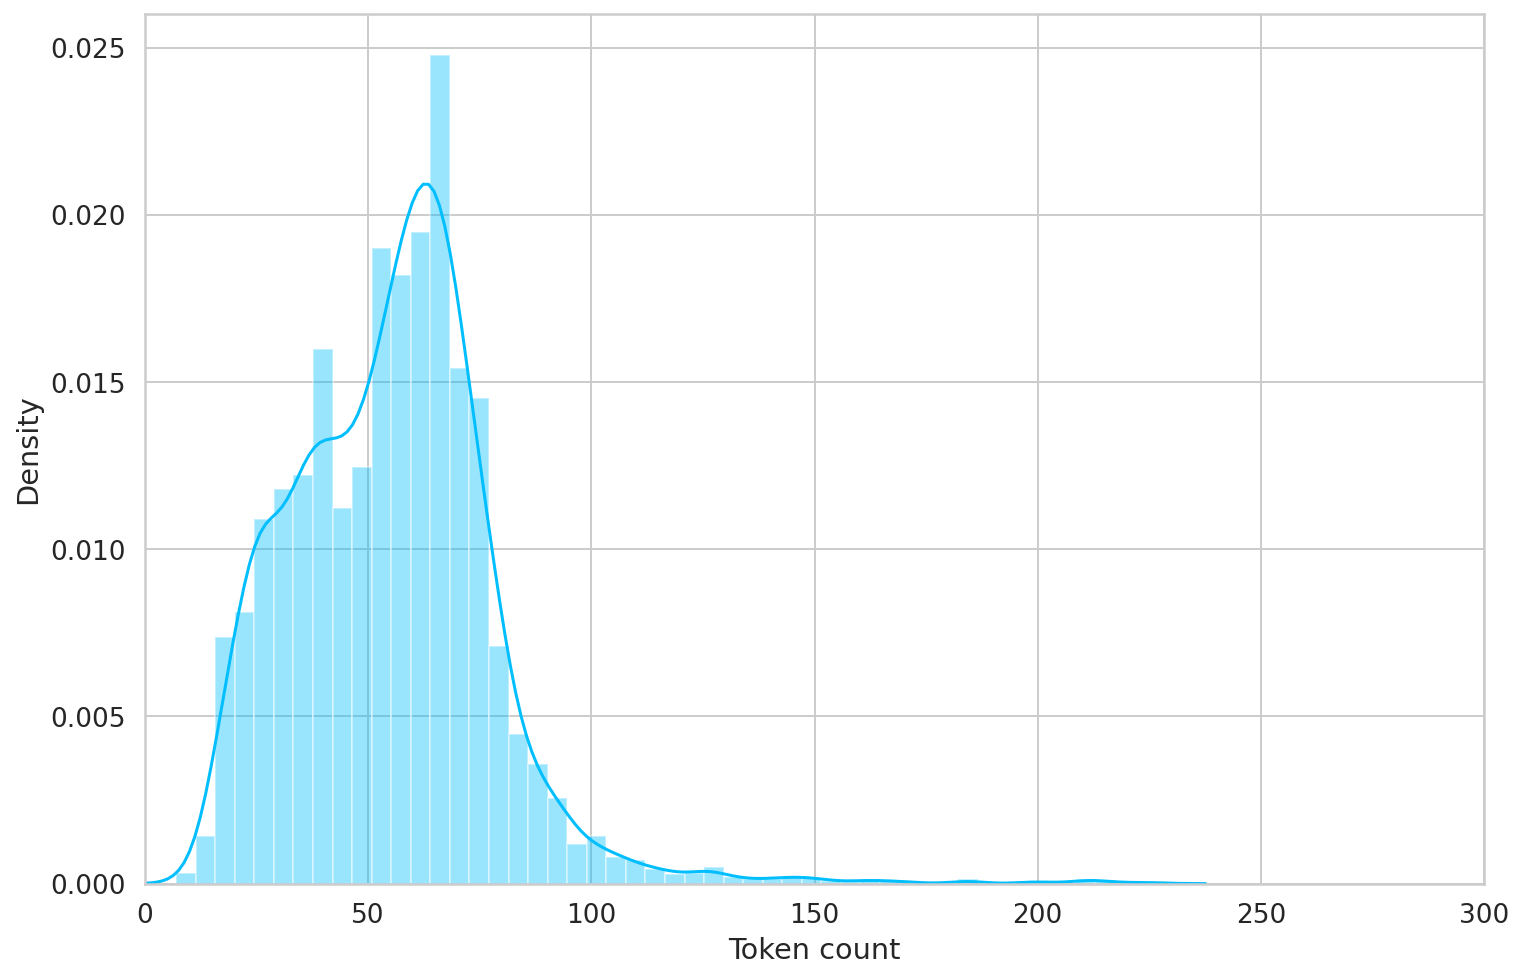

In [26]:
token_lens = []
for txt in tsla_policy.text_processed:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count');

In [10]:
nasdaq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28292 entries, 0 to 28291
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             28292 non-null  int64 
 1   date                   28292 non-null  object
 2   place                  17 non-null     object
 3   username               28292 non-null  object
 4   name                   28290 non-null  object
 5   tweet                  28292 non-null  object
 6   nlikes                 28292 non-null  int64 
 7   nreplies               28292 non-null  int64 
 8   nretweets              28292 non-null  int64 
 9   retweet                28292 non-null  bool  
 10  text_processed         28292 non-null  object
 11  text_processed_notags  28279 non-null  object
dtypes: bool(1), int64(4), object(7)
memory usage: 2.4+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


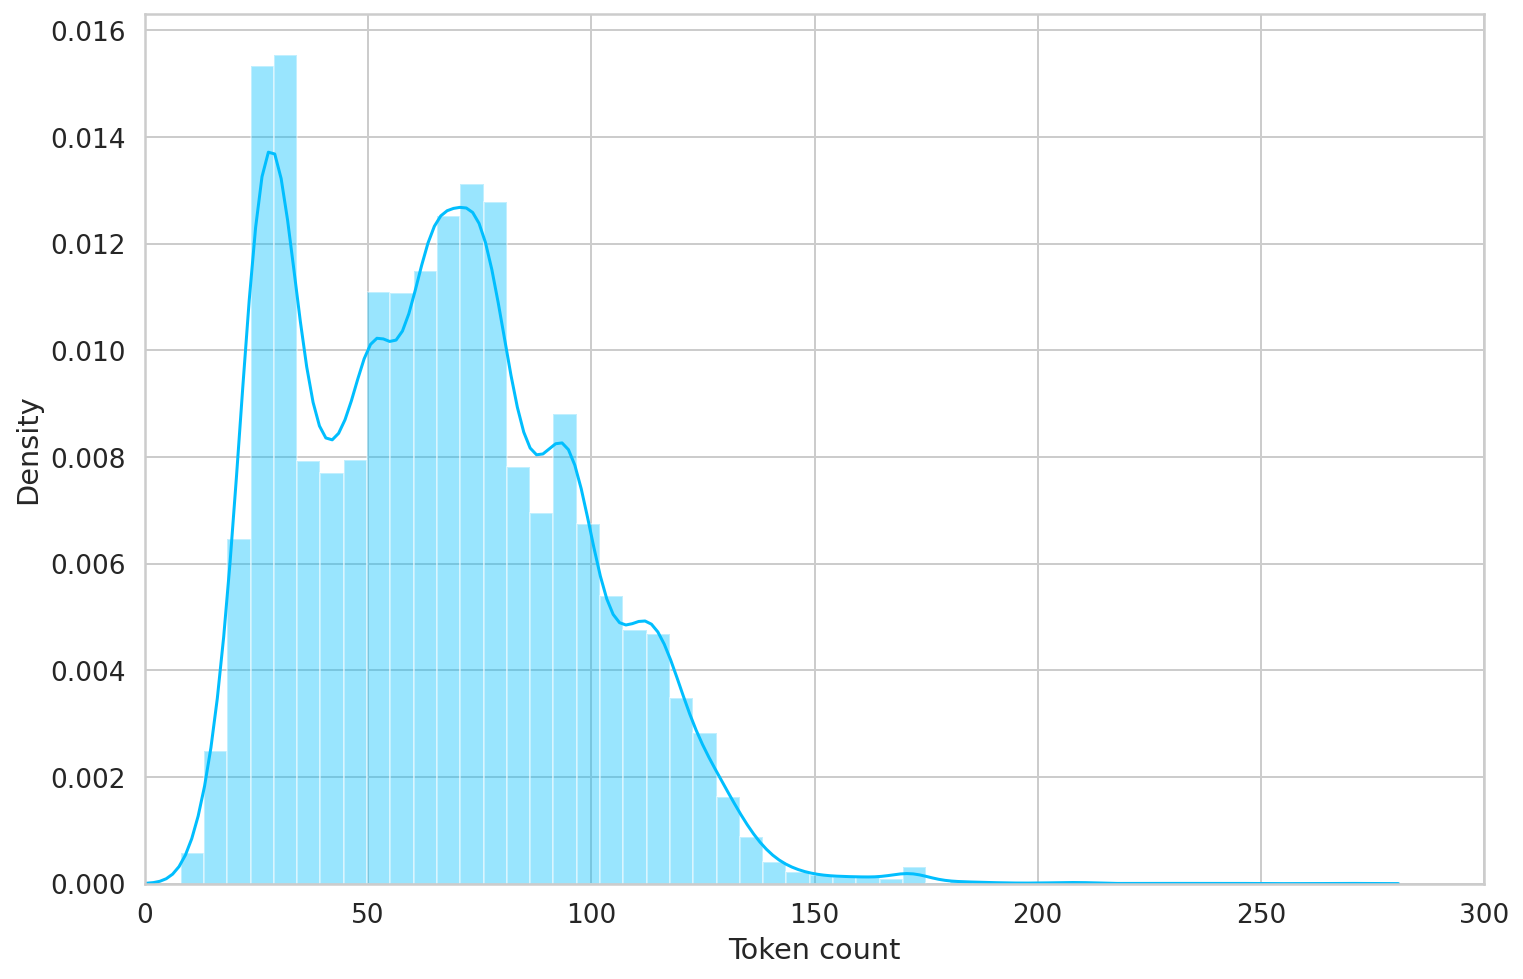

In [28]:
token_lens = []
for txt in nasdaq.text_processed:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 300]);
plt.xlabel('Token count');

In [ ]:
elonmusk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4838 entries, 0 to 4837
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             4838 non-null   int64  
 1   date                   4838 non-null   object 
 2   place                  0 non-null      float64
 3   username               4838 non-null   object 
 4   name                   4838 non-null   object 
 5   tweet                  4838 non-null   object 
 6   nlikes                 4838 non-null   int64  
 7   nreplies               4838 non-null   int64  
 8   nretweets              4838 non-null   int64  
 9   retweet                4838 non-null   bool   
 10  text_processed         4838 non-null   object 
 11  text_processed_notags  4746 non-null   object 
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 458.3+ KB


Tokenize data

In [34]:
MAX_LEN = 200
BATCH_SIZE = 16

In [41]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", truncation=True)
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [44]:
# create pytorch dataset
class PredictionDataset(Dataset):
  def __init__(self, tweets, tokenizer, max_len):
    self.tweets = tweets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])

    encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=True,
        # pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        padding='max_length',
        truncation=True

    )
    return {
        'tweet':tweet,
        'input_ids':torch.tensor(encoding['input_ids']).flatten(),
        'attention_mask': encoding['attention_mask'].flatten()
    }

In [48]:
def create_tweet_loader(df, text, tokenizer, max_len, batch_size):
  ds = PredictionDataset(
    tweets=df[text].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [53]:
def predict(model, data_loader, device):
  model = model.eval()
  
  review_tweets = []
  predictions = []
  prediction_probs = []

  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweet"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs.logits, dim=1)

      probs = F.softmax(outputs.logits, dim=1)

      review_tweets.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  return review_tweets, predictions, prediction_probs

In [1]:
ford_data_loader = create_tweet_loader(ford, 'text_processed', tokenizer, MAX_LEN, BATCH_SIZE)
lucid_data_loader = create_tweet_loader(lucid, 'text_processed', tokenizer, MAX_LEN, BATCH_SIZE)
nasdaq_data_loader = create_tweet_loader(nasdaq, 'text_processed',tokenizer, MAX_LEN, BATCH_SIZE)
tsla_policy_data_loader = create_tweet_loader(tsla_policy, 'text_processed',tokenizer, MAX_LEN, BATCH_SIZE)

NameError: ignored

In [55]:
y_review_texts_ford, y_pred_ford, y_pred_probs_ford = predict(
  model.to(device),
  ford_data_loader,
  device
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [59]:
y_review_texts_lucid, y_pred_lucid, y_pred_probs_lucid = predict(
  model.to(device),
  lucid_data_loader,
  device
)

y_review_texts_nasdaq, y_pred_nasdaq, y_pred_probs_nasdaq = predict(
  model.to(device),
  nasdaq_data_loader,
  device
)

y_review_texts_tsla_policy, y_pred_tsla_policy, y_pred_probs_tsla_policy = predict(
  model.to(device),
  tsla_policy_data_loader,
  device
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

In [71]:
y_pred_probs_lucid.numpy()[:, 1]

array([0.34976247, 0.17455275, 0.27238637, ..., 0.1189343 , 0.9140038 ,
       0.40701923], dtype=float32)

In [72]:
y_pred_probs_lucid.numpy()

array([[0.05123185, 0.34976247, 0.5990057 ],
       [0.10927884, 0.17455275, 0.7161684 ],
       [0.68716955, 0.27238637, 0.04044404],
       ...,
       [0.00434367, 0.1189343 , 0.87672204],
       [0.01090405, 0.9140038 , 0.0750922 ],
       [0.00272169, 0.40701923, 0.59025913]], dtype=float32)

# Predict the TSLA trend

In [73]:
ford['sentiment_label'] = y_pred_ford
ford['sentiment_neg'] = y_pred_probs_ford.numpy()[:, 0]
ford['sentiment_neu'] = y_pred_probs_ford.numpy()[:, 1]
ford['sentiment_pos'] = y_pred_probs_ford.numpy()[:, 2]

nasdaq['sentiment_label'] = y_pred_nasdaq
nasdaq['sentiment_neg'] = y_pred_probs_nasdaq.numpy()[:, 0]
nasdaq['sentiment_neu'] = y_pred_probs_nasdaq.numpy()[:, 1]
nasdaq['sentiment_pos'] = y_pred_probs_nasdaq.numpy()[:, 2]

lucid['sentiment_label'] = y_pred_lucid
lucid['sentiment_neg'] = y_pred_probs_lucid.numpy()[:, 0]
lucid['sentiment_neu'] = y_pred_probs_lucid.numpy()[:, 1]
lucid['sentiment_pos'] = y_pred_probs_lucid.numpy()[:, 2]

tsla_policy['sentiment_label'] = y_pred_tsla_policy
tsla_policy['sentiment_neg'] = y_pred_probs_tsla_policy.numpy()[:, 0]
tsla_policy['sentiment_neu'] = y_pred_probs_tsla_policy.numpy()[:, 1]
tsla_policy['sentiment_pos'] = y_pred_probs_tsla_policy.numpy()[:, 2]

In [75]:
ford.drop(columns = ['Unnamed: 0', 'sentiment_prob'], inplace=True)
lucid.drop(columns = ['Unnamed: 0', 'sentiment_prob'], inplace=True)
nasdaq.drop(columns = ['Unnamed: 0', 'sentiment_prob'], inplace=True)
tsla_policy.drop(columns = ['Unnamed: 0', 'sentiment_prob'], inplace=True)

In [76]:
ford.to_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/ford.csv', index=False)
lucid.to_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/lucid.csv', index=False)
nasdaq.to_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/nasdaq.csv', index=False)
tsla_policy.to_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/tsla_policy.csv', index=False)

In [41]:
tsla_policy = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/tsla_policy.csv', lineterminator='\n')
nasdaq = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/nasdaq.csv', lineterminator='\n')
lucid = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/lucid.csv', lineterminator='\n')
ford = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/ford.csv', lineterminator='\n')

In [9]:
ford['sentiment_label'] -= 1
lucid['sentiment_label'] -= 1
nasdaq['sentiment_label'] -= 1
tsla_policy['sentiment_label'] -= 1

In [64]:
# add 2 so during log transformation weights will not be 0
ford['weights'] = ford['nreplies'] + ford['nretweets'] + ford['nlikes'] + 2
lucid['weights'] = lucid['nreplies'] + lucid['nretweets'] + lucid['nlikes'] + 2
nasdaq['weights'] = nasdaq['nreplies'] + nasdaq['nretweets'] + nasdaq['nlikes'] + 2
tsla_policy['weights'] = tsla_policy['nreplies'] + tsla_policy['nretweets'] + tsla_policy['nlikes'] + 2

In [68]:
ford['weights_log'] = np.log(ford['weights'])
lucid['weights_log'] = np.log(lucid['weights'])
nasdaq['weights_log'] = np.log(nasdaq['weights'])
tsla_policy['weights_log'] = np.log(tsla_policy['weights'])

In [69]:
ford['weighted_label'] = ford['weights'] * ford['sentiment_label']
ford['weighted_neg'] = ford['weights'] * ford['sentiment_neg']
ford['weighted_neu'] = ford['weights'] * ford['sentiment_neu']
ford['weighted_pos'] = ford['weights'] * ford['sentiment_pos']

lucid['weighted_label'] = lucid['weights'] * lucid['sentiment_label']
lucid['weighted_neg'] = lucid['weights'] * lucid['sentiment_neg']
lucid['weighted_neu'] = lucid['weights'] * lucid['sentiment_neu']
lucid['weighted_pos'] = lucid['weights'] * lucid['sentiment_pos']

nasdaq['weighted_label'] = nasdaq['weights'] * nasdaq['sentiment_label']
nasdaq['weighted_neg'] = nasdaq['weights'] * nasdaq['sentiment_neg']
nasdaq['weighted_neu'] = nasdaq['weights'] * nasdaq['sentiment_neu']
nasdaq['weighted_pos'] = nasdaq['weights'] * nasdaq['sentiment_pos']

tsla_policy['weighted_label'] = tsla_policy['weights'] * tsla_policy['sentiment_label']
tsla_policy['weighted_neg'] = tsla_policy['weights'] * tsla_policy['sentiment_neg']
tsla_policy['weighted_neu'] = tsla_policy['weights'] * tsla_policy['sentiment_neu']
tsla_policy['weighted_pos'] = tsla_policy['weights'] * tsla_policy['sentiment_pos']

In [70]:
ford['weighted_label_log'] = ford['weights_log'] * ford['sentiment_label']
ford['weighted_neg_log'] = ford['weights_log'] * ford['sentiment_neg']
ford['weighted_neu_log'] = ford['weights_log'] * ford['sentiment_neu']
ford['weighted_pos_log'] = ford['weights_log'] * ford['sentiment_pos']

lucid['weighted_label_log'] = lucid['weights_log'] * lucid['sentiment_label']
lucid['weighted_neg_log'] = lucid['weights_log'] * lucid['sentiment_neg']
lucid['weighted_neu_log'] = lucid['weights_log'] * lucid['sentiment_neu']
lucid['weighted_pos_log'] = lucid['weights_log'] * lucid['sentiment_pos']

nasdaq['weighted_label_log'] = nasdaq['weights_log'] * nasdaq['sentiment_label']
nasdaq['weighted_neg_log'] = nasdaq['weights_log'] * nasdaq['sentiment_neg']
nasdaq['weighted_neu_log'] = nasdaq['weights_log'] * nasdaq['sentiment_neu']
nasdaq['weighted_pos_log'] = nasdaq['weights_log'] * nasdaq['sentiment_pos']

tsla_policy['weighted_label_log'] = tsla_policy['weights_log'] * tsla_policy['sentiment_label']
tsla_policy['weighted_neg_log'] = tsla_policy['weights_log'] * tsla_policy['sentiment_neg']
tsla_policy['weighted_neu_log'] = tsla_policy['weights_log'] * tsla_policy['sentiment_neu']
tsla_policy['weighted_pos_log'] = tsla_policy['weights_log'] * tsla_policy['sentiment_pos']

In [57]:
ford['score'] = ford['sentiment_pos'] - ford['sentiment_neg'] * (1 - ford['sentiment_neu'])
lucid['score'] = lucid['sentiment_pos'] - lucid['sentiment_neg'] * (1 - lucid['sentiment_neu'])
nasdaq['score'] = nasdaq['sentiment_pos'] - nasdaq['sentiment_neg'] * (1 - nasdaq['sentiment_neu'])
tsla_policy['score'] = tsla_policy['sentiment_pos'] - tsla_policy['sentiment_neg'] * (1 - tsla_policy['sentiment_neu'])

In [71]:
ford['wa_score'] = ford['weights_log'] * ford['score']
lucid['wa_score'] = lucid['weights_log'] * lucid['score']
nasdaq['wa_score'] = nasdaq['weights_log'] * nasdaq['score']
tsla_policy['wa_score'] = tsla_policy['weights_log'] * tsla_policy['score']

In [72]:
ford.describe()

,nlikes,nreplies,nretweets,sentiment_label,sentiment_neg,sentiment_neu,sentiment_pos,weights,weights_log,weighted_label,weighted_neg,weighted_neu,weighted_pos,weighted_label_log,weighted_neg_log,weighted_neu_log,weighted_pos_log,score,wa_score
count,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000,4271.000000
mean,5.402248,0.726294,0.486537,0.196675,0.161154,0.468095,0.370751,8.615078,1.403780,2.441817,1.239174,3.576541,3.799364,0.304343,0.213475,0.656120,0.534185,0.270000,0.402356
std,30.591686,2.542244,2.591238,0.671395,0.249851,0.308628,0.357216,34.962513,0.876899,32.584753,7.189813,10.631544,28.707787,1.129578,0.399029,0.649689,0.717267,0.477977,0.844153
min,0.000000,0.000000,0.000000,-1.000000,0.000586,0.005259,0.002428,2.000000,0.693147,-278.000000,0.001259,0.010573,0.004856,-5.627621,0.000436,0.003664,0.001683,-0.964409,-3.347448
25%,0.000000,0.000000,0.000000,0.000000,0.004491,0.170058,0.060358,2.000000,0.693147,0.000000,0.017893,0.588197,0.210899,0.000000,0.005572,0.187498,0.071090,0.024071,0.022822
50%,1.000000,0.000000,0.000000,0.000000,0.029699,0.475456,0.197689,3.000000,1.098612,0.000000,0.124258,1.519688,0.836343,0.000000,0.035360,0.511003,0.247065,0.161125,0.200791
75%,2.000000,1.000000,0.000000,1.000000,0.206879,0.762987,0.724637,5.000000,1.609438,2.000000,0.836735,2.653303,2.254891,0.693147,0.249663,0.886724,0.684415,0.712907,0.681255
max,1412.000000,62.000000,121.000000,1.000000,0.982065,0.952289,0.993456,1597.000000,7.375882,1597.000000,206.452708,228.085788,1488.041162,7.375882,4.333564,4.590055,6.872646,0.992217,6.836279


In [84]:
ford['weights'].describe()

count    4271.000000
mean        8.615078
std        34.962513
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max      1597.000000
Name: weights, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


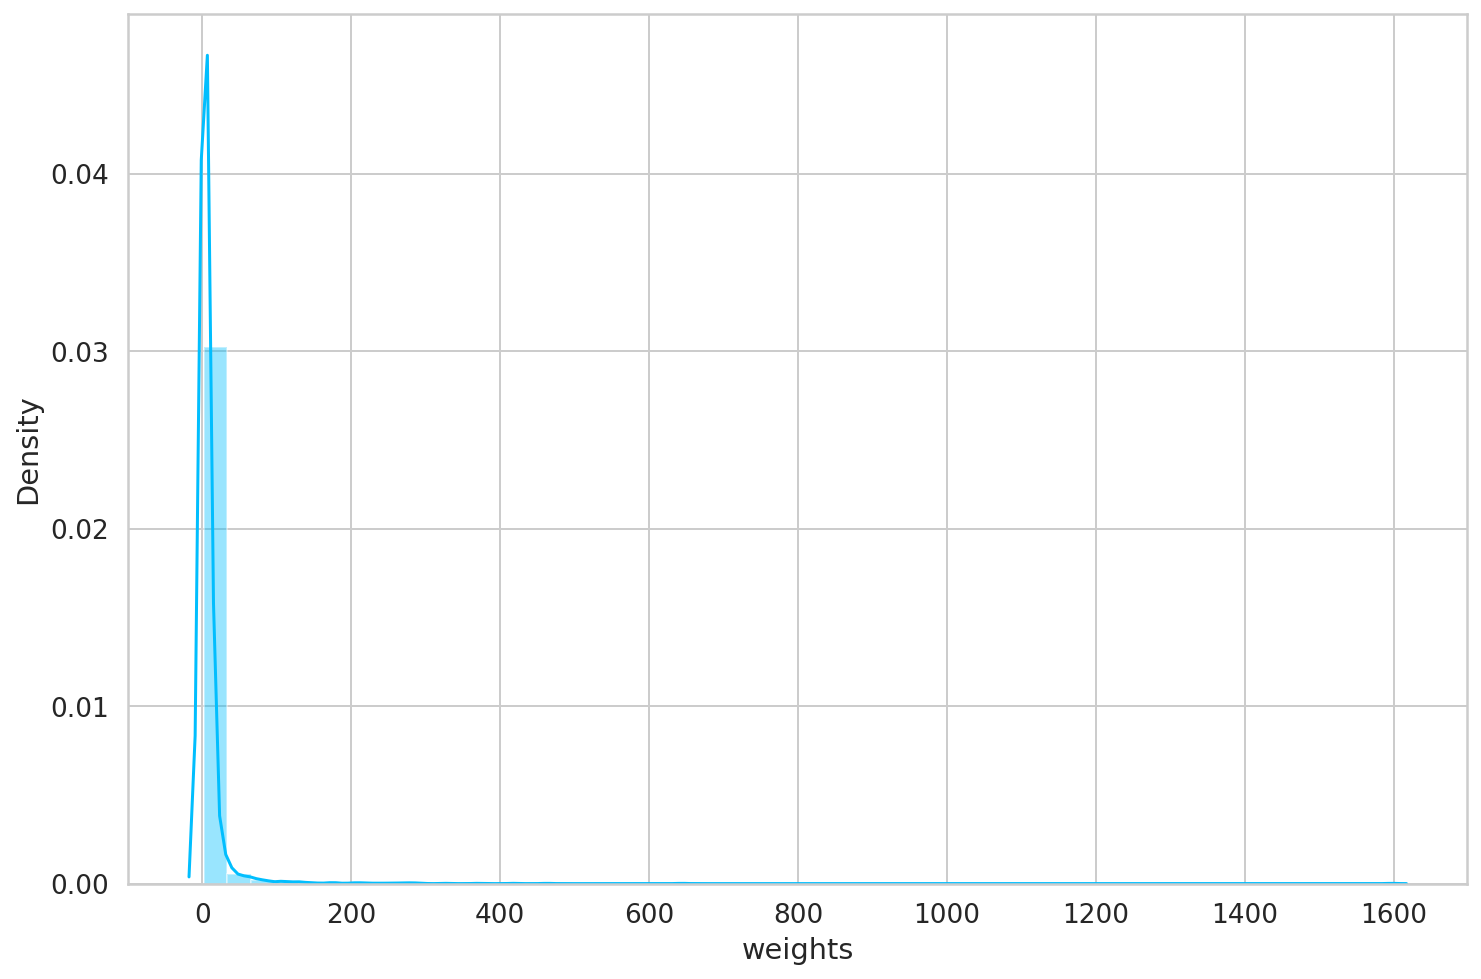

In [83]:
sns.distplot(ford['weights'])
#plt.xlim([0, 300]);
plt.xlabel('weights');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


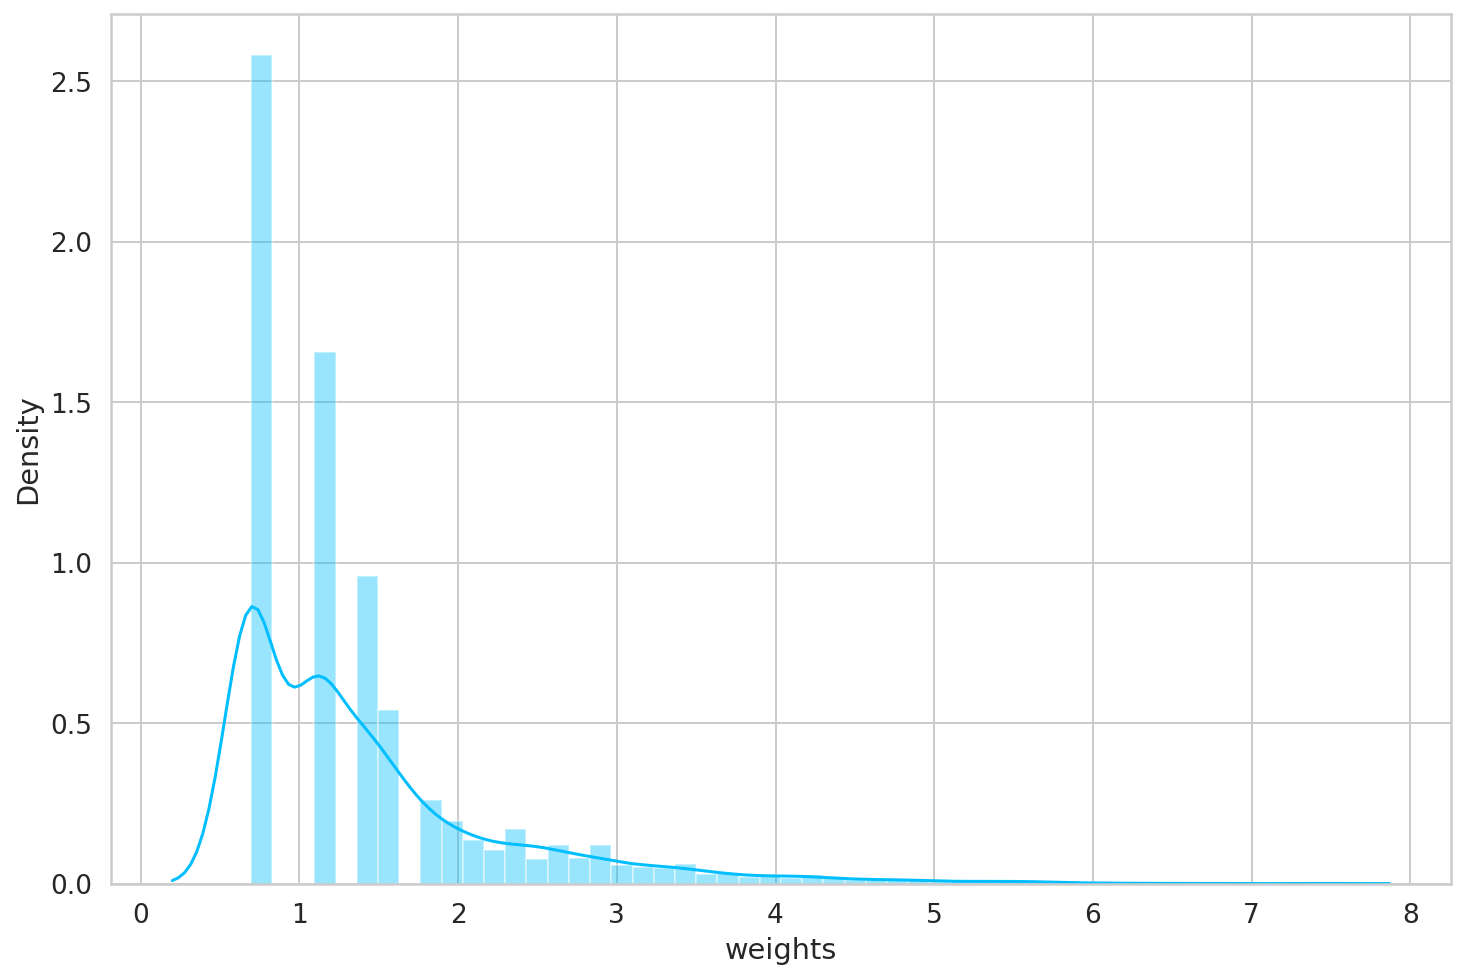

In [75]:
sns.distplot(ford['weights_log'])
#plt.xlim([0, 300]);
plt.xlabel('weights');

In [63]:
tsla_policy.describe()

,nlikes,nreplies,nretweets,sentiment_label,sentiment_neg,sentiment_neu,sentiment_pos,weights,weights_log,weighted_label,weighted_neg,weighted_neu,weighted_pos,weighted_label_log,weighted_neg_log,weighted_neu_log,weighted_pos_log,score,wa_score
count,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000,6600.000000
mean,7.354697,0.815758,1.511970,-0.121970,0.310801,0.460069,0.229131,10.682424,0.922621,0.743939,2.956943,4.464661,3.260820,-0.076251,0.281876,0.407864,0.232881,0.029422,0.050607
std,66.371763,3.753747,15.328178,0.690772,0.286406,0.228806,0.265661,81.692101,1.127989,74.737469,22.753712,26.777077,55.598877,1.049781,0.533132,0.593763,0.521445,0.443383,0.689837
min,0.000000,0.000000,0.000000,-1.000000,0.000685,0.007375,0.002205,1.000000,0.000000,-1204.000000,0.000703,0.007375,0.002205,-7.093405,0.000000,0.000000,0.000000,-0.955790,-6.418614
25%,0.000000,0.000000,0.000000,-1.000000,0.041591,0.290395,0.039552,1.000000,0.000000,-1.000000,0.093389,0.464947,0.076484,0.000000,0.000000,0.000000,0.000000,-0.262433,-0.065549
50%,0.000000,0.000000,0.000000,0.000000,0.229662,0.463614,0.104367,2.000000,0.693147,0.000000,0.443555,0.818489,0.235432,0.000000,0.025102,0.224455,0.033082,0.029988,0.000000
75%,2.000000,1.000000,0.000000,0.000000,0.533871,0.623418,0.332491,4.000000,1.386294,0.000000,1.187398,1.685497,0.849085,0.000000,0.376172,0.567300,0.205433,0.288973,0.111210
max,3610.000000,114.000000,764.000000,1.000000,0.977674,0.943759,0.991297,4489.000000,8.409385,4489.000000,949.941973,723.596608,3767.398457,8.409385,6.586974,5.495149,7.057586,0.990396,7.048236


In [56]:
tsla_policy[['nlikes', 'nreplies','nretweets', 'sentiment_label', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos']].head(3)

,nlikes,nreplies,nretweets,sentiment_label,sentiment_neg,sentiment_neu,sentiment_pos
0,2,1,0,1,0.017321,0.250309,0.732370
1,1,0,0,0,0.143110,0.584886,0.272003
2,0,0,0,-1,0.873769,0.115164,0.011067


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


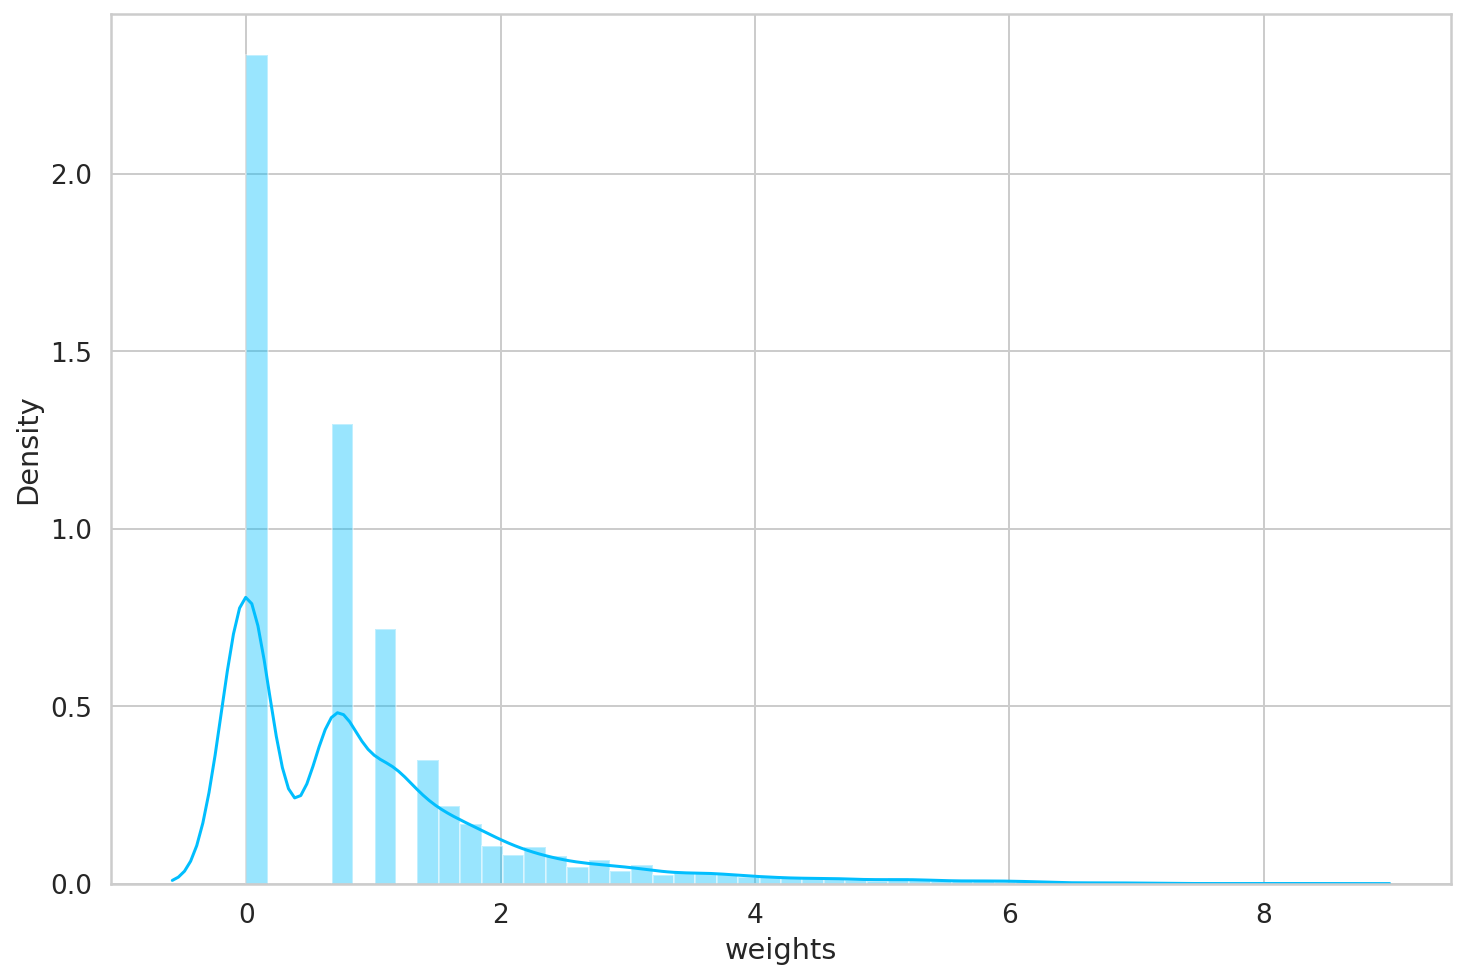

In [21]:
sns.distplot(tsla_policy['weights_log'])
plt.xlabel('weights');

In [76]:
ford['date'] = pd.to_datetime(ford['date']).dt.date
lucid['date'] = pd.to_datetime(lucid['date']).dt.date
nasdaq['date'] = pd.to_datetime(nasdaq['date']).dt.date
tsla_policy['date'] = pd.to_datetime(tsla_policy['date']).dt.date

In [77]:
ford_wa = ford.groupby('date')['weighted_label','weighted_neg','weighted_neu', 'weighted_pos', 'weighted_label_log','weighted_neg_log','weighted_neu_log', 'weighted_pos_log', 'wa_score'].mean().reset_index()
nasdaq_wa = nasdaq.groupby('date')['weighted_label','weighted_neg','weighted_neu', 'weighted_pos', 'weighted_label_log','weighted_neg_log','weighted_neu_log', 'weighted_pos_log', 'wa_score'].mean().reset_index()
lucid_wa = lucid.groupby('date')['weighted_label','weighted_neg','weighted_neu', 'weighted_pos', 'weighted_label_log','weighted_neg_log','weighted_neu_log', 'weighted_pos_log', 'wa_score'].mean().reset_index()
tsla_policy_wa = tsla_policy.groupby('date')['weighted_label','weighted_neg','weighted_neu', 'weighted_pos', 'weighted_label_log','weighted_neg_log','weighted_neu_log', 'weighted_pos_log', 'wa_score'].mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [78]:
ford_wa.describe()

,weighted_label,weighted_neg,weighted_neu,weighted_pos,weighted_label_log,weighted_neg_log,weighted_neu_log,weighted_pos_log,wa_score
count,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000
mean,2.396822,0.862753,3.829629,3.391189,0.353508,0.166787,0.702792,0.535010,0.437209
std,7.759345,1.936299,10.195782,7.489718,0.585894,0.176279,0.418122,0.430766,0.469143
min,-16.250000,0.001604,0.031089,0.022079,-1.609438,0.000556,0.010774,0.008085,-0.893107
25%,0.000000,0.118576,1.477599,0.878277,0.000000,0.030731,0.458585,0.276769,0.152153
50%,0.954167,0.399300,2.233059,1.608668,0.268240,0.116804,0.629121,0.451276,0.359583
75%,2.441667,0.837466,4.079039,3.038939,0.621227,0.243023,0.871152,0.666574,0.619922
max,108.733333,29.619065,228.085788,102.911213,4.133596,1.293781,4.590055,3.833845,3.824232


In [79]:
ford_wa.to_csv('/content/drive/MyDrive/twitter-sentiment-analysis/data/ford_wa.csv', index=False)
lucid_wa.to_csv('/content/drive/MyDrive/twitter-sentiment-analysis/data/lucid_wa.csv', index=False)
nasdaq_wa.to_csv('/content/drive/MyDrive/twitter-sentiment-analysis/data/nasdaq_wa.csv', index=False)
tsla_policy_wa.to_csv('/content/drive/MyDrive/twitter-sentiment-analysis/data/tsla_policy_wa.csv', index=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


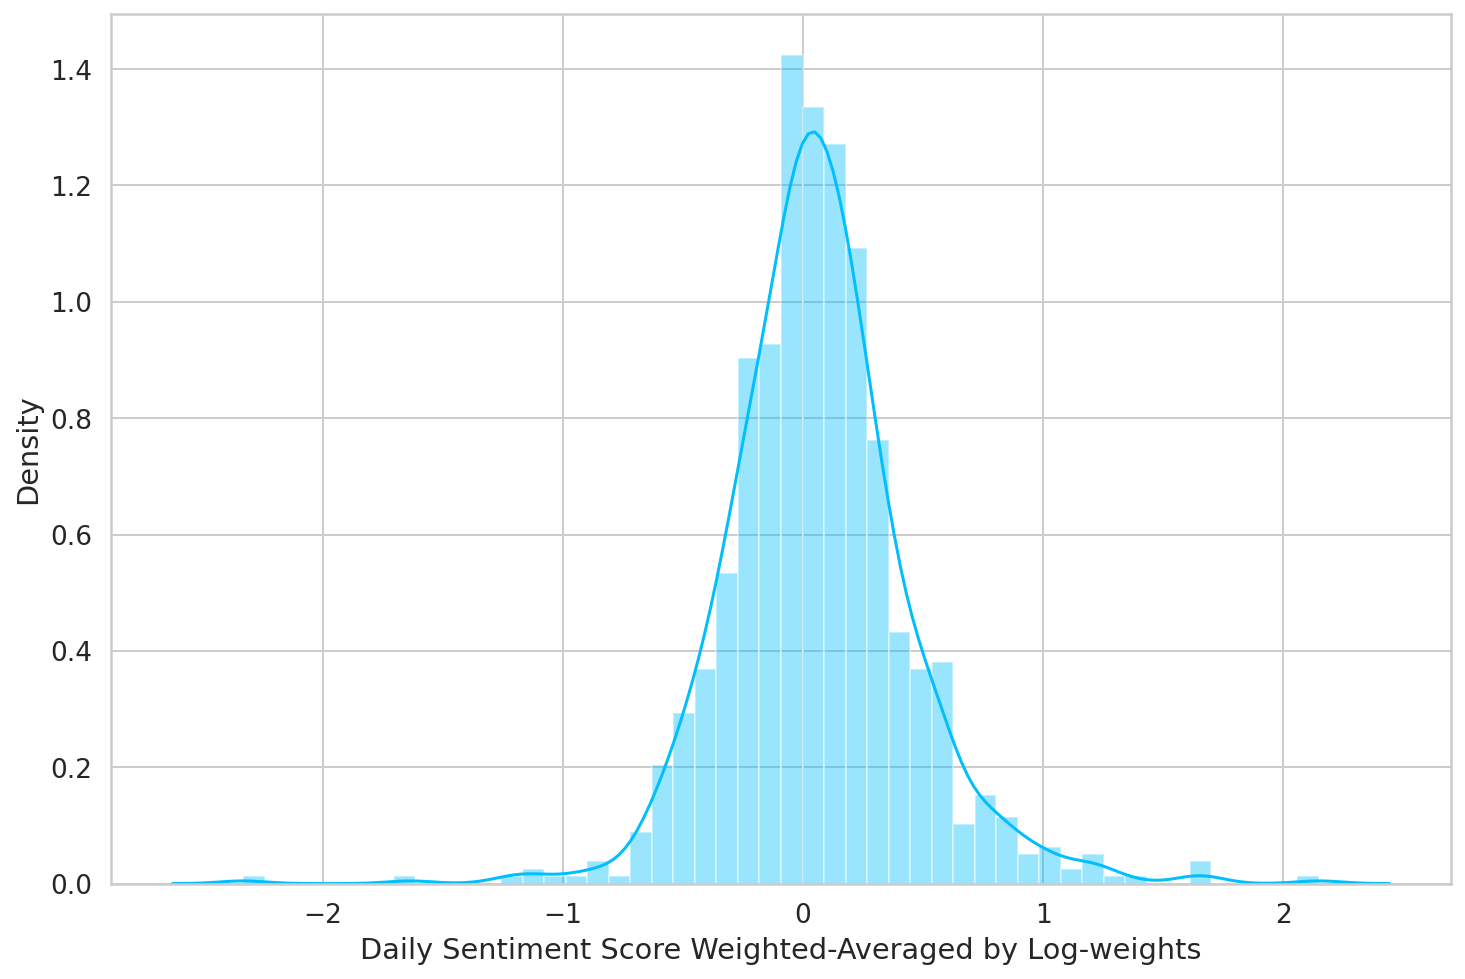

In [85]:
sns.distplot(tsla_policy_wa['wa_score'])
plt.xlabel('Daily Sentiment Score Weighted-Averaged by Log-weights');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


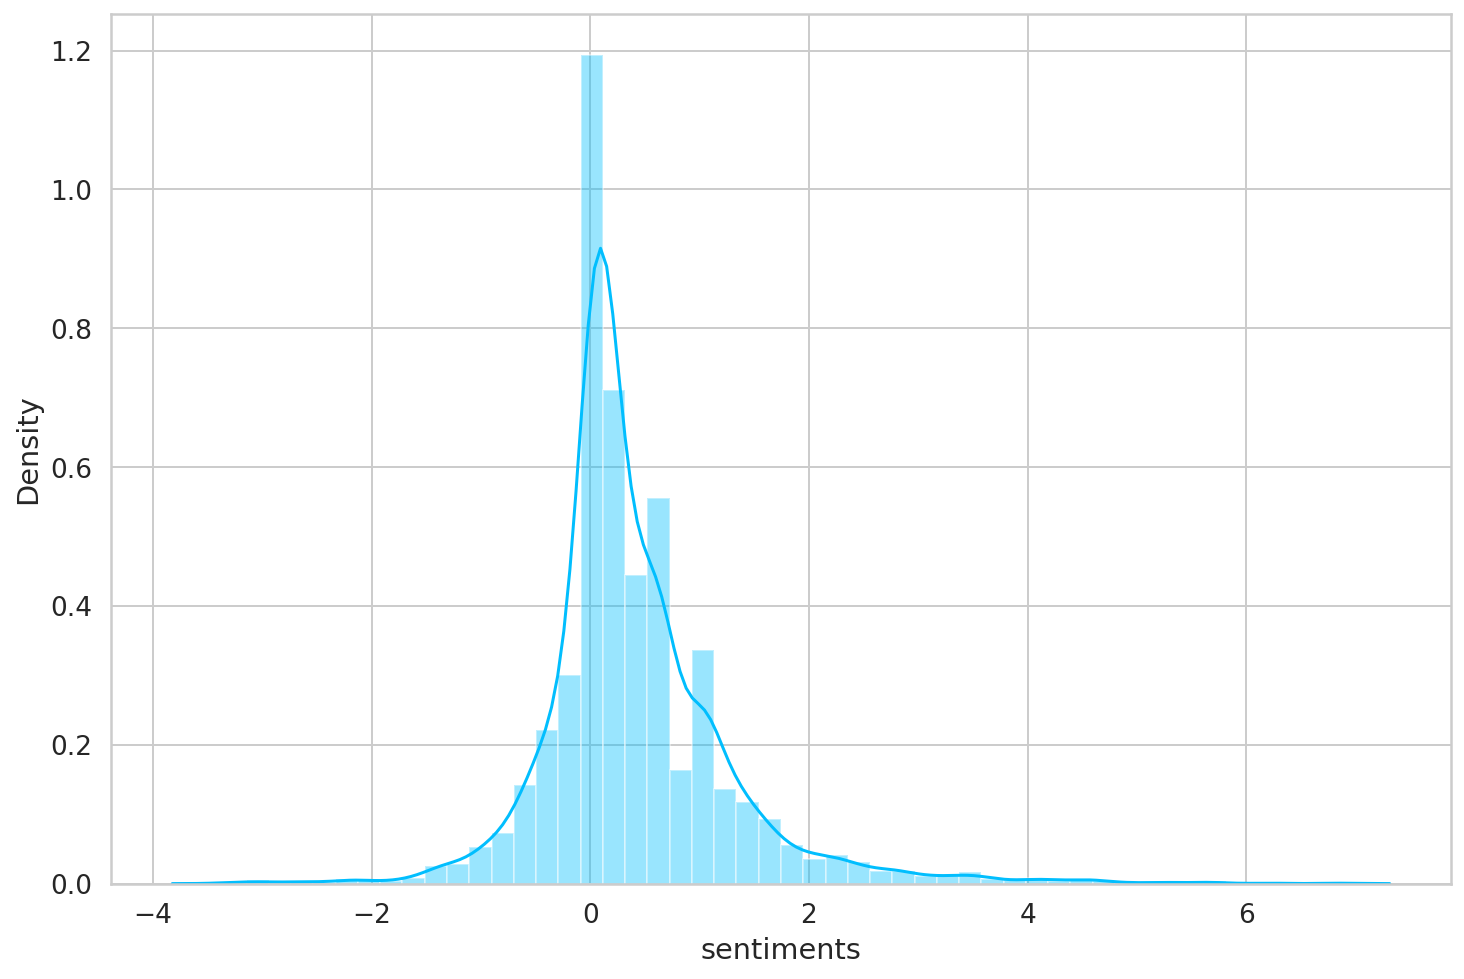

In [86]:
sns.distplot(ford['wa_score'])
plt.xlabel('sentiments');

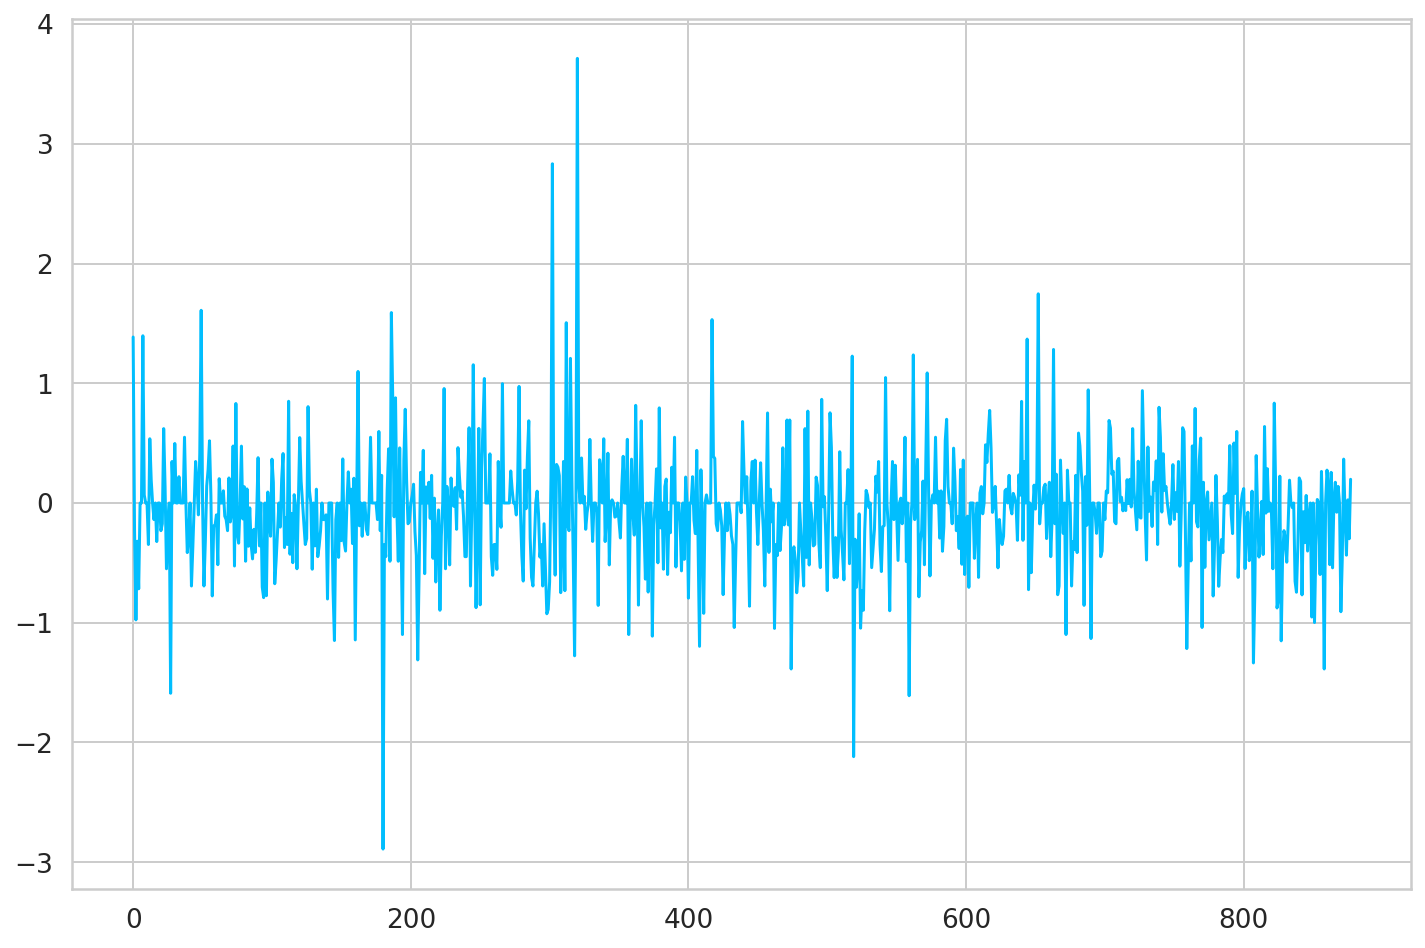

In [35]:
plt.plot(tsla_policy_wa['weighted_label_log'])

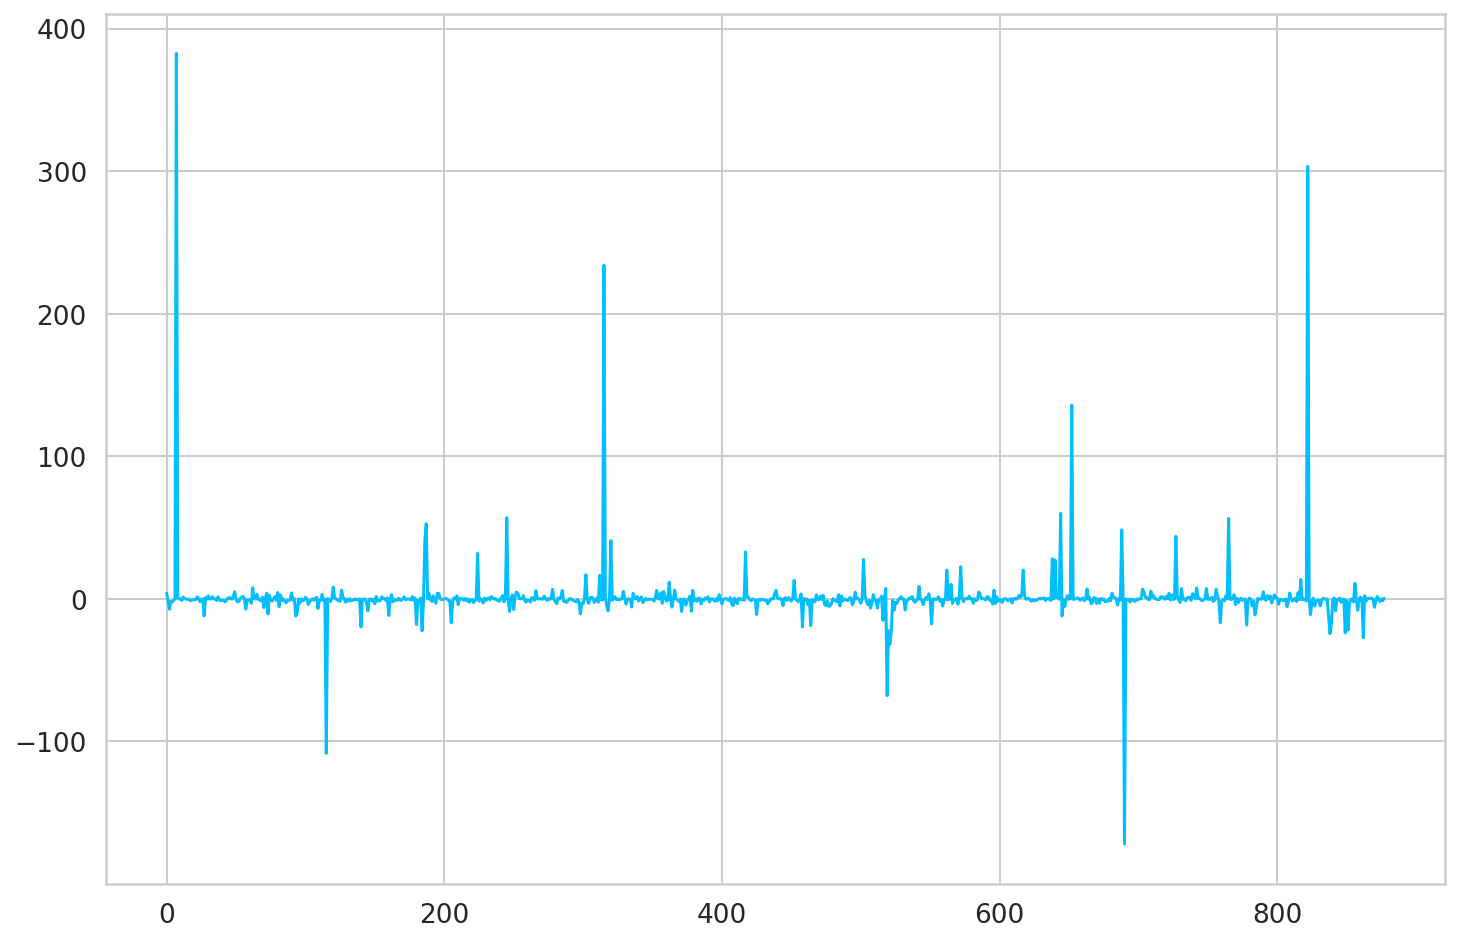

In [36]:
plt.plot(tsla_policy_wa['weighted_label'])

In [5]:
tsla_policy_wa = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/tsla_policy_wa.csv', lineterminator='\n')
nasdaq_wa = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/nasdaq_wa.csv', lineterminator='\n')
lucid_wa = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/lucid_wa.csv', lineterminator='\n')
ford_wa = pd.read_csv(r'/content/drive/MyDrive/twitter-sentiment-analysis/data/ford_wa.csv', lineterminator='\n')

In [ ]:
!pip install yahoo_fin

In [7]:
from yahoo_fin.stock_info import get_data

df = get_data(ticker='TSLA', start_date='2019-01-01', end_date='2021-06-30')

In [8]:
df.drop(columns=['ticker', 'open', 'high', 'low', 'close'],inplace=True)
df

,adjclose,volume
2019-01-02,62.023998,58293000
2019-01-03,60.071999,34826000
2019-01-04,63.537998,36970500
2019-01-07,66.991997,37756000
2019-01-08,67.070000,35042500
...,...,...
2021-06-23,656.570007,31099200
2021-06-24,679.820007,45982400
2021-06-25,671.869995,32496700
2021-06-28,688.719971,21628200


In [9]:
df['daily_return'] = df['adjclose'] -  df['adjclose'].shift(1)
df['date'] = df.index
df['daily_return_log'] = np.log(df['adjclose']) - np.log(df['adjclose'].shift(1))
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df

,adjclose,volume,daily_return,date,daily_return_log
0,60.071999,34826000,-1.952000,2019-01-03,-0.031978
1,63.537998,36970500,3.466000,2019-01-04,0.056094
2,66.991997,37756000,3.453999,2019-01-07,0.052935
3,67.070000,35042500,0.078003,2019-01-08,0.001164
4,67.706001,27164500,0.636002,2019-01-09,0.009438
...,...,...,...,...,...
622,656.570007,31099200,32.859985,2021-06-23,0.051344
623,679.820007,45982400,23.250000,2021-06-24,0.034799
624,671.869995,32496700,-7.950012,2021-06-25,-0.011763
625,688.719971,21628200,16.849976,2021-06-28,0.024770


8.481711362105683


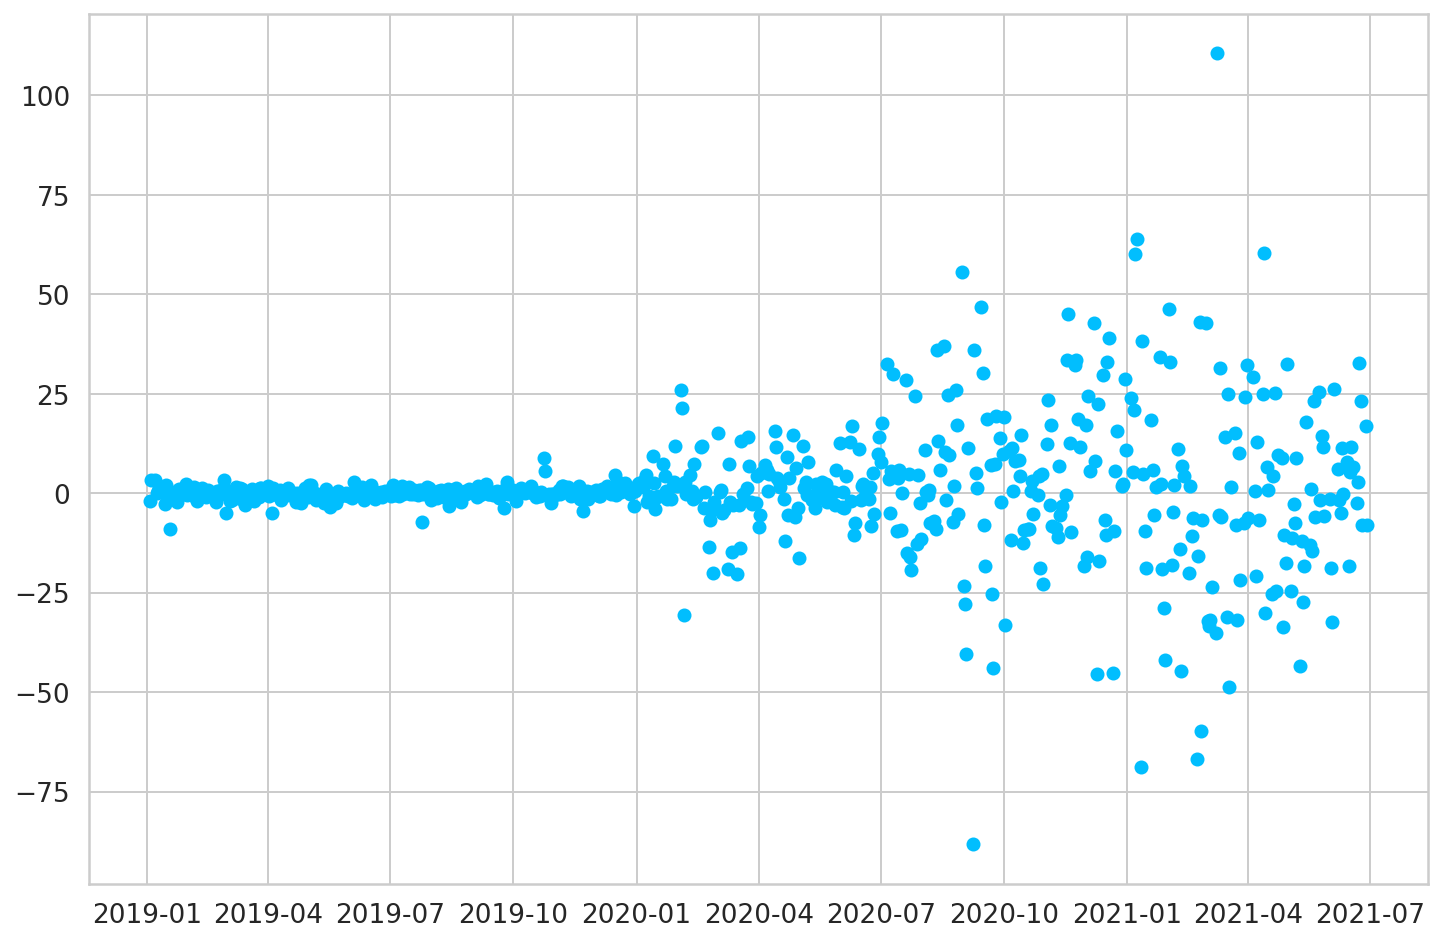

In [105]:
kurtosis = df['daily_return'].kurtosis()
print(kurtosis)
plt.scatter(df['date'], df['daily_return'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


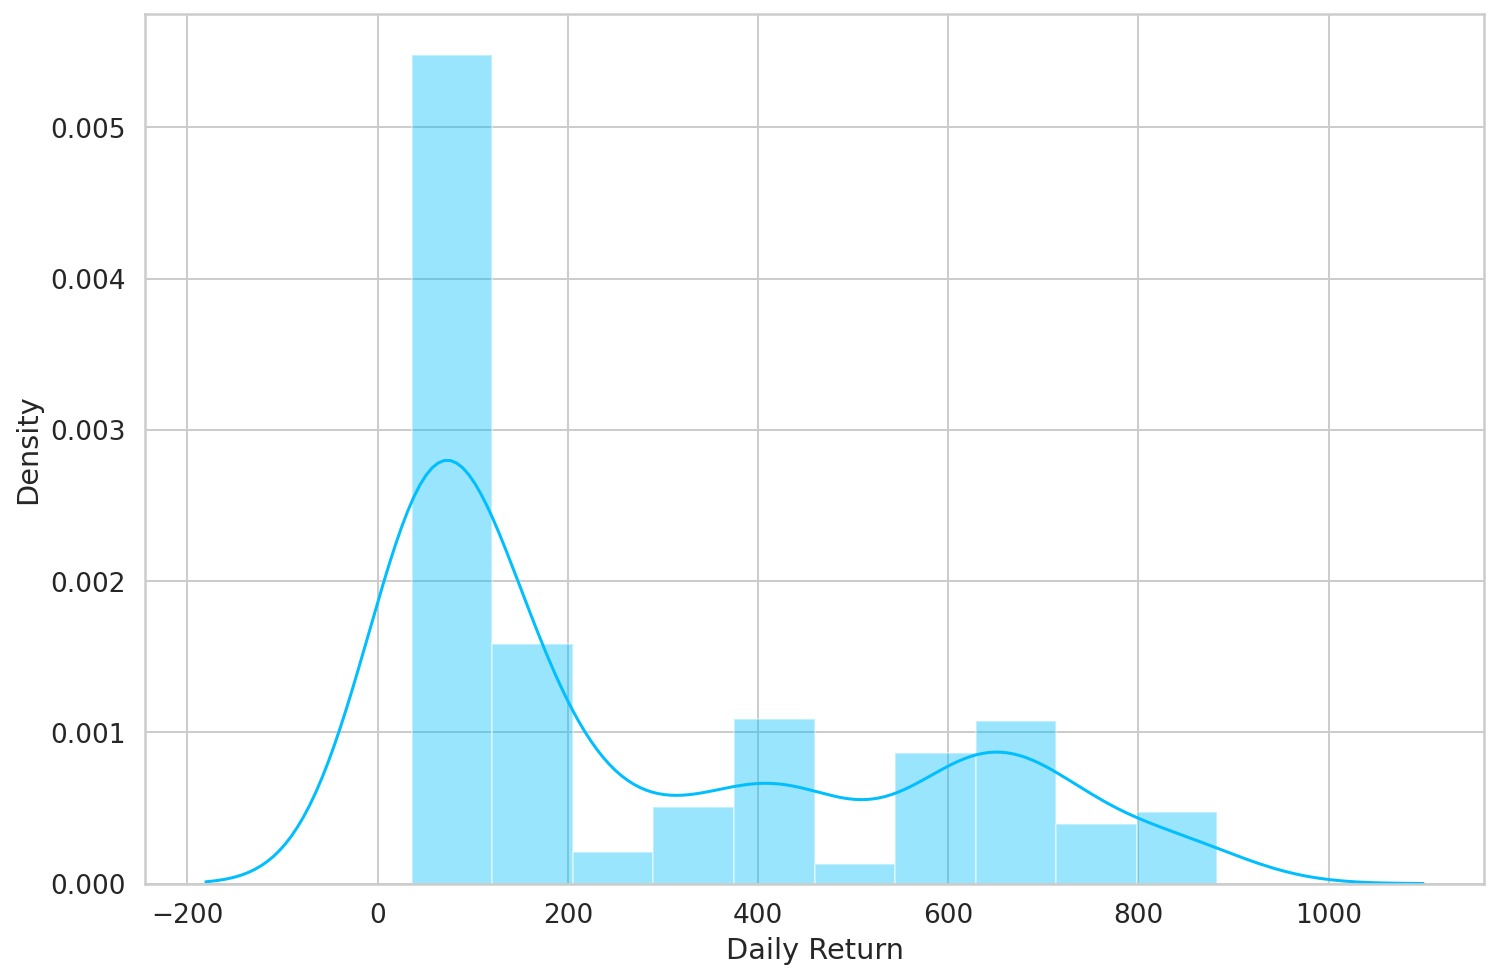

In [107]:
sns.distplot(df['adjclose'])
plt.xlabel('Daily Return');

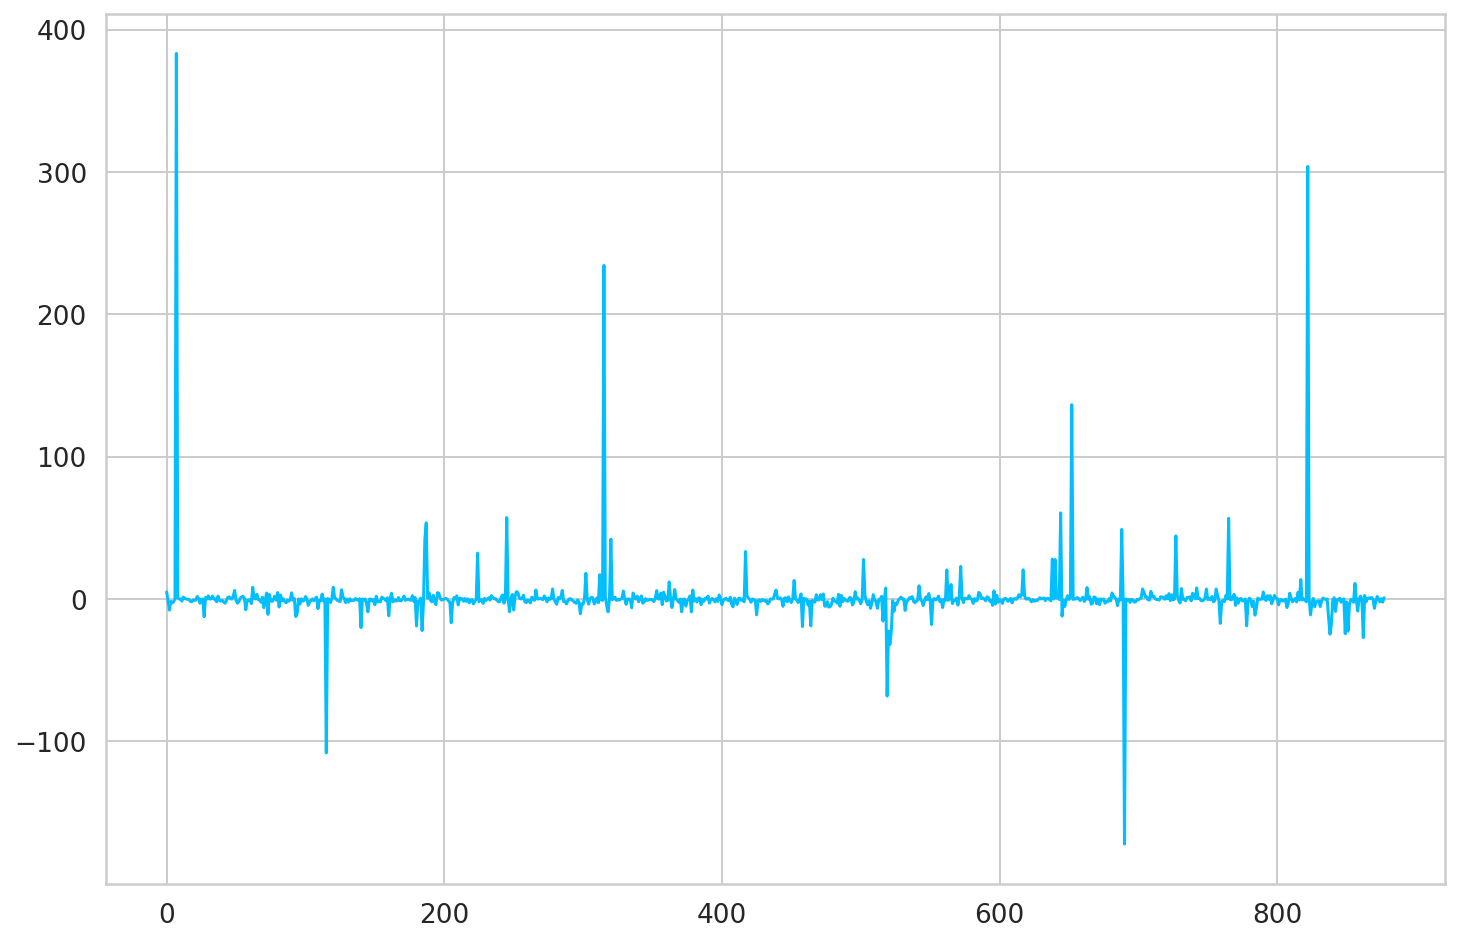

In [98]:
plt.plot(tsla_policy_wa['weighted_label'])

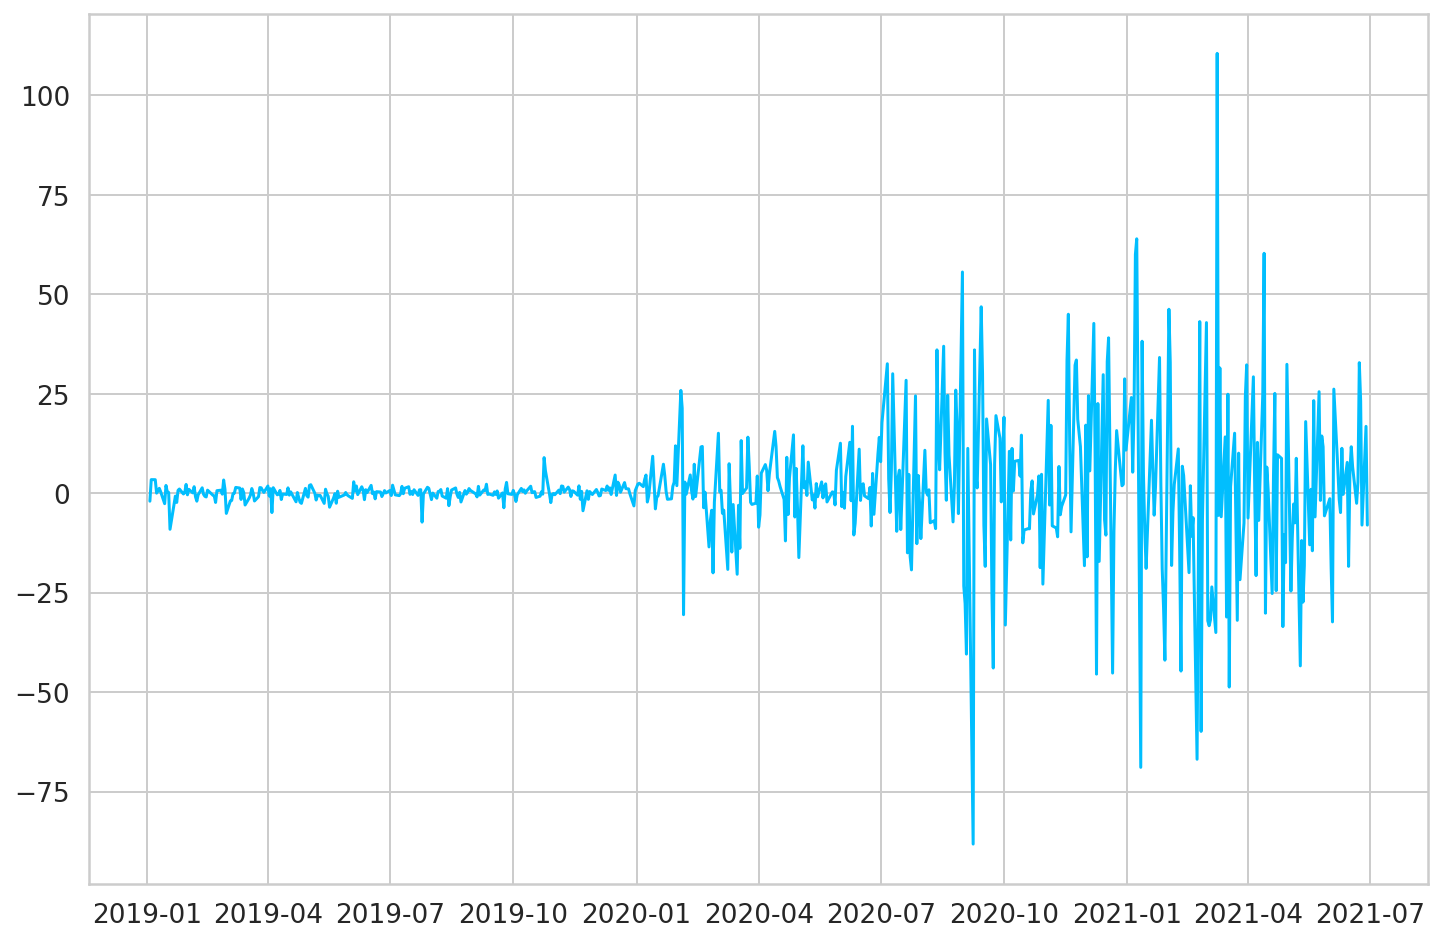

In [44]:
plt.plot(df['date'], df['daily_return'])

In [46]:
df['daily_return'].kurtosis()

8.481711362105683

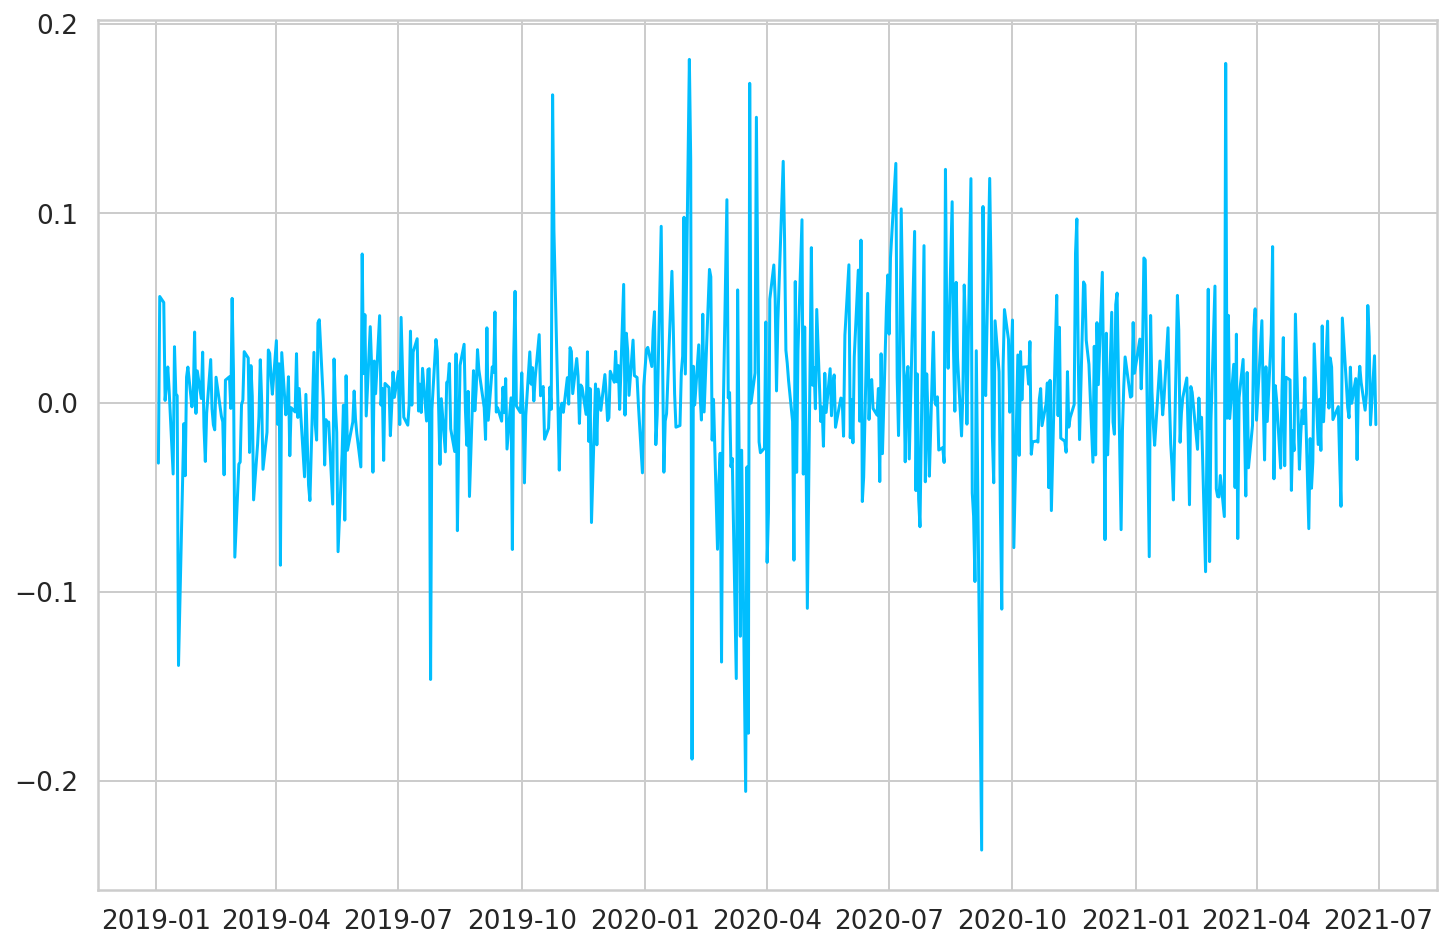

In [47]:
plt.plot(df['date'], df['daily_return_log'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


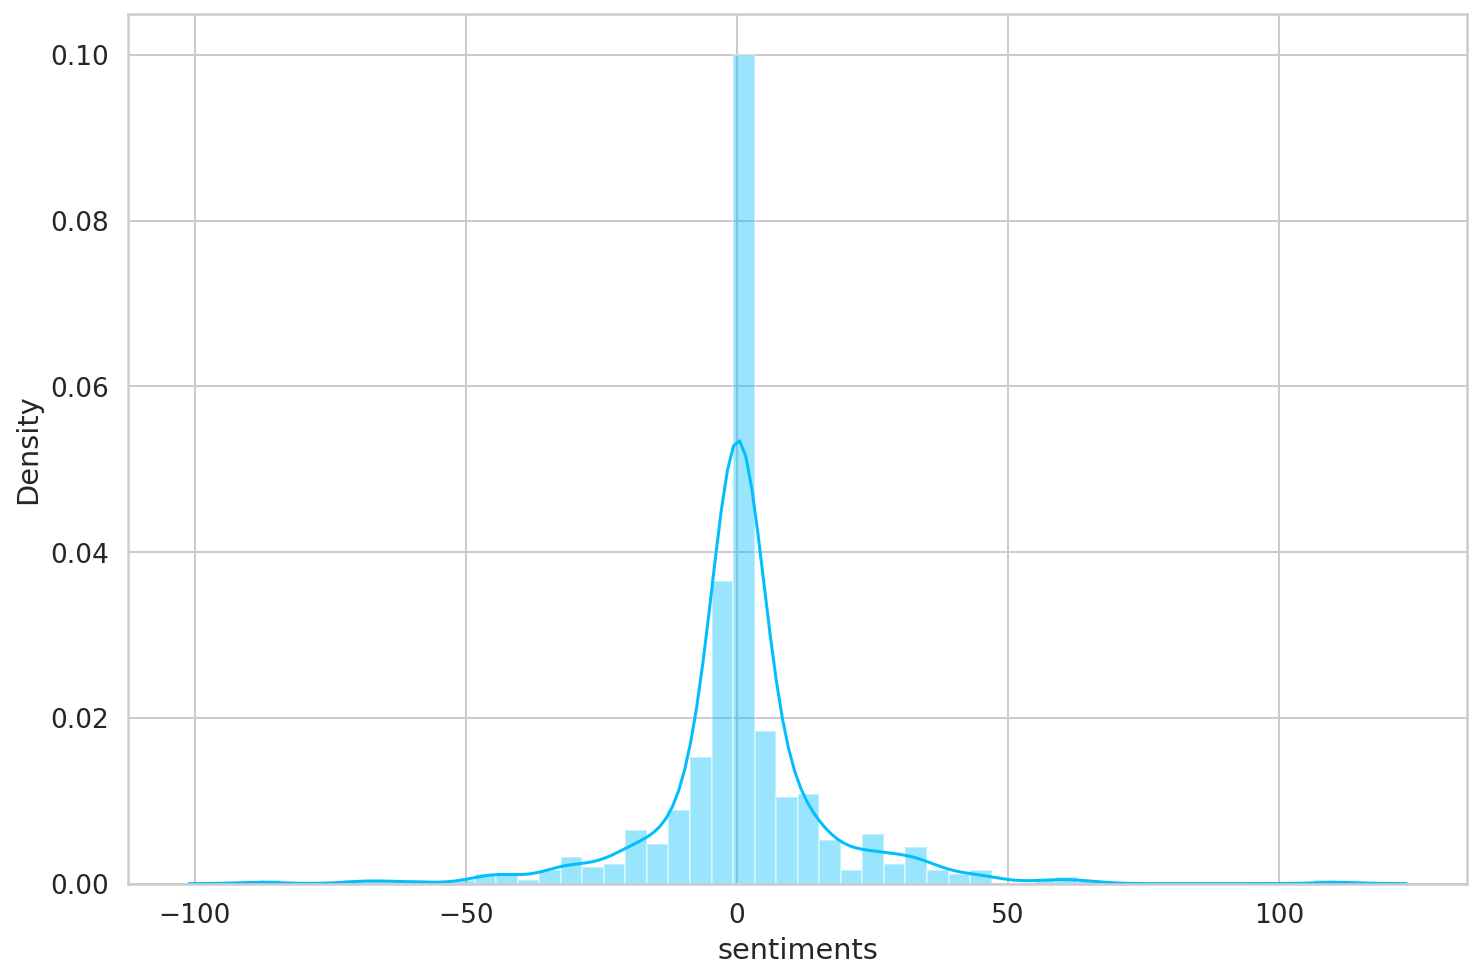

In [51]:
sns.distplot(df['daily_return'])
plt.xlabel('sentiments');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


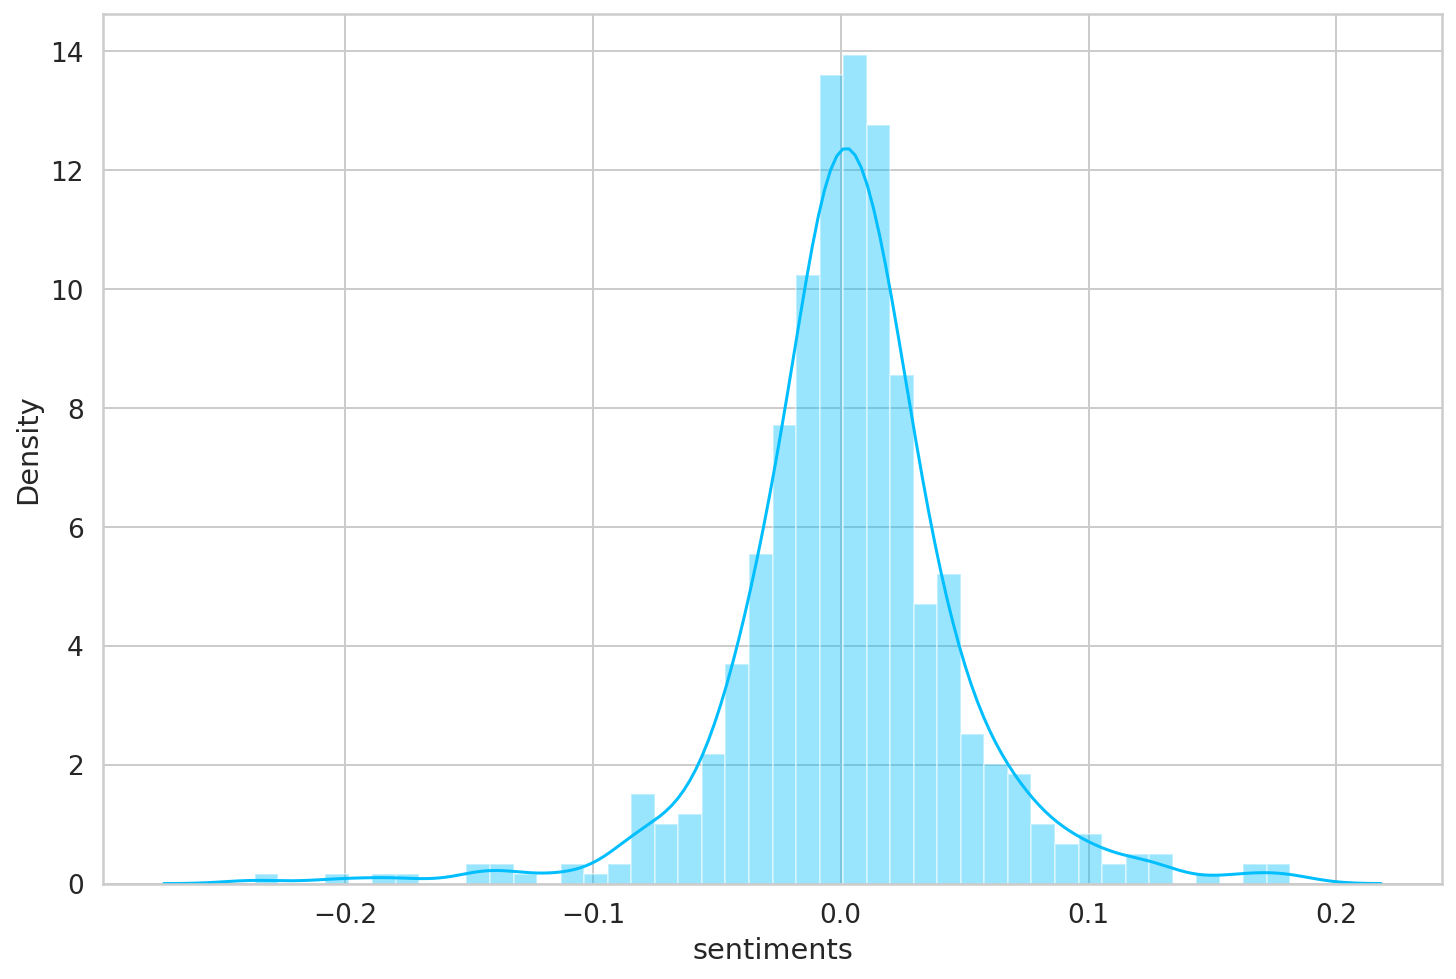

In [49]:
sns.distplot(df['daily_return_log'])
plt.xlabel('sentiments');

In [249]:
df_2021 = df.loc[(df.date > '2021-01-01') & (df.date < '2021-06-01')]
ford_wa_2021 = ford_wa.loc[(ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-01-01') & (ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-06-01')]
tsla_policy_wa_2021 = tsla_policy_wa.loc[(tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-01-01') & (tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-06-01')]
nasdaq_wa_2021 = nasdaq_wa.loc[(nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-01-01') & (nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-06-01')]
lucid_wa_2021 = lucid_wa.loc[(lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-01-01') & (lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-06-01')]

In [222]:
tsla_policy.loc[tsla_policy['weighted_label'] > 800]

,date,place,username,name,tweet,nlikes,nreplies,nretweets,retweet,text_processed,text_processed_notags,sentiment_label,sentiment_neg,sentiment_neu,sentiment_pos,weights,weighted_label,weighted_neg,weighted_neu,weighted_pos
27,2019-01-07 05:52:52,NaN,XHNews,China Xinhua News,U.S. electric carmaker Tesla Inc. on Monday br...,3610,114,764,False,U.S. electric carmaker Tesla Inc. on Monday br...,U.S. electric carmaker Tesla Inc. on Monday br...,1,0.001323,0.159426,0.839251,4489,4489,5.937636,715.663808,3767.398457
2032,2019-11-25 08:33:18,NaN,AdamMGrant,Adam Grant,"No matter how brilliant you are, your ideas wo...",1009,34,361,False,"No matter how brilliant you are, your ideas wo...","No matter how brilliant you are, your ideas wo...",1,0.193243,0.384837,0.421921,1405,1405,271.505909,540.695521,592.798654
5496,2021-03-05 13:30:12,NaN,SawyerMerritt,Sawyer Merritt,BREAKING: Tesla has launched a new social medi...,711,36,106,False,BREAKING: Tesla has launched a new social medi...,BREAKING: Tesla has launched a new social medi...,1,0.002596,0.371456,0.625948,854,854,2.217162,317.223373,534.559447
6030,2021-05-03 13:56:02,NaN,MODL3PILOT,Christian,Just switched to @Tesla insurance took 10 sec...,2474,71,185,False,Just switched to [user] insurance took 10 sec...,Just switched to insurance took 10 seconds t...,1,0.020630,0.250522,0.728848,2731,2731,56.340882,684.174408,1990.484707


In [224]:
df[(df['date'] > '2019-01-01') & (df['date'] < '2019-01-30')]

,adjclose,volume,daily_return,date
0,60.071999,34826000,-1.952000,2019-01-03
1,63.537998,36970500,3.466000,2019-01-04
2,66.991997,37756000,3.453999,2019-01-07
3,67.070000,35042500,0.078003,2019-01-08
4,67.706001,27164500,0.636002,2019-01-09
5,68.994003,30282000,1.288002,2019-01-10
6,69.452003,25195500,0.458000,2019-01-11
7,66.879997,26236500,-2.572006,2019-01-14
8,68.886002,30283000,2.006004,2019-01-15
9,69.209999,23458500,0.323997,2019-01-16


In [199]:
tsla_policy.loc[tsla_policy['weighted_label'] == max(tsla_policy['weighted_label'])]

,date,place,username,name,tweet,nlikes,nreplies,nretweets,retweet,text_processed,text_processed_notags,sentiment_label,sentiment_neg,sentiment_neu,sentiment_pos,weights,weighted_label,weighted_neg,weighted_neu,weighted_pos
27,2019-01-07 05:52:52,NaN,XHNews,China Xinhua News,U.S. electric carmaker Tesla Inc. on Monday br...,3610,114,764,False,U.S. electric carmaker Tesla Inc. on Monday br...,U.S. electric carmaker Tesla Inc. on Monday br...,1,0.001323,0.159426,0.839251,4489,4489,5.937636,715.663808,3767.398457


In [209]:
list(tsla_policy['tweet'].loc[tsla_policy['date'].apply(lambda x: x.strftime('%Y-%m-%d')) == '2019-01-07']

['U.S. electric carmaker #Tesla Inc. on Monday broke ground on its #Shanghai factory, becoming the first to benefit from a new policy allowing foreign carmakers to set up wholly-owned subsidiaries in China.  https://t.co/xc7zmb8tHa',
 'U.S. electric carmaker #Tesla Inc. on Monday broke ground on its #Shanghai factory, becoming the first to benefit from a new policy allowing foreign carmakers to set up wholly-owned subsidiaries in China.  https://t.co/6dDKHA8jwv',
 'U.S. electric carmaker Tesla Inc. on Monday broke ground on its Shanghai factory, becoming the first to benefit from a new policy allowing foreign carmakers to set up wholly-owned subsidiaries in China  https://t.co/LG9O5TLP3O',
 'U.S. electric carmaker #Tesla Inc. on Monday broke ground on its Shanghai factory, becoming the first to benefit from a new policy allowing foreign carmakers to set up wholly-owned subsidiaries in #China  https://t.co/IZUKOOXOmA',
 'China: Tesla Inc broke ground on its Shanghai factory, becoming th

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


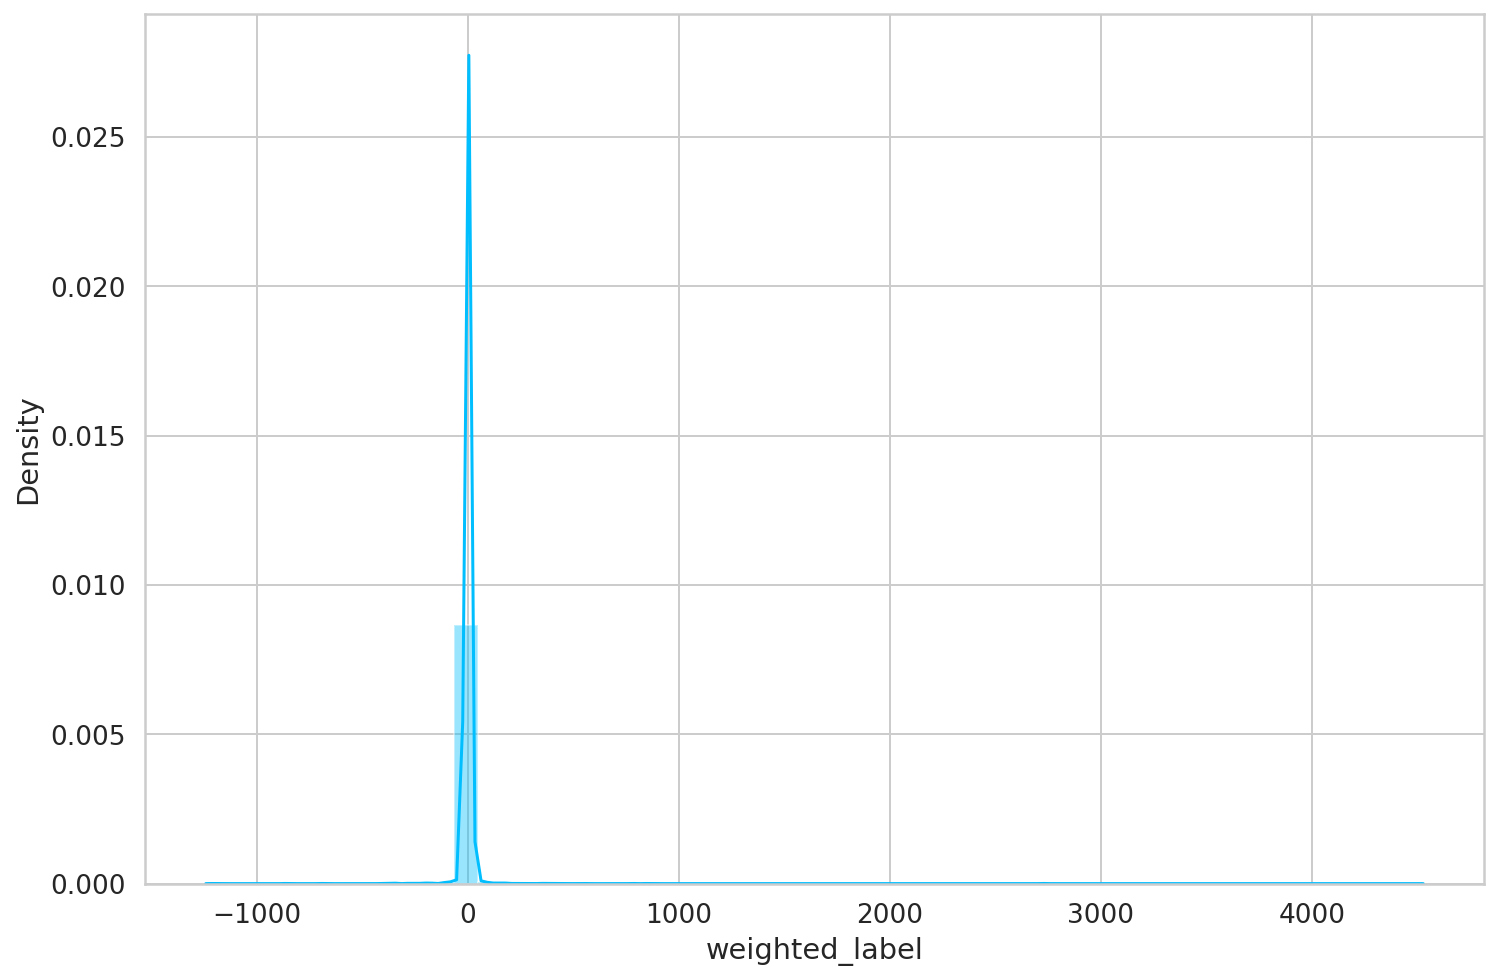

In [220]:
sns.distplot(tsla_policy['weighted_label'])
# plt.xlim([0, 100]);
# plt.xlabel('Frequency');

In [3]:
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import pandas as pd
import numpy as np

In [91]:
tsla_policy.nlargest(5,'wa_score')[['date', 'tweet', 'wa_score']]

,date,tweet,wa_score
27,2019-01-07,U.S. electric carmaker Tesla Inc. on Monday br...,7.048423
1203,2019-07-13,Tesla Model 3 could be among the most competit...,6.429663
6030,2021-05-03,Just switched to @Tesla insurance took 10 sec...,5.644877
4574,2020-11-06,Proof-of-stake reduces Ethereum security costs...,5.043717
3371,2020-06-05,To revive sluggish econ &amp; reverse rising u...,4.878598


In [92]:
tsla_policy.nsmallest(5,'wa_score')[['date', 'tweet', 'wa_score']]

,date,tweet,wa_score
4774,2020-12-17,You ever notice that this asshole @Jim_Jordan ...,-6.419715
955,2019-05-26,Not a fan of this new charging policy. It's ov...,-4.678445
2904,2020-04-22,What a lunatic question @kieran_gilbert asked....,-4.379613
801,2019-05-01,Tesla introduces a Canada-only electric vehicl...,-4.372736
5664,2021-03-24,This Tesla policy is ridiculous. So if bitcoi...,-4.203416


In [108]:
df['log_price'] = np.log(df['adjclose'])

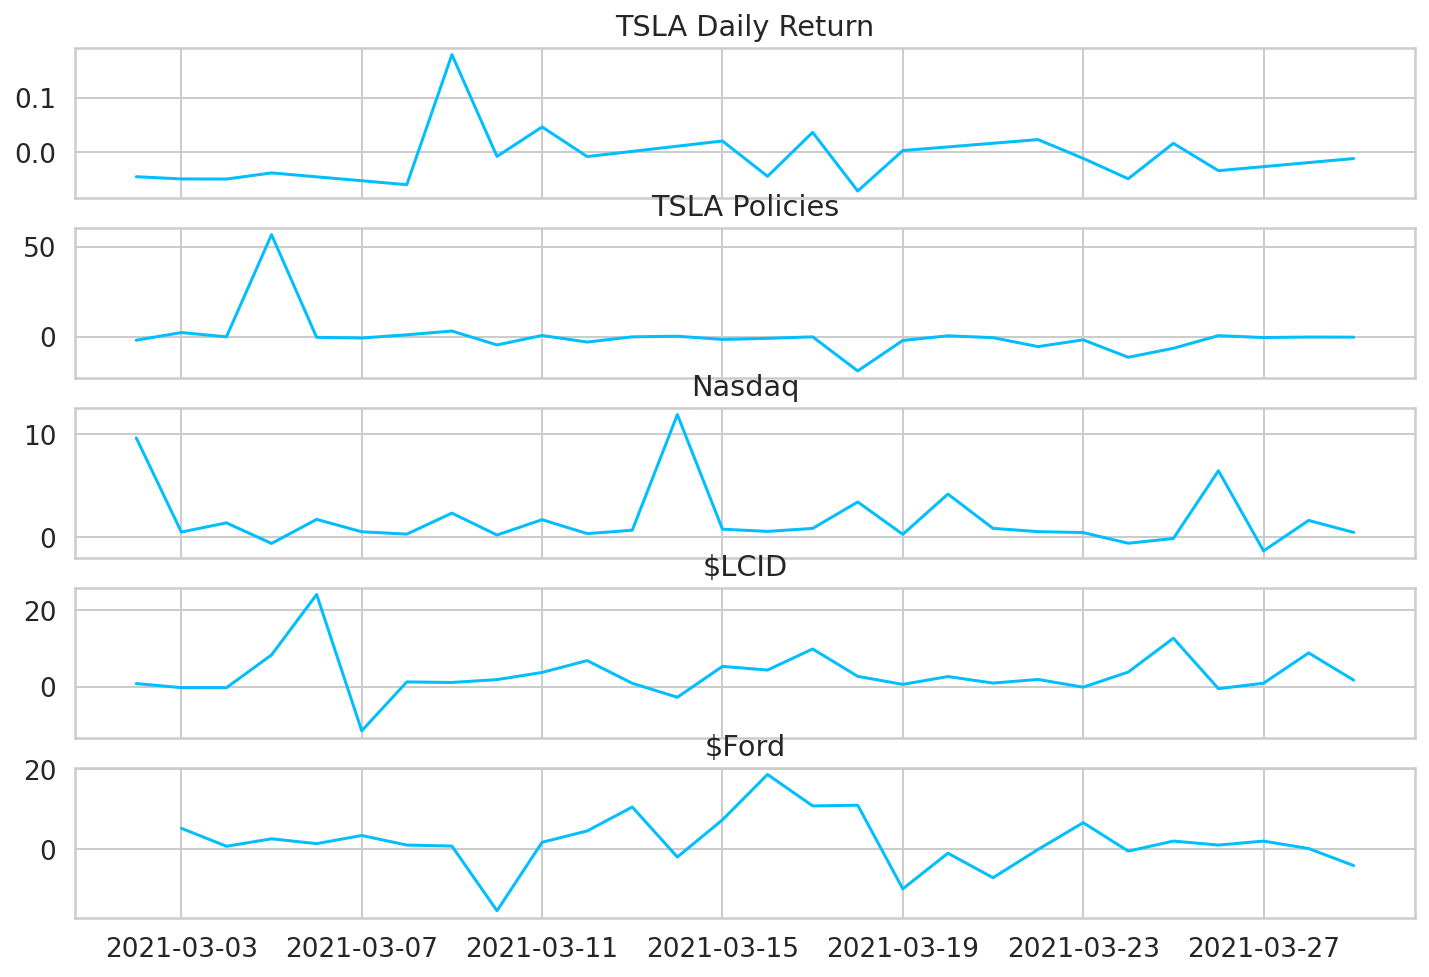

In [115]:
df_short = df.loc[(df.date > '2021-03-01') & (df.date < '2021-03-30')]
ford_wa_short = ford_wa.loc[(ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]
tsla_policy_wa_short = tsla_policy_wa.loc[(tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]
nasdaq_wa_sbort = nasdaq_wa.loc[(nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]
lucid_wa_short = lucid_wa.loc[(lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]

fig=plt.figure()
gs = gridspec.GridSpec(5, 1) 
ax0 = plt.subplot(gs[0])
ax0.plot(df_short.date, df_short.daily_return_log)
plt.setp(ax0.get_xticklabels(), visible=False)
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.plot(tsla_policy_wa_short.date, tsla_policy_wa_short['weighted_label'])
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(gs[2], sharex = ax0)
ax2.plot(nasdaq_wa_sbort.date, nasdaq_wa_sbort['weighted_label'])
plt.setp(ax2.get_xticklabels(), visible=False)
ax3 = plt.subplot(gs[3], sharex = ax0)
ax3.plot(lucid_wa_short.date, lucid_wa_short['weighted_label'])
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = plt.subplot(gs[4], sharex = ax0)
ax4.plot(ford_wa_short.date, ford_wa_short['weighted_label'])


ax0.title.set_text('TSLA Daily Return')
ax1.title.set_text('TSLA Policies')
ax2.title.set_text('Nasdaq')
ax3.title.set_text('$LCID')
ax4.title.set_text('$Ford')
ax0.xaxis.set_major_locator(MaxNLocator(8))

In [20]:
lucid_wa_short

,date,weighted_label,weighted_neg,weighted_neu,weighted_pos,weighted_label_log,weighted_neg_log,weighted_neu_log,weighted_pos_log,wa_score
3,2019-01-03,2.500000,0.033375,0.471000,2.495625,0.895880,0.012075,0.170073,0.896833,0.890289
4,2019-01-04,0.428571,0.286252,1.969671,0.744077,0.156945,0.097164,0.661911,0.264788,0.237276
5,2019-01-05,4.000000,0.054050,0.316866,3.629085,1.386294,0.018732,0.109817,1.257745,1.240496
6,2019-01-08,0.000000,0.011635,1.335687,0.652678,0.000000,0.004032,0.462914,0.226201,0.224862
7,2019-01-09,0.000000,0.499516,1.228615,0.938535,0.000000,0.173119,0.425806,0.325272,0.210751
8,2019-01-12,0.000000,0.751101,2.087582,0.161317,0.000000,0.275056,0.764481,0.059075,-0.024580
9,2019-01-14,2.666667,0.184824,1.951129,2.530713,0.780355,0.060176,0.618892,0.746488,0.721942
10,2019-01-15,1.666667,0.037262,1.189401,1.773337,0.536479,0.012867,0.410611,0.575099,0.573232
11,2019-01-17,0.000000,0.069621,1.878923,0.051457,0.000000,0.024129,0.651185,0.017834,0.016373
12,2019-01-18,7.750000,0.236967,1.884370,7.628663,1.015111,0.059941,0.516341,1.115841,1.084698


In [34]:
ford_wa_short['wa_score']

0    0.050346
Name: wa_score, dtype: float64

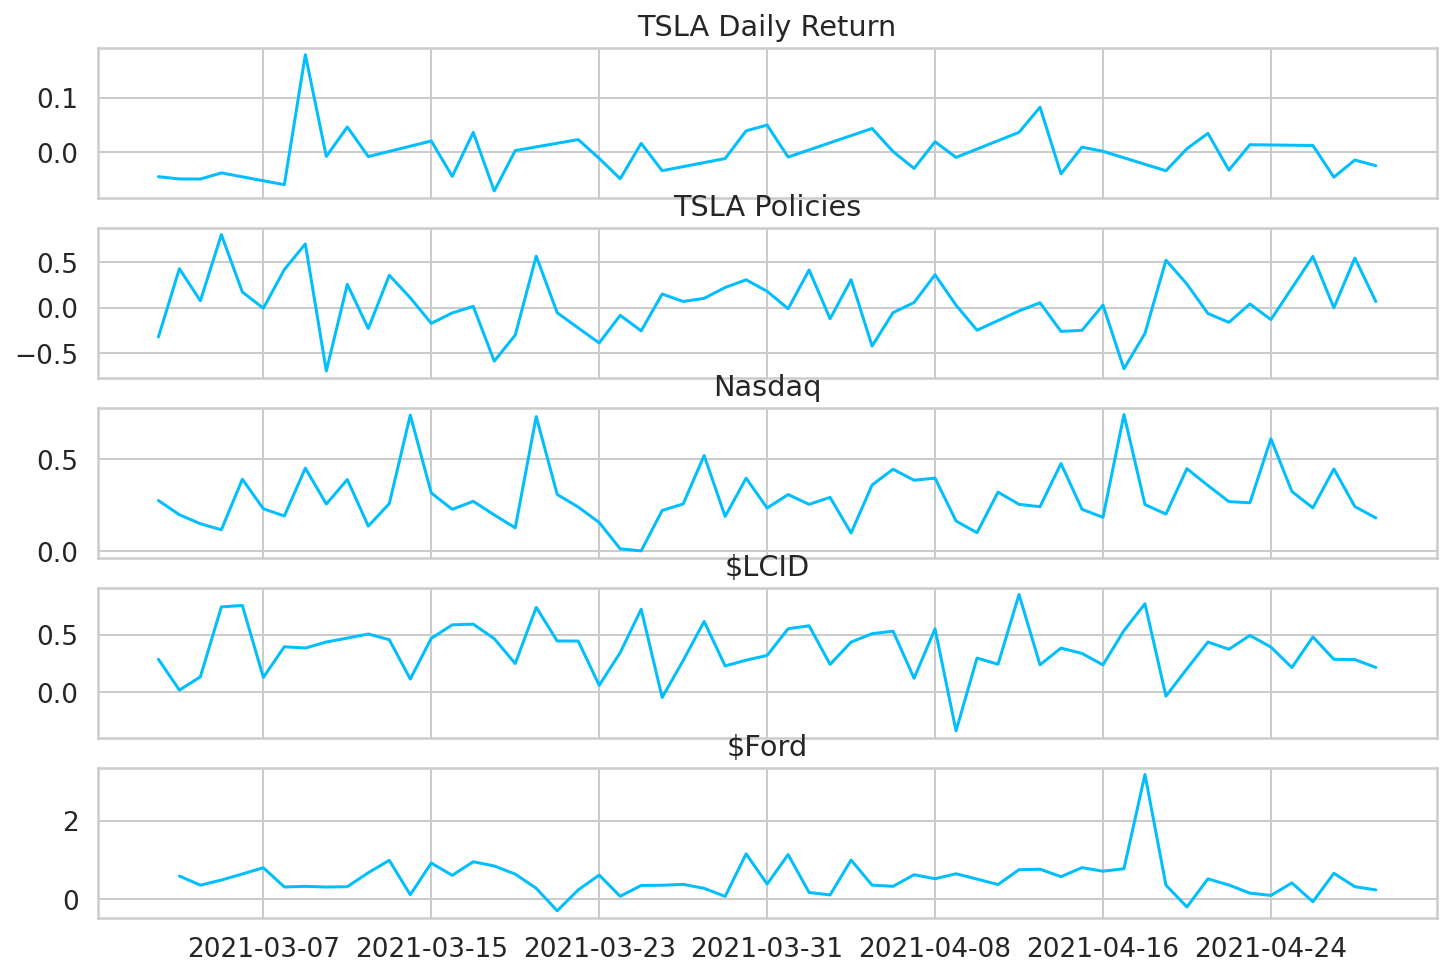

In [38]:
start, end = '2021-03-01', '2021-04-30'
df_short = df.loc[(df.date > start) & (df.date < end)]
ford_wa_short = ford_wa.loc[(ford_wa.date > start) & (ford_wa.date < end)]
tsla_policy_wa_short = tsla_policy_wa.loc[(tsla_policy_wa.date > start) & (tsla_policy_wa.date < end)]
nasdaq_wa_sbort = nasdaq_wa.loc[(nasdaq_wa.date > start) & (nasdaq_wa.date < end)]
lucid_wa_short = lucid_wa.loc[(lucid_wa.date > start) & (lucid_wa.date < end)]

fig=plt.figure()
gs = gridspec.GridSpec(5, 1) 
ax0 = plt.subplot(gs[0])
ax0.plot(pd.to_datetime(df_short.date), df_short.daily_return_log)
plt.setp(ax0.get_xticklabels(), visible=False)
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.plot(pd.to_datetime(tsla_policy_wa_short.date), tsla_policy_wa_short['wa_score'])
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(gs[2], sharex = ax0)
ax2.plot(pd.to_datetime(nasdaq_wa_sbort.date), nasdaq_wa_sbort['wa_score'])
plt.setp(ax2.get_xticklabels(), visible=False)
ax3 = plt.subplot(gs[3], sharex = ax0)
ax3.plot(pd.to_datetime(lucid_wa_short.date), lucid_wa_short['wa_score'])
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = plt.subplot(gs[4], sharex = ax0)
ax4.plot(pd.to_datetime(ford_wa_short.date), ford_wa_short['wa_score'])


ax0.title.set_text('TSLA Daily Return')
ax1.title.set_text('TSLA Policies')
ax2.title.set_text('Nasdaq')
ax3.title.set_text('$LCID')
ax4.title.set_text('$Ford')
ax0.xaxis.set_major_locator(MaxNLocator(8))

In [47]:
tsla_policy_wa[['date', 'wa_score']].loc[(tsla_policy_wa['date'] > '2021-03-01') & (tsla_policy_wa['date'] < '2021-03-12')]

,date,wa_score
762,2021-03-02,-0.323108
763,2021-03-03,0.426560
764,2021-03-04,0.074031
765,2021-03-05,0.800730
766,2021-03-06,0.170992
767,2021-03-07,-0.007824
768,2021-03-08,0.417596
769,2021-03-09,0.698135
770,2021-03-10,-0.695754
771,2021-03-11,0.254432


In [45]:
tsla_policy[['date','tweet','sentiment_label', 'nlikes', 'nreplies']].loc[(tsla_policy['date'] > '2021-03-01') & (tsla_policy['date'] < '2021-03-12')]

,date,tweet,sentiment_label,nlikes,nreplies
5454,2021-03-01 16:03:46,@ICannot_Enough What do you think Tesla’s reve...,1,0,1
5455,2021-03-01 17:57:29,@Erdayastronaut @JackAButler @elonmusk @WholeM...,0,0,0
5456,2021-03-01 18:02:23,@AskLiberty @AskLiberty y’all don’t even under...,0,0,0
5457,2021-03-01 18:08:51,@TeslaOwls Depends on the policy wording. When...,1,1,1
5458,2021-03-02 05:55:09,@alexmd2 Nah it’s Tesla model Y at the moment....,0,0,1
...,...,...,...,...,...
5550,2021-03-10 17:54:55,@Timcast ; foundation a bright 🌞 future mesmer...,1,0,0
5551,2021-03-11 13:00:02,.@Tesla is still accepting applications for th...,1,1,0
5552,2021-03-11 13:14:53,"Ironically, if @shannonmstirone adopted @jdota...",1,3,0
5553,2021-03-11 13:27:20,@TheRealDaybyDay Thanks. Just simple math if T...,2,0,1


In [22]:
start, end = '2021-02-01', '2021-04-01'
df_short = df.loc[(df.date > start) & (df.date < end)]
ford_wa_short = ford_wa.loc[(ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > start) & (ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < end)]
tsla_policy_wa_short = tsla_policy_wa.loc[(tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > start) & (tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < end)]
nasdaq_wa_sbort = nasdaq_wa.loc[(nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > start) & (nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < end)]
lucid_wa_short = lucid_wa.loc[(lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > start) & (lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < end)]

fig=plt.figure()
gs = gridspec.GridSpec(6, 1) 
ax0 = plt.subplot(gs[0], sharex = ax0)
ax0.plot(df_short.date, df_short['log_price'])
plt.setp(ax0.get_xticklabels(), visible=False)
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.plot(df_short.date, df_short.daily_return_log)
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(gs[2], sharex = ax0)
ax2.plot(tsla_policy_wa_short.date, tsla_policy_wa_short['wa_score'])
plt.setp(ax2.get_xticklabels(), visible=False)
ax3 = plt.subplot(gs[3], sharex = ax0)
ax3.plot(nasdaq_wa_sbort.date, nasdaq_wa_sbort['wa_score'])
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = plt.subplot(gs[4], sharex = ax0)
ax4.plot(lucid_wa_short.date, lucid_wa_short['wa_score'])
plt.setp(ax4.get_xticklabels(), visible=False)
ax5 = plt.subplot(gs[5], sharex = ax0)
ax5.plot(ford_wa_short.date, ford_wa_short['wa_score'])


ax0.title.set_text('TSLA Log Price')
ax1.title.set_text('TSLA Log Return')
ax2.title.set_text('TSLA Policies')
ax3.title.set_text('Nasdaq')
ax4.title.set_text('$LCID')
ax5.title.set_text('$Ford')
ax0.xaxis.set_major_locator(MaxNLocator(8))

AttributeError: ignored

In [129]:
ford_wa_short['wa_score'].shape

(56,)

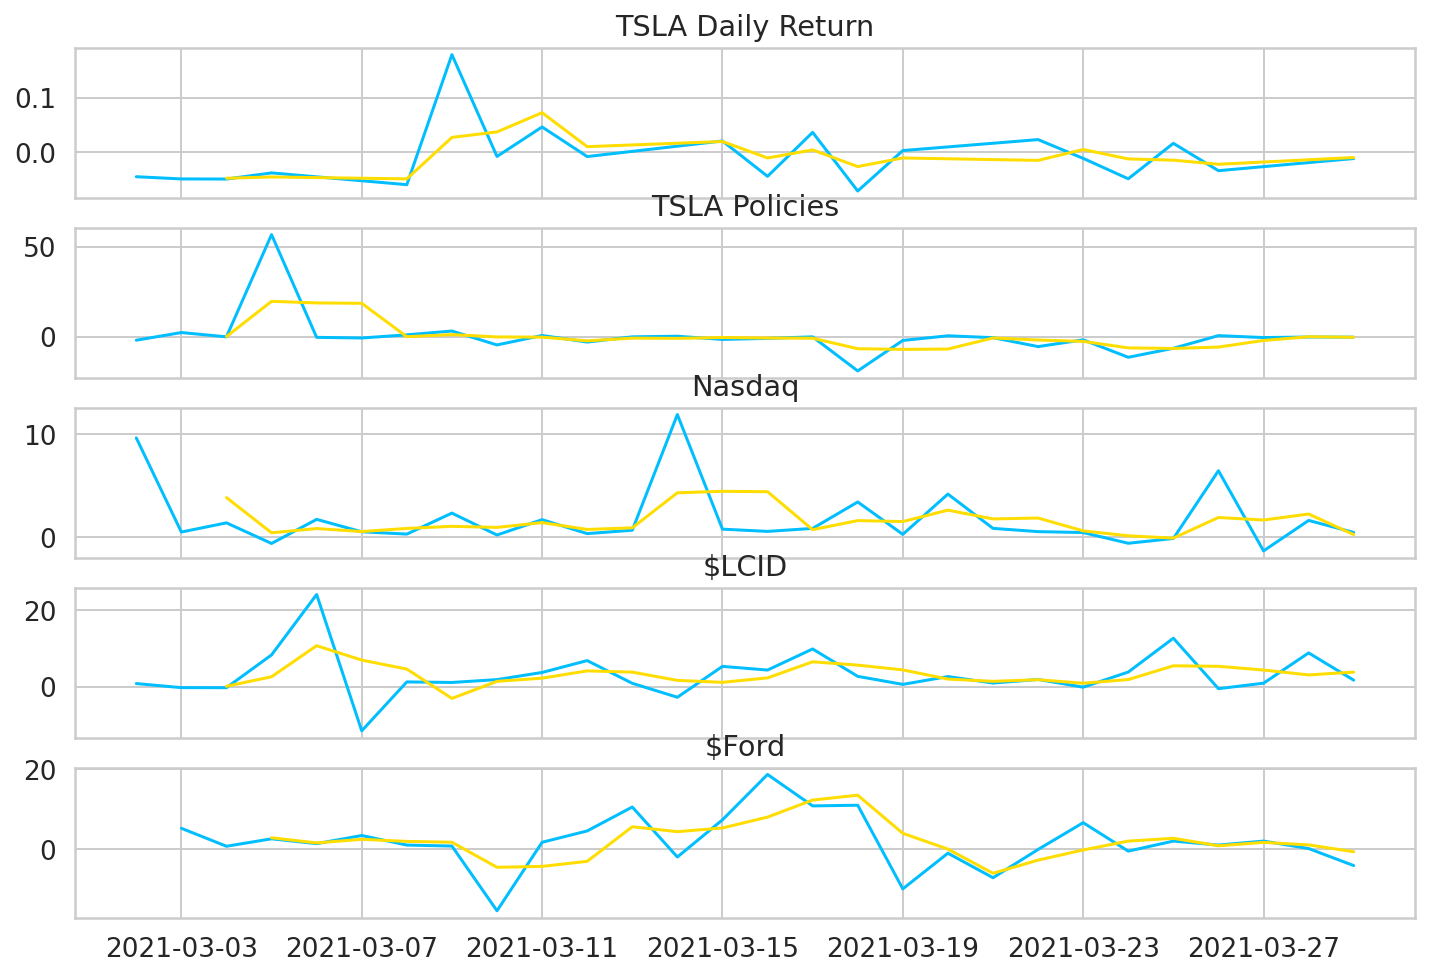

In [116]:
df_short = df.loc[(df.date > '2021-03-01') & (df.date < '2021-03-30')]
ford_wa_short = ford_wa.loc[(ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (ford_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]
tsla_policy_wa_short = tsla_policy_wa.loc[(tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (tsla_policy_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]
nasdaq_wa_sbort = nasdaq_wa.loc[(nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (nasdaq_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]
lucid_wa_short = lucid_wa.loc[(lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) > '2021-03-01') & (lucid_wa.date.apply(lambda x: x.strftime('%Y-%m-%d')) < '2021-03-30')]

fig=plt.figure()
gs = gridspec.GridSpec(5, 1) 
ax0 = plt.subplot(gs[0])
ax0.plot(df_short.date, df_short.daily_return_log)
ax0.plot(df_short.date, df_short.daily_return_log.rolling(3).mean().ffill())
plt.setp(ax0.get_xticklabels(), visible=False)
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.plot(tsla_policy_wa_short.date, tsla_policy_wa_short['weighted_label'])
ax1.plot(tsla_policy_wa_short.date, tsla_policy_wa_short['weighted_label'].rolling(3).mean().ffill())
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(gs[2], sharex = ax0)
ax2.plot(nasdaq_wa_sbort.date, nasdaq_wa_sbort['weighted_label'])
ax2.plot(nasdaq_wa_sbort.date, nasdaq_wa_sbort['weighted_label'].rolling(3).mean().ffill())
plt.setp(ax2.get_xticklabels(), visible=False)
ax3 = plt.subplot(gs[3], sharex = ax0)
ax3.plot(lucid_wa_short.date, lucid_wa_short['weighted_label'])
ax3.plot(lucid_wa_short.date, lucid_wa_short['weighted_label'].rolling(3).mean().ffill())
plt.setp(ax3.get_xticklabels(), visible=False)
ax4 = plt.subplot(gs[4], sharex = ax0)
ax4.plot(ford_wa_short.date, ford_wa_short['weighted_label'])
ax4.plot(ford_wa_short.date, ford_wa_short['weighted_label'].rolling(3).mean().ffill())


ax0.title.set_text('TSLA Daily Return')
ax1.title.set_text('TSLA Policies')
ax2.title.set_text('Nasdaq')
ax3.title.set_text('$LCID')
ax4.title.set_text('$Ford')
ax0.xaxis.set_major_locator(MaxNLocator(8))

In [272]:
tsla_policy.nsmallest(5,'weighted_label')

,date,place,username,name,tweet,nlikes,nreplies,nretweets,retweet,text_processed,text_processed_notags,sentiment_label,sentiment_neg,sentiment_neu,sentiment_pos,weights,weighted_label,weighted_neg,weighted_neu,weighted_pos
801,2019-05-01,NaN,Swiftie01,Catherine Swift,Tesla introduces a Canada-only electric vehicl...,807,108,288,False,Tesla introduces a Canada-only electric vehicl...,Tesla introduces a Canada-only electric vehicl...,-1,0.788988,0.181991,0.029021,1204,-1204,949.941973,219.116634,34.941348
4774,2020-12-17,NaN,TitusNation,Titus,You ever notice that this asshole @Jim_Jordan ...,747,48,66,False,You ever notice that this asshole [user] never...,You ever notice that this asshole never bring...,-1,0.974512,0.022766,0.002722,862,-862,840.029120,19.624218,2.346681
6335,2021-06-01,NaN,WSJ,The Wall Street Journal,Tesla failed to oversee Elon Musk's tweets in ...,458,105,125,False,Tesla failed to oversee Elon Musk's tweets in ...,Tesla failed to oversee Elon Musk's tweets in ...,-1,0.641933,0.338541,0.019526,689,-689,442.291734,233.255025,13.453281
6212,2021-05-19,NaN,BriannaWu,Brianna Wu,It is literally impossible to have any kind of...,370,21,17,False,It is literally impossible to have any kind of...,It is literally impossible to have any kind of...,-1,0.726053,0.233888,0.040059,409,-409,296.955579,95.660376,16.384063
3458,2020-06-19,NaN,GCBCoalition,Green Card Backlog Coalition,👉NOT qualified for #DACA 👉SPECIAL NEEDS #H4Dre...,183,4,193,False,[backhand_index_pointing_right]NOT qualified f...,backhand_index_pointing_rightNOT qualified for...,-1,0.683847,0.298533,0.017619,381,-381,260.545859,113.741149,6.712967


In [274]:
list(tsla_policy.nsmallest(5,'weighted_label')['tweet'])

['Tesla introduces a Canada-only electric vehicle to ensure maximum fleecing of Cdn taxpayers. Priced at $44,999 to get under $45K limit to qualify for $5K kickback. Range is 150km. This is the kind of stupid result bad policy enables.',
 'You ever notice that this asshole @Jim_Jordan never brings up policy or an idea? Just “Liberals want to beat Santa to death with aborted fetus’ and then give money to Tesla driving crack dealers!”  What a worthless human, nothing for the American people but lies and Fear. Fucker',
 "Tesla failed to oversee Elon Musk's tweets in recent years, twice violating a court-ordered policy that requires company lawyers to approve them, the SEC said. Musk and Tesla paid $40 million to settle a 2018 action brought by the SEC over his tweets.  https://t.co/u2nyXDmi27",
 'It is literally impossible to have any kind of rational policy discussion about transportation with a Tesla fanboy.   Unless you’re 100 percent committed to the idea that Teslas alone solve clima

In [88]:
ford.date = pd.to_datetime(ford.date).dt.date.apply(lambda x: x.strftime('%Y-%m-%d'))
lucid.date = pd.to_datetime(lucid.date).dt.date.apply(lambda x: x.strftime('%Y-%m-%d'))
nasdaq.date = pd.to_datetime(nasdaq.date).dt.date.apply(lambda x: x.strftime('%Y-%m-%d'))
tsla_policy.date = pd.to_datetime(tsla_policy.date).dt.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
lucid.date.apply(lambda x: x.strftime('%Y-%m-%d')).unique()

In [ ]:
ford_train, ford_test = train_test_split(df, test_size=0.1, random_state=40)
ford_val, ford_test = train_test_split(df_test, test_size=0.5, random_state=40)
ford_train.shape, ford_val.shape, ford_test.shape

df_train, df_test = train_test_split(df, test_size=0.1, random_state=40)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=40)
df_train.shape, df_val.shape, df_test.shape

df_train, df_test = train_test_split(df, test_size=0.1, random_state=40)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=40)
df_train.shape, df_val.shape, df_test.shape

### Model exploration

### Evaluation and Comparison with benchmark models

# Conclusion and improvements

### TODO



1.   Topic analysis. E.g. a tweet that includes keyword 'tesla' may be a praise on Lucid, and a play down on Tesla. So the sentiment is actually reversed. To solve: add a 'not relevant' class to the training set
2.   Better way of dealing with retweets
3.   Filter out neutral/ad tweets(official accounts)



# Reference